

# <font size="+3"><span style='color:#2994ff'> **P7 - Implémentez un modèle de scoring** </span></font>


<a id='LOADING_LIBRARIES'></a>

---

---

<font size="+1"> **LOADING THE LIBRARIES** </font>

---

In [1]:
# File system management
import os
import sys
import pickle
import dill
from datetime import datetime
import tempfile

# Data manipulation
import numpy as np
import numpy.typing as npt
import pandas as pd
from collections import Counter

# Scikit-learn
import sklearn
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_validate, \
    cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, \
    RepeatedStratifiedKFold
from sklearn.metrics import recall_score, precision_score, roc_curve, \
    roc_auc_score, f1_score, accuracy_score, average_precision_score, \
    fbeta_score, make_scorer, classification_report, confusion_matrix, \
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, \
    precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.utils import compute_sample_weight

# XGBoost
import xgboost as xgb

# LightGBM
import lightgbm as ltb

# Balancing data
import imblearn
from imblearn import pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
import shap

# Version tracking
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Personnal packages
import tools_dataframe
import tools_preprocessing
import tools_feat_engineering
import tools_modeling

# Validation code PEP8
%load_ext pycodestyle_magic
%pycodestyle_on

# Warnings
import warnings
from warnings import simplefilter
warnings.filterwarnings(action='once')
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=ValueError)
simplefilter(action='ignore', category=UserWarning)


# Versions
print('Version of used libraries :')

print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Sklearn               : ' + sklearn.__version__)
print('Dataframe XG Boost      : ' + xgb.__version__)
print('Light GBM     : ' + ltb.__version__)
print('Imblearn      : ' + imblearn.__version__)
print('MLFlow      : ' + mlflow.__version__)
now = datetime.now().isoformat()
print('\nLaunched on : ' + now)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Version of used libraries :
Python                : 3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.24.3
Pandas                : 1.5.3
Sklearn               : 1.2.2
Dataframe XG Boost      : 1.7.6
Light GBM     : 4.0.0
Imblearn      : 0.10.1
MLFlow      : 2.5.0

Launched on : 2023-08-09T13:33:19.092299



<a id='notebook_settings'></a>


<br>


---
---

<font size="+1"> **NOTEBOOK SETTINGS** </font>

---


In [2]:
#################################
#    -- NOTEBOOK SETTINGS --    #
#################################

%matplotlib inline
sns.set_theme(palette="Set1")

# Random state
seed = 84

# Define training set size
TRAIN_SIZE = 0.8

# Define table for saving model results of data rebalancing esperiences
df_results = pd.DataFrame()

# Define table for saving model scores
df_scores_models = pd.DataFrame()

# Define table for saving probability restults of threshold optimisation
df_results_thresh = pd.DataFrame()

In [3]:
# Define the folder containing the files with the project data
P7_scoring_credit = "/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/"

os.chdir(P7_scoring_credit)

2:80: E501 line too long (102 > 79 characters)



<a id='USED_FUNCTIONS'></a>


<br>


---
---

<font size="+1"> **FUNCTIONS USED IN THIS NOTEBOOK** </font>

---


In [4]:

# -----------------------------------------------------------------------
# -- BUSINESS METRIC
# -----------------------------------------------------------------------

def custom_score(y_real, y_pred, tn_weighting=1, fp_weighting=-1, fn_weighting=-10, tp_weighting=1, **kwargs):
    '''
    Business metric designed to minimise the risk to the bank of granting a loan by penalising false negatives.
    '''
    # tn (true negative): the loan is refunded: the bank earns money. => to maximize
    # fp (false positive) : the loan is denied in error: the bank loses interest, loses profit but does not actually lose money (type I error).
    # fn (false negative) : the loan is approved but the customer defaulting: the bank loses money (type II error). => to minimise
    # tp (true positif) : the loan is rightly denied: the bank neither gains nor loses money.

    '''
    Parameters
    ----------
    y_real : real class, mandatory (0 or 1).
    y_pred : predicted class, mandatory (0 or 1).

    tn_weighting : Weighting of True Negative, optional (1 by default),
    fp_weighting : Weighting of False Positive rate, optional (-1 by default),
    fn_weighting : Weighting of False Negative rate, optional (-10 by default),
    tp_weighting : Weighting of True Positive rate, optional (1 by default),
    kwargs is ignored - added just to avoid errors if used to replace roc_auc_score with parameter zero_division = 0

    Returns
    -------
    score : normalised gain (between 0 and 1) a high score indicates better performance

    '''
    # Confusion matrix
    (tn, fp, fn, tp) = confusion_matrix(y_real, y_pred).ravel()


    # Real Gain
    real_gain = tn * tn_weighting + fp * fp_weighting + fn * fn_weighting + tp * tp_weighting

    # Maximum Gain : all predictions are correct
    gain_max = (fp + tn) * tn_weighting + (fn + tp) * tp_weighting

    # Minimum Gain : all predictions are false
    gain_min = (fp + tn) * fp_weighting + (fn + tp) * fn_weighting

    custom_score = (real_gain - gain_min) / (gain_max - gain_min)

    # Normalised gain (between 0 and 1) a high score indicates better performance
    return custom_score


# -----------------------------------------------------------------------
# -- FUNCTION FOR COMPARING SCORES PERFORMANCES
# -----------------------------------------------------------------------
def add_perf_metrics(df: pd.DataFrame = None,
                     title: str = 'none',
                     ARI: float = 0,
                     k: int = 0,
                     **kwargs):
    """ajout les resultats d'un model """
    global df_resultats
    if df is None:
        df = df_resultats

    resultats = dict(Experience=title)
    resultats = dict(**resultats, **kwargs)
    resultats = {k:[v] for k,v in resultats.items()}

    df = pd.concat([df, pd.DataFrame([resultats])], ignore_index=True)
    return df


# -----------------------------------------------------------------------
# -- CONFUSION MATRIX FOR BINARY CLASSIFICATION
# -----------------------------------------------------------------------

def construct_confusion_matrix(y_true, y_pred, title):

    plt.figure(figsize=(6, 4))

    cm = confusion_matrix(y_true, y_pred)

    labels = ['Non-Defaulters', 'Defaulters']

    sns.heatmap(cm,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d',
                cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix for : {title}')
    plt.ylabel('True Class')
    plt.xlabel('Predict Class')
    plt.show()



# ------------------------------------------------------------------------
# -- DATA BALANCE METHODS EVALUATION
# ------------------------------------------------------------------------

def balance_method_analysis(model, X_train, X_val, y_train, y_val,
                            df_results, title, show_table=True,
                            show_confusion_matrix=True):
    """
    Function to evaluate the data balance method that generates the most important score improvement.

    ------------
    @Parameters
    ------------
    model : initialized classification model, mandatory.
    X_train : train set matrix X, mandatory.
    X_val : validation set matrix X, mandatory.
    y_train : train set vecteur y, mandatory.
    y_val : test set, vecteur y, mandatory.
    df_results : dataframe for scores saving, mandatory
    title : experience name to record in the dataframe, mandatory.
    show_table : shows the results table (optional, default = True).

    ------------
    @Returns
    ------------
    df_results : Performance backup dataframe.
    y_pred : predictions from the tested model
    """
    # Start of execution
    time_start = datetime.now()

    # Training the model with the training set
    model.fit(X_train, y_train)

    # End of train exectuion
    time_end_train = datetime.now()

    # Predictions with the validation set
    y_pred = model.predict(X_val)

    # End of prediction exectuion
    time_end = datetime.now()

    # Probabilities
    y_proba = model.predict_proba(X_val)[:, 1]

    # Metrics computing
    # Recall
    recall = recall_score(y_val, y_pred)
    # Precision
    precision = precision_score(y_val, y_pred)
    # Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    # F-score ou Fbeta
    f1_score = fbeta_score(y_val, y_pred, beta=1)
    f2_score = fbeta_score(y_val, y_pred, beta=2)
    f5_score = fbeta_score(y_val, y_pred, beta=5)
    f10_score = fbeta_score(y_val, y_pred, beta=10)
    # Score ROC AUC
    roc_auc = roc_auc_score(y_val, y_proba)
    # Score AP
    ap_score = average_precision_score(y_val, y_proba)
    # Business metric
    business_metric = custom_score(y_val, y_pred)

    # Training runtime
    time_exec_train = time_end_train - time_start
    # Training+validation runtime
    time_execution = time_end - time_start

    # TN, FP, FN, TP
    (tn, fp, fn, tp) = confusion_matrix(y_val, y_pred).ravel()

    # cross validation
    scoring = ['accuracy', 'roc_auc', 'recall', 'precision']
    scores = cross_validate(model, X_train, y_train, cv=10,
                            scoring=scoring, return_train_score=True)

    # Saving Performance dataframe
    df_results = pd.concat([df_results,(pd.DataFrame({
        'Experience': [title],
        'Business_score': [business_metric],
        'Recall': [recall],
        'Precision': [precision],
        'Accuracy': [accuracy],
        'F1': [f1_score],
        'F2': [f2_score],
        'F5': [f5_score],
        'F10': [f10_score],
        'ROC_AUC': [roc_auc],
        'AP_SCORE': [ap_score],
        'Train runtime': [time_exec_train],
        'Train+Validatin runtime': [time_execution],
        'TN': [tn],
        'FP': [fp],
        'FN': [fn],
        'TP': [tp],
        # Cross-validation
        'Train_auc_CV': [scores['train_accuracy'].mean()],
        'Train_auc_CV +/-': [scores['train_accuracy'].std()],
        'Test_auc_CV': [scores['test_accuracy'].mean()],
        'Test_auc_CV +/-': [scores['test_accuracy'].std()],
        'Train_roc_auc_CV': [scores['train_roc_auc'].mean()],
        'Train_roc_auc_CV +/-': [scores['train_roc_auc'].std()],
        'Test_roc_auc_CV': [scores['test_roc_auc'].mean()],
        'Test_roc_auc_CV +/-': [scores['test_roc_auc'].std()],
        'Train_recall_CV': [scores['train_recall'].mean()],
        'Train_recall_CV +/-': [scores['train_recall'].std()],
        'Test_recall_CV': [scores['test_recall'].mean()],
        'Test_recall_CV +/-': [scores['test_recall'].std()],
        'Train_precision_CV': [scores['train_precision'].mean()],
        'Train_precision_CV +/-': [scores['train_precision'].std()],
        'Test_precision_CV': [scores['test_precision'].mean()],
        'Test_precision_CV +/-': [scores['test_precision'].std()],
    }))], axis =0)

    # dumping the model to pickle file
    with open('model_tests/df_results_scores.pkl', 'wb') as f:
        pickle.dump(df_results, f)

    if show_table:
        mask = df_results['Experience'] == title
        display(df_results[mask].style.hide(axis="index"))

    if show_confusion_matrix:
        construct_confusion_matrix(y_val, y_pred, title)

    return df_results, recall, precision, accuracy, f1_score, f2_score, \
            f5_score, f10_score, roc_auc, ap_score, business_metric, \
            tn, fp, fn, tp

6:80: E501 line too long (110 > 79 characters)
8:80: E501 line too long (111 > 79 characters)
10:80: E501 line too long (84 > 79 characters)
11:80: E501 line too long (143 > 79 characters)
12:80: E501 line too long (130 > 79 characters)
13:80: E501 line too long (93 > 79 characters)
25:80: E501 line too long (116 > 79 characters)
29:80: E501 line too long (87 > 79 characters)
36:5: E303 too many blank lines (2)
37:80: E501 line too long (93 > 79 characters)
47:80: E501 line too long (81 > 79 characters)


ValueError: too many values to unpack (expected 3)

In [5]:
# --------------------------------------------------------------------
# -- MLFlow
# --------------------------------------------------------------------
'''Fonctions for experience tracking'''


# ------------------------------------
# -- LOG METRICS REBALANCING ANALYSIS
# ------------------------------------


def log_mlflow_balance(exper_id, tags, model, title, Business_Metric,
                       n_estimator=None, max_depth=None,
                       Recall=None, Precision=None, Accuracy=None,
                       F1_score=None, F2_score=None,
                       F5_score=None, F10_score=None,
                       Roc_auc=None, AP_score=None,
                       TN=None, FP=None, FN=None, TP=None):

    '''
    Function to log model to MLFlow

    -----------
    @Parameters
    -----------
    exper_id : str, id experiment.
    tags : information about experiment, mandatory.
    model : initialized classification model, mandatory.
    title : experience name to record in the dataframe, mandatory.

    Recall : score value, optional (default = None).
    Precision : score value, optional (default = None).
    Accuracy : score value, optional (default = None).
    F1_score : score value, optional (default = None).
    F2_score : score value, optional (default = None).
    F5_score : score value, optional (default = None).
    F10_score : score value, optional (default = None).
    Roc_auc : score value, optional (default = None).
    AP_score : score value, optional (default = None).

    TN: true negative, optional (default = None).
    FP: false positive, optional (default = None).
    FN: false negative, optional (default = None).
    TP: true positif, optional (default = None).

    -----------
    @Returns
    -----------
    None
    '''

    # Track params and metrics
    with mlflow.start_run(experiment_id=exper_id):
        # Set run name
        mlflow.set_tag("mlflow.runName", title)

        # Set metrics
        mlflow.log_metric('Recall', Recall)
        mlflow.log_metric('Precision', Precision)
        mlflow.log_metric('Accuracy', Accuracy)
        mlflow.log_metric('F1', F1_score)
        mlflow.log_metric('F2', F2_score)
        mlflow.log_metric('F5', F5_score)
        mlflow.log_metric('F10', F10_score)
        mlflow.log_metric('ROC_AUC', Roc_auc)
        mlflow.log_metric('AP_SCORE', AP_score)
        mlflow.log_metric('Business_score', Business_Metric)
        mlflow.log_metric('TN', TN)
        mlflow.log_metric('FP', FP)
        mlflow.log_metric('FN', FN)
        mlflow.log_metric('TP', TP)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, title)

    mlflow.end_run()


# ----------------------------------------
# -- LOG METRICS PARAMETERS OPTIMIZATION
# ----------------------------------------

def log_mlflow_hyperparam(exper_id, tags, model, title, Business_Metric,
                          n_estimator=None, max_depth=None,
                          Recall=None, Precision=None, Accuracy=None,
                          F1_score=None, F2_score=None,
                          F5_score=None, F10_score=None,
                          Roc_auc=None, AP_score=None,
                          TN=None, FP=None, FN=None, TP=None,
                          params=None):

    '''
    Function to log model to MLFlow

    -----------
    @Parameters
    -----------
    exper_id : str, id experiment.
    tags : information about experiment
    model : initialized classification model, mandatory.
    title : experience name to record in the dataframe, mandatory.

    Recall : score value, optional (default = None).
    Precision : score value, optional (default = None).
    Accuracy : score value, optional (default = None).
    F1_score : score value, optional (default = None).
    F2_score : score value, optional (default = None).
    F5_score : score value, optional (default = None).
    F10_score : score value, optional (default = None).
    Roc_auc : score value, optional (default = None).
    AP_score : score value, optional (default = None).

    TN: true negative, optional (default = None).
    FP: false positive, optional (default = None).
    FN: false negative, optional (default = None).
    TP: true positif, optional (default = None).

    params : parameters associated to Grid Search best results

    -----------
    @Returns
    -----------
    None
    '''

    # Track params and metrics
    with mlflow.start_run(experiment_id=exper_id):
        # Set run name
        mlflow.set_tag("mlflow.runName", title)
        mlflow.set_tags(tags)

        # Set metrics
        mlflow.log_metric('Recall', Recall)
        mlflow.log_metric('Precision', Precision)
        mlflow.log_metric('Accuracy', Accuracy)
        mlflow.log_metric('F1', F1_score)
        mlflow.log_metric('F2', F2_score)
        mlflow.log_metric('F5', F5_score)
        mlflow.log_metric('F10', F10_score)
        mlflow.log_metric('ROC_AUC', Roc_auc)
        mlflow.log_metric('AP_SCORE', AP_score)
        mlflow.log_metric('Business_score', Business_Metric)
        mlflow.log_metric('TN', TN)
        mlflow.log_metric('FP', FP)
        mlflow.log_metric('FN', FN)
        mlflow.log_metric('TP', TP)

        # Set params
        mlflow.log_params(params)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, title)

    mlflow.end_run()

In [6]:
# -------------------------------------------------
#    -- FUNCTION FOR TESTING METRICS PERFORMANCE
# -------------------------------------------------

def performance_metrics(y_true, y_pred, y_proba=None):
    """
    Calculation of several metrics (to add to gridsearch cross-validated
    results) for more precise measures of these metrics (mean, std),
    run cross_validation on metrics.

    Example:
    > scoring = ['roc_auc','precision', 'recall', 'f1','accuracy']
    > res = sklearn.model_selection.cross_validate(best_model, X_val, y_val,
    cv=5, scoring=scoring) 
    """

    # TN, FP, FN, TP
    (tn, fp, fn, tp) = confusion_matrix(y_true, y_pred).ravel()

    performance = dict(
        # Recall
        recall = recall_score(y_true, y_pred),
        # Precision
        precision = precision_score(y_true, y_pred),
        # Accuracy
        accuracy = accuracy_score(y_true, y_pred),
        # F-score ou Fbeta
        f1_score = fbeta_score(y_true, y_pred, beta=1),
        f2_score = fbeta_score(y_true, y_pred, beta=2),
        f5_score = fbeta_score(y_true, y_pred, beta=5),
        f10_score = fbeta_score(y_true, y_pred, beta=10),
        # Business metric
        business_metric = custom_score(y_true, y_pred),
        # TN, FP, FN, TP
        tn = tn,
        fp = fp,
        fn = fn,
        tp = tp)

    if y_proba is not None:
        # Score ROC AUC
        performance['roc_auc'] = roc_auc_score(y_true, y_proba)
        # Score AP
        performance['ap_score'] = average_precision_score(y_true, y_proba)
    else:  # moins précis mais toujours valable
        # Score ROC AUC
        performance['roc_auc'] = roc_auc_score(y_true, y_pred)
        # Score AP
        performance['ap_score'] = average_precision_score(y_true, y_pred)

    for metric in performance.keys():
        performance[metric] = round(performance[metric], 3)

    return performance

14:27: W291 trailing whitespace
22:15: E251 unexpected spaces around keyword / parameter equals
22:17: E251 unexpected spaces around keyword / parameter equals
24:18: E251 unexpected spaces around keyword / parameter equals
24:20: E251 unexpected spaces around keyword / parameter equals
26:17: E251 unexpected spaces around keyword / parameter equals
26:19: E251 unexpected spaces around keyword / parameter equals
28:17: E251 unexpected spaces around keyword / parameter equals
28:19: E251 unexpected spaces around keyword / parameter equals
29:17: E251 unexpected spaces around keyword / parameter equals
29:19: E251 unexpected spaces around keyword / parameter equals
30:17: E251 unexpected spaces around keyword / parameter equals
30:19: E251 unexpected spaces around keyword / parameter equals
31:18: E251 unexpected spaces around keyword / parameter equals
31:20: E251 unexpected spaces around keyword / parameter equals
33:24: E251 unexpected spaces around keyword / parameter equals
33:26: E

In [7]:

###########################################
#    -- HYPERPARAMETER OPTIMIZATION --    #
###########################################


# --------------------------------------------------------------------
# -- ROUND DIGITS
# --------------------------------------------------------------------

def round_digits(a_number, significant_digits=2):
    # https://stackoverflow.com/questions/374316/round-a-double-to-x-significant-figures
    try:
        return round(a_number, significant_digits - int(math.floor(math.log10(abs(a_number)))) - 1)
    except:
        # infinity, zero, NaN
        return a_number
    

# ---------------------------------------
#    -- IDENTIFY SCORERS TO OPTIMIZE
# ---------------------------------------

def get_scorers(grid_search_results):
    """
    If several scorers, mean scores for scorer with name {score} are in columns mean_test_{score}
    Note: columns mean_train{score} exist only if gridsearch with return_train_score=True
    """
    df = pd.DataFrame(grid_search_results)
    score_cols = df.columns[df.columns.str.startswith('mean_test_')].to_list()
    scorers = [col.replace('mean_test_', '') for col in score_cols]
    return scorers


# ---------------------------------------------------
# -- PLOT CURVE OF SCORERS FOR A GIVEN PARAMETER
# ---------------------------------------------------

def plot_best_param_scores(gs_, param='alpha', Experience='', scorers=None,
                           filter_other_params=True,
                           logx=False, ax=None, figsize=(6, 4),
                           errorbars=False):
    """
    Plot validation curve of 1 or more scorers, for a given parameter
    - adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html

    @Parameters
    ------------
    gs_ : gridsearch for which the results are to be analysed
    param : parameter to evaluate
    Experience : title for graph, experience name
    scorers : scorers to optimize
    """
    # convert gridsearch results to dataframe to facilitate filtering and searching
    results = pd.DataFrame.from_dict(gs_.cv_results_)
    print(len(results))

    # Check parameter is in results
    param_key = f'param_{param}'
    if param_key not in results.columns:
        return f'{param_key} not in cross-validation results'

    # Check we can plot the parameter
    best_param = gs_.best_params_[param]
    if not isinstance(best_param, (int, float)):
        return 'param is not a number'
    else:
        print('best_param', best_param)

    # Filter gridsearch results of other parameters (True by default)
    if filter_other_params == True:
        # Filter by all gridsearch best params, except chosen param
        # If we don't filter, we will see lines for every permutation of gridsearch
        filtre = results.index == results.index

        for key in gs_.best_params_.keys():
            # print(f'key={key}, param_key={param_key}')
            if key != param:
                # check results were obtained
                res = results[results[f'param_{key}'] == gs_.best_params_[key]]
                if len(res) > 0:
                    # add to filter
                    filtre &= results[f'param_{key}'] == gs_.best_params_[key]

        # Check we have more than 2 points to plot (otherwise, return a table of 2 rows)
        res = results[filtre].copy()
        print(res.shape)
        results = res.copy()

        if len(results) < 3:
            print('not enough points to plot (< 3 results)')
            return results

    # If several scorers, scores for scorer with name {score} are in columns
    #  mean_train_{score}, std_train_{score}, mean_test_{score}, std_test_{score}
    scorer_keys=[]
    # get list of scorer keys:
    if scorers is None:
        scorer_keys = get_scorers(results)
    elif isinstance(scorers, str):
        scorer_keys = [scorers]
    elif isinstance(scorers, list):
        scorer_keys = scorers.copy()
    elif isinstance(scorers, dict):
        scorer_keys = list(scorers.keys())

    # If only one scorer for gridsearch, scores are in columns:
    # - mean_train_score, std_train_score, mean_test_score, std_test_score
    scorer_keys.append('score')

    # check scorer exists in results:
    for score in scorer_keys:
        if not f'mean_test_{score}' in results.columns:
            scorer_keys.remove(score)

    colors = sns.color_palette('tab10', n_colors=len(scorer_keys)).as_hex()

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    x_axis = np.array(results[param_key], dtype=float)

    # For each scorer, plot the mean+-std for train set and test set
    for scorer, color in zip(sorted(scorer_keys), colors):
        for sample, style in (('train', '--'), ('test', '-')):
            mean_col = f'mean_{sample}_{scorer}'
            std_col = f'std_{sample}_{scorer}'
            sample_score_mean = results[mean_col] if mean_col in results.columns else None
            sample_score_std = results[std_col] if std_col in results.columns else None
            if not sample_score_mean is None and not sample_score_std is None:
                if errorbars:
                    # alternative visualisation
                    plt.errorbar(x=x_axis, y=sample_score_mean, yerr=sample_score_std,
                                 ls=style, color=color, alpha=1 if sample == 'test' else 0.7,
                                 label=f'{scorer} ({sample})')
                else:
                    ax.fill_between(
                        x_axis,
                        sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == "test" else 0,
                        color=color,
                    )
            if not sample_score_mean is None and not errorbars:
                ax.plot(
                    x_axis,
                    sample_score_mean,
                    ls=style,
                    marker='+',
                    color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label=f'{scorer} ({sample})',
                )

    plt.grid(False)
    y_min, y_max = plt.ylim()

    # For each scorer, annotate the best score for the test set
    for scorer, color in zip(sorted(scorer_keys), colors):
        rank_test_scorer = f'rank_test_{scorer}'
        if rank_test_scorer in results.columns:
            # filter by top_ranked_scores (only 1 row if filter_other_params=True)
            top_ranked = results[results[rank_test_scorer] == 1]
            # within top-ranked, assume greater(absolute value) is better
            mean_test_score = f'mean_test_{scorer}'
            abs_best_score = np.abs(top_ranked[mean_test_score]).max()
            best_result = top_ranked[np.abs(
                top_ranked[mean_test_score]) == abs_best_score].head(1)
            # get value of cell (could be max, min, mean, first...)
            best_score_val = best_result[mean_test_score].max()
            best_param_val = best_result[param_key].max()

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax.plot([best_param_val]*2, [y_min, best_score_val], linestyle="-.", color=color,
                    marker="x", markeredgewidth=3, ms=8,)

            # Annotate the best score for that scorer
            ax.annotate("%0.2f" % best_score_val,
                        (best_param_val, best_score_val + 0.005))

    ax.vlines(best_param, y_min, y_max,
              label=f'gridsearch choice : {param} = {round_digits(best_param,3)}', linestyle="--", color="red")

    plt.xlabel(f'Parameter : {param}')
    titre = f'Validation Curve (parameter : {param})'
    if is_log_scale(results[param_key].values) or logx:
        plt.xscale('log')
    if len(scorer_keys) > 1:
        plt.ylabel('score')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        plt.ylabel(f'score ({scorer_keys[0]})')
        # plt.legend(loc='best')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        titre += f' (scorer = {scorer_keys[0]})'
    plt.suptitle(f'{Experience}')
    plt.title(titre)
    plt.show()


# --------------------------------------------------------
#    -- HYPERPARAMETER OPTIMIZATION VIA CROSS VALIDATION
# --------------------------------------------------------

# Metrics
auc_scorer = make_scorer(accuracy_score, greater_is_better=True, needs_proba=False)
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)
ap_scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)
f2_scorer = make_scorer(fbeta_score, beta=2, greater_is_better=True)
business_scorer = make_scorer(custom_score, greater_is_better=True)

# Ditionary for GridSearchCV with the scorers
cv_scorers = {'auc' : auc_scorer,
              'roc_auc': roc_auc_scorer,
              'business_metric': business_scorer,
              'f2_score': f2_scorer}


def search_best_model(Experience,
                      estimator_, param_grid_,
                      X_train, y_train,
                      scoring_=cv_scorers,
                      refit_scorer='roc_auc',
                      return_train_score=True,
                      plot_param_grid_curves=False,
                      randomized_search=False,
                      n_iter=10):

    if randomized_search:
        # if grid search is long
        searchtype = 'RandomizedSearchCV'
        gs_ = RandomizedSearchCV(
            estimator=estimator_,
            param_distributions=param_grid,
            n_iter=n_iter,
            verbose=1,
            scoring=scoring_,
            refit=refit_scorer,
            return_train_score=return_train_score
        )
    else:
        searchtype = 'GridSearchCV'
        gs_ = GridSearchCV(
            estimator=estimator_,
            param_grid=param_grid_,
            cv=5, #n_jobs=-1,
            verbose=1,
            scoring=scoring_,
            refit=refit_scorer,
            pre_dispatch=2,
            return_train_score=return_train_score)

    # Launch gridsearch
    start = datetime.now()
    gs_.fit(X_train, y_train)
    end = datetime.now()

    cv_time = round((end-start).total_seconds(), 3)
    print(f'{searchtype} took {cv_time} s')

    if plot_param_grid_curves:
        for param in gs_.best_params_:
            print(f'param : {param}')
            plot_best_param_scores(
                gs_, param, Experience, scorers=refit_scorer)
            plt.show()

    return gs_


# ----------------------------------------------------
#    -- CREATE A TABLE FOR RECORDING MODELS SCORES
# ----------------------------------------------------

def add_model_score(Experience: str,
                    model: BaseEstimator,
                    train_time, gridsearch_time,
                    params: dict,
                    scores: dict,
                    metrics: dict,
                    df=df_scores_models):
    
    """Add the gridSearch results on x_train and y_train and the score on X_val and y_val"""
    
    
    global df_scores_models
    print(f'add_model_score, model = {Experience}')

    # Model identification
    model_keys = dict(Experience=Experience,
                      model=model)

    # 'params' contains gridsearch.best_params_
    gridsearch_results = dict(params=params,
                              gridsearch_time=gridsearch_time,
                              train_time=train_time)

    # 'metrics' provides the validation scores
    row = dict(**model_keys, **scores, **gridsearch_results, **metrics)
    row = {k:[v] for k,v in row.items()}

    df_scores_models = pd.concat([df_scores_models,pd.DataFrame(row)], axis=0)
    # df_scores_models = df_scores_models.append(row, ignore_index=True)
    return df



# ---------------------------------------------------------
#    -- TRAIN MODEL ON THE BEST PARAMETERS FROM GRIDSEARCH
# ---------------------------------------------------------


def train_best_params(Experience, gs_,
                      X_train, y_train, X_val, y_val,
                      score='roc_auc', threshold_=0.5, verbose=True) -> npt.ArrayLike:
    """
    Après grid search, récuperer le best model, fit sur train et score sur test, enregistre dans df_scores_models
    
    
    Returns
    --------
    predicted values (y_pred) for X_val
    """

    global df_scores_models
    best_model = gs_.best_estimator_
    best_params = gs_.best_params_

    cv = pd.DataFrame(gs_.cv_results_)

    # get scores
    scores = dict(best_cv_score=getattr(gs_, 'best_score_', np.NaN),  # mean_test_score
                  refit_time=getattr(gs_, 'refit_time_', np.NaN),  # train_time
                 )
    scorer_keys = get_scorers(cv)
    for scorer in scorer_keys:
        # gs.best_score_
        scores[f'mean_test_{scorer}'] = cv[f'mean_test_{scorer}'][gs_.best_index_].mean()
        scores[f'std_test_{scorer}'] = cv[f'std_test_{scorer}'][gs_.best_index_].mean()

        if f'mean_train_{scorer}' in cv.columns:
            # gridsearch with return_train_scores=True
            # helps measure bias and variance, but computationally expensive to keep measuring
            scores[f'mean_train_{scorer}'] = cv[f'mean_train_{scorer}'][gs_.best_index_].mean()
            scores[f'std_train_{scorer}'] = cv[f'std_train_{scorer}'][gs_.best_index_].mean()

    for key in scores.keys():
        scores[key] = round_digits(scores[key], 3)

    mean_fit_time = round_digits(cv[f'mean_fit_time'].mean())
    mean_score_time = round_digits(cv[f'mean_score_time'].mean())
    fit_time = len(cv)*mean_fit_time

    n_folds = gs_.n_splits_  # number of splits of training data
    n_iter = len(cv)  # Iterations per split
    gridsearch_time = round((mean_fit_time + mean_score_time)*n_folds * n_iter, 3)
    if verbose:
        # print(f'Best Estimator: {best_model}')
        print(f'Best Parameters: {best_params}')
        if f'mean_train_{score}' in cv.columns:
            print(f'Best Train Score ({score}) : {scores[f"mean_train_{score}"]:.3f}')
        if f'mean_test_{score}' in cv.columns:
            print(f'Best Test Score ({score}): {scores[f"mean_test_{score}"]:.3f}')

    start = datetime.now()
    best_model = gs_.best_estimator_
    best_model.fit(X_train, y_train)
    end = datetime.now()
    train_time = round((end-start).total_seconds(), 3)

    y_proba = best_model.predict_proba(X_val)[:,1]
    y_pred = (y_proba > threshold_)*1

    
    if verbose:
        print('bestmodel type = ', type(best_model))

    print(f'time_model ({Experience}; training time = {mean_fit_time} s; estimated gridsearch time ({(n_folds*n_iter)} splits) = {gridsearch_time} s')

    # only run performance metrics on best model
    dict_metrics = performance_metrics(y_val, y_pred)

    dict_metrics['discrimination_threshold'] = threshold_
    add_model_score(Experience=Experience,
                    model=best_model,
                    train_time=train_time,
                    gridsearch_time=gridsearch_time,
                    params=best_params,
                    scores=scores,
                    metrics=dict_metrics
                    )
    #dumping the model to pickle file
    with open('model_tests/df_scores_models.pkl', 'wb') as f:
        pickle.dump(df_scores_models, f)

    return y_proba


# --------------------------------------------
#    -- SCORE MODEL FOR DIFFERENT THRESHOLDS
# --------------------------------------------

def calc_threshold_scores(y_proba, y_val, thresholds= np.linspace(0.1, 0.9, 17)):
    """Score model for different thresholds"""
    df_thresh=pd.DataFrame()
    for thresh in thresholds:
        y_pred=(y_proba>thresh)*1
        metr=performance_metrics(y_val, y_pred)
        res=dict(discrimination_threshold=thresh)
        res=dict(**res,**metr)
        res = {k:[v] for k,v in res.items()}
        df_thresh = pd.concat([df_thresh, pd.DataFrame(res)], axis=0)

    return df_thresh


# -----------------------------------------------
#    -- DISPLAY THE SUMMARY RESULTS FOR A MODEL
# -----------------------------------------------

def plot_cm_roc(model_pipeline_: BaseEstimator, gs_, 
                X_train, y_train, X_val, y_val,
                y_proba=None,threshold_=0.5,
                Experience=None, titre=None):
    """
    plot confusion matrix, ROC and precision-recall curves
    model_pipeline can be a classifier or a pipeline with a classifier
    """
    # print(X_train.shape,y_train.shape,X_val.shape, y_val.shape)

    if Experience is None:
        Experience = get_model_classname(model_pipeline_)
    best_params = gs_.best_params_
    print(f'Plotting results for {Experience} with best_params : {gs_.best_params_}')

    # ----- Recover best model (needed for plotting ROC / Precision-Recall curves from estimator)
    # plotting ROC from predictions gives underestimate of AUC - too few points
    try:
        best_model = gs_.best_estimator_
    except:
        model_pipeline_.set_params(**dict(gs_.best_params_))
        best_model = model_pipeline_

    # ensure model is fitted
    best_model.fit(X_train, y_train)

    # ------- Calculate probabilities of True Positive, if not already calculated
    if y_proba is None:        
        y_proba=best_model.predict_proba(X_val)[:,1]

    y_pred = (y_proba > threshold_)*1

    # --------Classification Report -------------------
    print(f'Classification_report (threshold={threshold_:.3f}):')
    print(classification_report(y_val,y_pred))

    # ----------Extract recall and precision for chosen threshold
    (TN, FP, FN, TP) = confusion_matrix(y_val, y_pred).ravel()
    TPR = TP/(TP+FN)
    FPR = 1 - TN / (TN + FP)
    recall = TPR
    precision = TP/(TP+FP)
    print(f'1-specificity(FPR) = {FPR:.2f}, sensitivity(TPR) {TPR:.2f}')

    # --------- Best thresholds ----------------------
    df_thresh = calc_threshold_scores(y_proba, y_val)

    def find_best_threshold(df_thresh_:pd.DataFrame,scorer='roc_auc'):
        max_score=df_thresh_[scorer].max()
        idx=df_thresh_[scorer].argmax()
        best_threshold=df_thresh_['discrimination_threshold'][idx]
        return best_threshold, max_score

    # Initialise plots
    nb = 13  # keep gridspec square
    fig, _ = plt.subplots(figsize=(nb, 4))
    gridspec = fig.add_gridspec(12, nb)

    # ----------Plot Confusion matrices 
    ax = plt.subplot(gridspec[:4, :4])
    ConfusionMatrixDisplay.from_predictions(
        y_val, y_pred, normalize='true', cmap='Blues', ax=ax, colorbar=False)
    ax.grid(False)
    plt.title('Confusion Matrix')

    ax = plt.subplot(gridspec[8:12, :4])
    ConfusionMatrixDisplay.from_predictions(
        y_val, y_pred, normalize=None, cmap='Greens', ax=ax, colorbar=False)
    plt.title('counts')
    ax.grid(False)

    # -------- Plot ROC Curves ------

    ax = plt.subplot(gridspec[:, 4:8])
    ax.plot([0, 1], [0, 1], color='b', ls='--', label='no skill')
    RocCurveDisplay.from_estimator(
        best_model, X_train, y_train, name='train', c='g', ls='-.', ax=ax)
    RocCurveDisplay.from_estimator(
        best_model, X_val, y_val, name='test', c='r', ax=ax)

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([FPR]*2, [0, TPR], linestyle="-.", color='k', alpha=0.5, lw=1)
    ax.plot([0, FPR], [TPR]*2, color='k', ls='-.', lw=1, marker="x", markeredgewidth=1, ms=8,
            label=f'threshold = {threshold_:.2f}')


    # predict probabilities
    yhat=y_proba
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_val, yhat)

    # get the best threshold using Youden’s J statistic.
    # geometric mean of 
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print(f'Best Threshold={thresholds[ix]:.3f}, Youden J ={J[ix]:.3f}')
    # plot the roc curve for the model
    ax.scatter(fpr[ix], tpr[ix], marker='o', color='r', label=f'best Youden J (t={thresholds[ix]:.3f})')

    ax.grid(True)
    ax.legend(loc='best')
    plt.title('ROC Curve')


    # -------- Plot Precision Recall curves

    ax = plt.subplot(gridspec[:, 9:])
    PrecisionRecallDisplay.from_estimator(
        best_model, X_val, y_val, name='test', ax=ax)
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([0, recall], [precision]*2,
            linestyle="-.", color='k', alpha=0.5, lw=1)
    ax.plot([recall]*2, [0, precision], color='k', ls='-.', marker="x",
            markeredgewidth=1, lw=1, ms=8, label='threshold=0.5')

    precision, recall, thresholds = precision_recall_curve(y_val, yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall+1e-6)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}')
    ax.scatter(recall[ix], precision[ix], marker='o', color='r', label=f'Best F1-score (thresh={thresholds[ix]:.3f})')

    ax.legend(loc='best')
    ax.grid(False)
    plt.title('Precision - Recall Curve')

    for key in best_params.keys():
        best_params[key] = round_digits(best_params[key], 3)
    if titre is None:
        titre = f'{Experience} - Summary. \nbest params={best_params}'
    plt.suptitle(titre, y=1.05)


# -----------------------
#    -- EVALUATE MODEL
# -----------------------

def evaluate_model(title, estimator,
                   train_x,train_y,
                   test_x,test_y,
                   param_grid={},
                   score='roc_auc', threshold_=0.5):
    # GridSearch
    gs = search_best_model(title, estimator,param_grid, train_x, train_y)

    # score best model from grid search
    y_pred_proba_ = train_best_params(Experience, gs, train_x, train_y,
        test_x, test_y, score)

    y_pred_=(y_pred_proba_>threshold_)*1
    print(performance_metrics(test_y, y_pred_, y_pred_proba_))

    # Show summary reports for model
    plot_cm_roc(estimator, gs, train_x, train_y,
            test_x, test_y, y_pred_proba_, Experience=title)

14:80: E501 line too long (99 > 79 characters)
15:5: E722 do not use bare 'except'
18:1: W293 blank line contains whitespace
26:80: E501 line too long (97 > 79 characters)
27:80: E501 line too long (89 > 79 characters)
45:80: E501 line too long (114 > 79 characters)
54:80: E501 line too long (83 > 79 characters)


ValueError: too many values to unpack (expected 3)

In [8]:
def plot_cv_scores(scores_models: pd.DataFrame,
                   score='roc_auc', cible=None, figname=''):

    """Compare the cross-validation scores of each model on the train dataset"""

    scores_models = scores_models.copy()
    if not cible is None:
        scores_models = scores_models[scores_models['Experience'].str.contains(
            cible, case=False, regex=True)]
        if not '|' in cible:
            # if cible is not a regular expression
            scores_models['Experience'] = scores_models['Experience']\
                                                .str.replace(cible, '')

    if f'mean_train_{score}' in scores_models.columns:
        plt.errorbar(x=scores_models['Experience'],
                     y=scores_models[f'mean_train_{score}'],
                     yerr=scores_models[f'std_train_{score}'],
                     fmt="+",
                     color="royalblue",
                     label="Training score")
    if f'mean_test_{score}' in scores_models.columns:
        plt.errorbar(x=scores_models['Experience'],
                     y=scores_models[f'mean_test_{score}'],
                     yerr=scores_models[f'std_test_{score}'],
                     fmt="d",
                     color="lightsteelblue",
                     label="Cross-validation score")
    if f'{score}' in scores_models.columns:
        plt.errorbar(x=scores_models['Experience'],
                     y=scores_models[score],
                     yerr=0,
                     fmt="o",
                     color="red",
                     label="Test score")
    ax = plt.gca()
    plt.legend(loc='best')
    plt.xticks(rotation=90)
    plt.xlabel(f'Experience')
    plt.ylabel(f'score ({score})')
    sns.despine()
    suptitre = f'Cross-validation score ({score})'
    if not cible is None:
        suptitre += f' - {cible}'
    plt.suptitle(suptitre)
    plt.title(f"Score on training and test data sets")




4:80: E501 line too long (80 > 79 characters)
7:8: E714 test for object identity should be 'is not'
10:12: E713 test for membership should be 'not in'
43:8: E714 test for object identity should be 'is not'
49:1: W391 blank line at end of file


In [9]:
# ------------------------------------------------
# Plotting feature importances
# ------------------------------------------------

# To avoid errors when changing the pipeline, here are a few utilities
# for retrieving the estimator, its classname, attributes,
# feature importances, etc.

def get_classifier(model):
    """Find the classifier in a pipeline"""
    
    if hasattr(model, 'coefs_') or hasattr(model, 'intercept_'):
        return model
    if hasattr(model, 'feature_importances_'):
        return model
    if hasattr(model, 'estimators_'):
        return model

    if hasattr(model, 'regressor_'):
        return get_classifier(model.regressor_)

    if hasattr(model, 'named_steps'):
        try:
            clf = model.named_steps['clf']
        except:
            clf = None
        if not clf is None:
            return get_classifier(clf)

    if hasattr(model, 'clf'):
        return get_classifier(model.clf)

    if isinstance(model, BaseEstimator):
        # if hasattr(model, 'coef_') or hasattr(model, 'feature_importances_'):
        return model
    else:
        return 'classifier not found'


def plot_feature_importances(model, X_train, model_name=''):
    """Plot feature importance basé sur le jeu d'entrainement """
    feature_importances = []
    model = get_classifier(model)
    if hasattr(model, 'estimators_'):
        if hasattr(model.estimators_[0], 'feature_importances_'):
            # Ensemble classifiers (DecisionTrees)
            feature_importances = np.mean([
                tree.feature_importances_ for tree in model.estimators_], axis=0)
    elif hasattr(model, 'feature_importances_'):
        # decision tree or other non-linear regressors
        feature_importances = model.feature_importances_
    else:
        print('error: model.feature_importances_ ne sont pas present')
        return

    feature_importance = pd.Series(feature_importances,
                                   index=X_train.columns)
    nb = min(len(X_train.columns), 10)
    print(feature_importance.sort_values(ascending=False).head(nb))
    feature_importance.sort_values(ascending=False).head(nb).plot(kind='barh')
    ax = plt.gca()
    ax.invert_yaxis()
    ax.set_ylabel('feature')
    ax.set_xlabel('feature_importance')
    plt.suptitle(f'{model_name} : Feature Importance')
    ax.set_title(f"Train dataset (top {nb} features)")
    sns.despine()
    plt.show()


11:1: W293 blank line contains whitespace
25:9: E722 do not use bare 'except'
27:12: E714 test for object identity should be 'is not'
48:80: E501 line too long (81 > 79 characters)
69:1: W391 blank line at end of file


In [10]:
# ---------------------------------------------------
# Evaluate feature importance based on permutation
# ---------------------------------------------------

def evaluate_permutation_importance(model, X_val, y_val, scoring='roc_auc',
                                    model_name='',
                                    n_jobs=1):
    """Evaluates and plots validation dataset feature importances (X_val, y_val)"""

    # Predictions with the validation set
    y_pred = model.predict(X_val)

    # Probabilities
    y_proba = model.predict_proba(X_val)[:, 1]

    # Business metric
    business_metric = custom_score(y_val, y_pred)
    business_scorer = make_scorer(custom_score,
                             greater_is_better=True)

    nb_features = len(X_val.columns)

    print(X_val.shape)
    print(y_val.shape)

    # Linear regressors
    nb_repeats = 20
    importance = permutation_importance(
        model,
        X_val,
        y_val,
        scoring=scoring,
        n_jobs=n_jobs,
        random_state=seed,
        n_repeats=nb_repeats,
    )

    # save detailed importance
    df_imp = pd.DataFrame(
        {'feature': X_val.columns,
         'importances_mean': importance['importances_mean'],
         'importances_std': importance['importances_std'],
         }
    )
    df_imp = df_imp.sort_values(by='importances_mean', ascending=False)
    nb = min(nb_features, 10)
    data = df_imp.head(nb)
    x = data['importances_mean']
    y = data['feature']
    err_bar = np.array(data['importances_std']*2)
    print(err_bar)
    ax = sns.barplot(data=df_imp.head(10), y='feature', x='importances_mean')
    plt.errorbar(x, y, xerr=err_bar, fmt=".", color="red")
    plt.suptitle(f'{model_name} Feature Importance')
    ax.set_title(f'Validation dataset ({nb_repeats} permutations)')
    ax.set_xlabel('importance (mean)')
    sns.despine()
    plt.show()
    print(f'\n scoring {scoring}')
    print('\n error_bar = mean +/- 2*std (n_repeats=20)')

8:80: E501 line too long (83 > 79 characters)
19:30: E128 continuation line under-indented for visual indent




<font size="+3"><span style='color:#2994ff'> **P7 - Implémentez un modèle de scoring** </span></font>



## <font color = '#0085dd'>**Table of content**</font>


[Loading libraries](#LOADING_LIBRARIES)<br>

[Notebook settings](#notebook_settings)<br>

[Functions used in this notebook](#USED_FUNCTIONS)<br>


---

[**Loading datasets**](#datasets_loading)
 * [Data preparation](#data_preparation)
   * [Identification of y vector and X matrix](#X_matrix_y_vector)
   * [Split the data into training and validation sets](#split_train_val)

[**Choice of metrics**](#choice_metrics)
 * [Metrics for binary classification](#metrics_binary_classif)
 * [Business score](#business_score)
 * [Scores selection](#scores_selection)

[**Data rebalancing**](#data_rebalancing)
 * [Models tests](#rebalancing_model_tests)
   * [Baseline : Dummy Classifier](#rebalancing_dummy)
   * [Logistic regression](#rebalancing_LogisticRegression)
   * [Random Forest](#rebalancing_RandomForest)
   * [XG Boost](#rebalancing_XGBoost)
   * [LightGBM](#rebalancing_LightGBM)
 * [Summary](#rebalancing_model_tests_summary)

[**Model selection**](#model_selection)
 * [Hyperparameter optimization](#hyperparameter_optimization)
   * [Baseline : Dummy Classifier](#optimization_dummy)
   * [Logistic regression](#optimization_LogisticRegression)
   * [Random Forest](#optimization_RandomForest)
   * [XG Boost](#optimization_XGBoost)
   * [LightGBM](#roptimization_LightGBM)
 * [Model comparison](#model_comparison)
 * [Best model selection](#best_model_selection)

[**Best model**](#best_model)
 * [Model training on the whole dataset](#load_full_data_train)
 * [Bank benefit (score) optimising by pobability threshold fine-tuning](#prob_threshold_finetuning)
 * [Save best model](#save_best_model)
 * [Feature importance](#best_model_feature_importance)
   * [Impurity-based feature importance](#best_model_impurity_based_feat_imp)
   * [Permutation-based feature importance](#best_model_permutation_based_feat_imp)
 * [Shap interpretability](#best_model_shap_interpretability)
   * [Create an explainer for the best model](#Create an explainer for the best model)
   * [Global interpretability](#best_model_global_interpretability)
   * [Local interpretability](#best_model_local_interpretability)

---


<a id='datasets_loading'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Loading datasets** </span></span>


In [11]:
# -----------------------------
# Files loading:
# -----------------------------

# Open final train_dataset
path_train_data = \
    'preprocessing/train_data_fs_t25_combi_ML.pkl'

with open(path_train_data, 'rb') as f:
    train_data = pickle.load(f)

# Open final test_dataset
path_test_data = \
    'preprocessing/test_data_fs_t25_combi_ML.pkl'
os.makedirs(os.path.dirname(path_test_data), exist_ok=True)

<a id='data_preparation'></a>

## <span style='background:#0085dd'><span style='color:white'>Data preparation</span></span>

In [12]:
target_counter = Counter(train_data.TARGET)
print("Number of entries:", target_counter)

# Print ratio
print("Target ratio in training dataset is 1:{:.0f}".format(
    target_counter[0] / target_counter[1]))

<a id='X_matrix_y_vector'></a>

### <span style='background:#0075bc'><span style='color:white'>Identification of y vector and X matrix</span></span>

**y vector ; TARGET**

In [13]:
# Define target
y = train_data.pop('TARGET')
print(f'y : {y.shape}')

**X matrix**

In [14]:
# Transfer of the customer identifier to the index for modelling purposes
train_data.set_index('SK_ID_CURR', inplace=True)
X = train_data
print(f'X : {X.shape}')

<a id='split_train_val'></a>

### <span style='background:#0075bc'><span style='color:white'>Split the data into training and validation sets</span></span>

The training dataset is divided into :
* X_train : to train the model and find the best hyperparameters
* X_val : to evaluate the model's performance

In [15]:
# Split dataset (filled)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  train_size=TRAIN_SIZE,
                                                  shuffle=True,
                                                  stratify=y,
                                                  random_state=seed)

<a id='choice_metrics'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Choice of metrics** </span></span>


**Issue**
***
- For our problem :
    - the **defaulters** form the **positive** class,
    - the **non-defaulters** form the **negative** class.
- To minimise the loss of money, we must :
    - try not to predict a non-defaulting customer if they default ==> **minimise the number of false negatives (FN) (type II error)** (predicted non-defaulting but defaulting customer). If a defaulter is predicted not to default, the *Prêt a dépenser* will have lost all the money lent to the borrower. This is the biggest loss to the business.
    - We try not to predict a defaulter if the customer is not a defaulter, therefore **minimising false positives (FP) (type I error)** (class 1 defaulter when in reality it is not a defaulter). If a non-defaulter is predicted to default, the *Prêt a dépenser* Group will have lost the interest on the sum lent to the borrower.

<a id='metrics_binary_classif'></a>

## <span style='background:#0085dd'><span style='color:white'>Metrics for binary classification</span></span>

**Metrics**
***
- **Recall**: the metric for determining the **true positive rate** (TP), which measures how many of all the positive observations have been classified as positive. To avoid losses, we need to detect all defaulters (positive class) and therefore **maximise the recall** metric.
$$Recall Score = \frac{TP}{FN + TP}$$

- **Precision**: this measures the number of observations predicted as positive (defaulting customer) that are actually positive.  The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. If a customer is predicted to default when in fact they do not, the loan will not be granted and interest will not be paid. You therefore need to **maximise 'Precision'**.
$$Precision Score = \frac{TP}{FP + TP}$$

- **F-measure or F1**: a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.
    - In our case, we need to find the greatest number of truly positive observations (customer predicted as failing and actually failing) and the loss is less if a failing customer is predicted but does not actually fail (false positives), so **we will give priority to maximising recall at the expense of precision** (we are talking about Precision, not accuracy).
    - Setting the beta parameter for the Fbeta score gives more weight to recall (beta>1) than to precision (0<beta<1).<br>
    <br>

- **ROC AUC score**: the ROC AUC (Area Under the Receiver Operating Characteristic Curve) score is equivalent to calculating the rank correlation between the predictions and the target. From an interpretation point of view, it is more useful because it tells us that this metric shows how good your model is at ranking predictions. It tells you the probability that a randomly selected positive instance will be ranked higher than a randomly selected negative instance.<br>

- **Score AP** : Compute average precision (AP) from prediction scores. AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. A utiliser :
    - lorsque vous voulez communiquer la décision de précision/rappel à d'autres parties prenantes et que vous voulez choisir le seuil qui correspond au problème de l'entreprise.
    - lorsque vos données sont fortement déséquilibrées. Puisque l'AUC de PR se concentre principalement sur la classe positive (PPV et TPR), elle se soucie moins de la classe négative fréquente.
    - when you care more about the positive class than the negative class. If you care more about the positive class and therefore the PPV and TPR, you should opt for the Precision-Recall curve and the PR AUC (average precision).


**Notes:**
***
- The sklearn library can be used to calculate all scores.
- The calculation and recording of the different scores while modeling is included within the function : <span style='background:LightBlue'>**tools_modeling.calculer_scores**</span>.

[Source](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)


<a id='business_score'></a>

## <span style='background:#0085dd'><span style='color:white'>Business score</span></span>


**Score penalising false negatives**
* The above metrics do not penalise false negatives, except for the Fbeta which, by using a value greater than 1, penalises false negatives.
* We will therefore create a business metric that attempts to optimise our classification model by customising the loss function to manually define the cost of false positives/negatives and true positives/negatives.
* This business metric is defined by the fonction <span style='background:LightBlue'>**custom_score**</span>.

**Probability threshold**
* The default probability threshold value of 0.5 can also be set to try and optimise model performance for our business metric. The optimal threshold for switching from class 0 to class 1 should be determined for each model trained with the business metric as the score.
* The function defining the probability threshold is available at : <span style='background:LightBlue'>**tools_modeling.prob_threshold**</span>.

<a id='scores_selection'></a>

## <span style='background:#0085dd'><span style='color:white'>Scores selection</span></span>

To optimise the models, we will optimise the AUC (Area Under Curve), then optimise the threshold (probability threshold) for the bank's profit.
We will compare the performance of the best models by simulating total profit.

AUC optimisation seeks to minimise the number of false negatives (loan approved, but true value was defaulter) for the train dataset.
In the case of threshold optimisation, the aim is to maximise the profit for the train dataset, using a custom scorer that takes into account the cost of misclassifications for the bank.

We will perform a test on theoretical data in order to identify the scores that perform similar to the custom scorer.

In [16]:
# Optimal results
y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 0, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(pd.DataFrame(), 'optimal', **perf)

# 1-each (TN,FN,FP,TP)
y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 1, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, '1-each (TN,FN,FP,TP)', **perf)

# A few bad payers
y_true1 = [1, 1, 0, 1]
y_pred1 = [0, 0, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'a few bad payers', **perf)

# Many bad payers
y_true1 = [1, 1, 1, 1, 0, 1]
y_pred1 = [0, 0, 0, 0, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'many bad payers', **perf)

# A frew wrong refusals
y_true1 = [0, 0, 0, 1]
y_pred1 = [0, 1, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'a few wrong refusals', **perf)

# Many wrong refusals
y_true1 = [0, 0, 0, 0, 0, 1]
y_pred1 = [0, 1, 1, 1, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'many wrong refusals', **perf)

In [17]:
df_temp.sort_values(by='business_metric')

Experience   recall precision accuracy f1_score f2_score  \
3       [many bad payers]    [0.2]     [1.0]  [0.333]  [0.333]  [0.238]   
2      [a few bad payers]  [0.333]     [1.0]    [0.5]    [0.5]  [0.385]   
1  [1-each (TN,FN,FP,TP)]    [0.5]     [0.5]    [0.5]    [0.5]    [0.5]   
5   [many wrong refusals]    [1.0]     [0.2]  [0.333]  [0.333]  [0.556]   
4  [a few wrong refusals]    [1.0]   [0.333]    [0.5]    [0.5]  [0.714]   
0               [optimal]    [1.0]     [1.0]    [1.0]    [1.0]    [1.0]   

  f5_score f10_score business_metric   tn   fp   fn   tp  roc_auc ap_score  
3  [0.206]   [0.202]         [0.228]  [1]  [0]  [4]  [1]    [0.6]  [0.867]  
2  [0.342]   [0.336]         [0.371]  [1]  [0]  [2]  [1]  [0.667]  [0.833]  
1    [0.5]     [0.5]           [0.5]  [1]  [1]  [1]  [1]    [0.5]    [0.5]  
5  [0.867]   [0.962]         [0.619]  [1]  [4]  [0]  [1]    [0.6]    [0.2]  
4  [0.929]   [0.981]         [0.765]  [1]  [2]  [0]  [1]  [0.667]  [0.333]  
0    [1.0]     [1.0]           [1.0]  [2]  [0]  [0]  [2]    [1.0]    [1.0]

* The metric that shows the greatest affinity with the results of the custom_score is **f2_score**.
* When there are many false negatives (predictions of loans to bad payers), the bank score is similar to the recall. So we also want to maximise the recall of the TARGET==1 class.

In [18]:
# Metrics
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_proba=True)
ap_scorer = make_scorer(average_precision_score, greater_is_better=True,
                        needs_proba=True)
f2_scorer = make_scorer(fbeta_score, beta=2, greater_is_better=True)
business_scorer = make_scorer(custom_score,
                              greater_is_better=True)

# Ditionary for GridSearchCV with the scorers
cv_scorers = {'roc_auc': roc_auc_scorer,
              'business_metric': business_scorer,
              'f2_score': f2_scorer}

<a id='data_rebalancing'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Data rebalancing** </span></span>


In order to identify the most performant method of data rebalancing we will perform a first modelling using the default parameters.

**Raw data split**

In [19]:
y_train_counter = Counter(y_train)
print("Training target statistics:", y_train_counter)
y_val_counter = Counter(y_val)
print("Testing target statistics:", y_val_counter)

# Print ratio
print("\nTarget ratio in training dataset is 1:{:.0f}".format(
    y_train_counter[0] / y_train_counter[1]))
print("Target ratio in validation dataset is 1:{:.0f}".format(
    y_val_counter[0] / y_val_counter[1]))

**Data rebalancing using SMOTE**

In [20]:
# transform the dataset
oversample = SMOTE()

# transform the dataset
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)

In [21]:
y_train_SMOTE_counter = Counter(y_train_SMOTE)
print("Training target statistics:", y_train_SMOTE_counter)

# Print ratio
print("\nTarget ratio in training dataset is 1:{:.0f}".format(
    y_train_SMOTE_counter[0] / y_train_SMOTE_counter[1]))

**Data rebalancing using SMOTE and RandomUnderSampler**

In [22]:
# define pipeline
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline_under = imbpipeline.Pipeline(steps=steps)

# transform the dataset
X_train_SMOTE_UNDER, y_train_SMOTE_UNDER = pipeline_under.fit_resample(
    X_train, y_train)

In [23]:
y_train_SMOTE_UNDER_counter = Counter(y_train_SMOTE_UNDER)
print("Training target statistics:", y_train_SMOTE_UNDER_counter)

# Print ratio
print("\nTarget ratio in training dataset is 1:{:.0f}".format(
    y_train_SMOTE_UNDER_counter[0] / y_train_SMOTE_UNDER_counter[1]))

**Data rebalancing using class_weight**

In [24]:
class_weights = y_train_counter
class_weights

Counter({0: 226148, 1: 19860})

In [25]:
# Set "scale_pos_weight" based on class balance
pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

<a id='rebalancing_model_tests'></a>

## <span style='background:#0085dd'><span style='color:white'>Models tests</span></span>

In [26]:
# Create MLFlow experiment
experiment_name = 'data_rebalancing'
try:
    experiment_id = mlflow.create_experiment(
        name=experiment_name,
        artifact_location=Path.cwd().joinpath("mlruns").as_uri())
    mlflow.set_experiment(experiment_name)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

tags = {"version": "v5",
        "others": "25 best values from LightGBM and RandomForest, A-Z run"}

experiment = mlflow.get_experiment(exp_id)

print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))

<a id='rebalancing_dummy'></a>

### <span style='background:#0075bc'><span style='color:white'>Baseline : Dummy Classifier</span></span>

In [27]:
# Baseline
DC = DummyClassifier(strategy='most_frequent', random_state=seed)

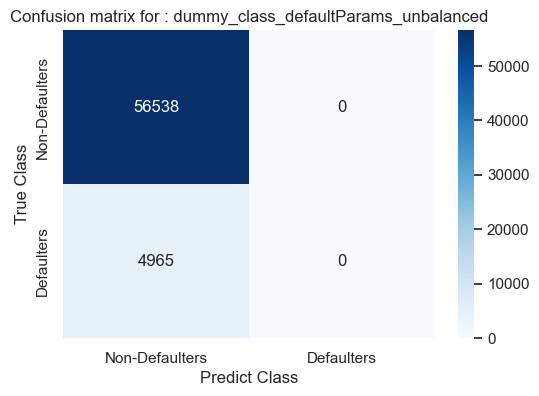

3:1: E122 continuation line missing indentation or outdented


In [28]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(DC,
                                X_train, X_val,
                                y_train, y_val,
                                df_results,
                                'dummy_class_defaultParams_unbalanced')

In [29]:
log_mlflow_balance(experiment.experiment_id, tags,
                   DC, "dummy_class_defaultParams_unbalanced",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

2023/08/09 13:33:23 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



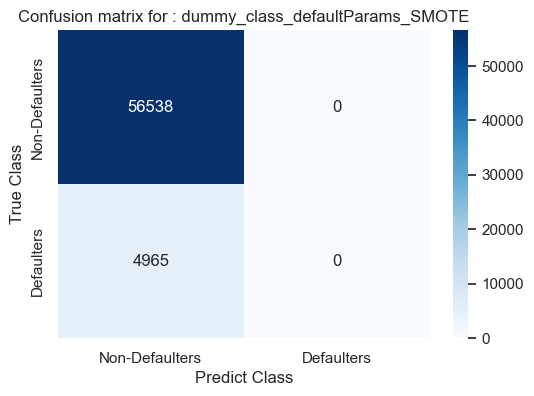

3:1: E122 continuation line missing indentation or outdented


In [30]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
    balance_method_analysis(DC,
                            X_train_SMOTE, X_val,
                            y_train_SMOTE, y_val,
                            df_results,
                            'dummy_class_defaultParams_SMOTE')

In [31]:
log_mlflow_balance(experiment.experiment_id, tags,
                   DC, "dummy_class_defaultParams_SMOTE",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

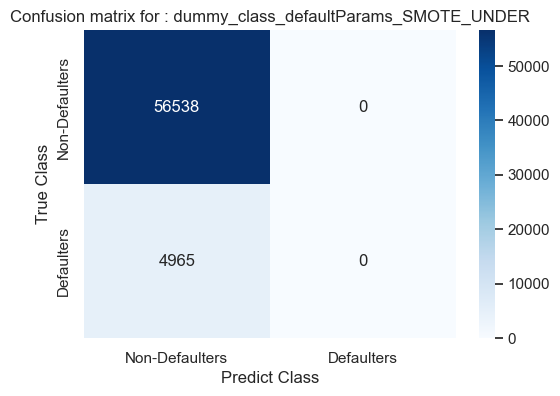

4:1: E122 continuation line missing indentation or outdented


In [32]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
    balance_method_analysis(DC,
                            X_train_SMOTE_UNDER, X_val,
                            y_train_SMOTE_UNDER, y_val,
                            df_results,
                            'dummy_class_defaultParams_SMOTE_UNDER')

In [33]:
log_mlflow_balance(experiment.experiment_id, tags,
                   DC, "dummy_class_defaultParams_SMOTE_UNDER",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

<a id='rebalancing_LogisticRegression'></a>

### <span style='background:#0075bc'><span style='color:white'>Logistic regression</span></span>

In [34]:
# Without data balance
LR = LogisticRegression(random_state=seed)

# Using class_weight
LR_cw = LogisticRegression(class_weight='balanced', random_state=seed)

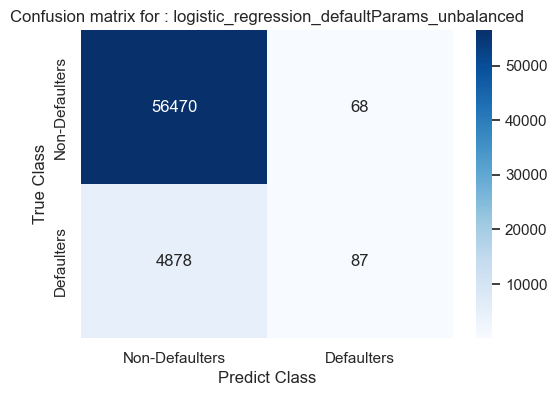

3:1: E122 continuation line missing indentation or outdented


In [35]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LR,
                                X_train, X_val, y_train, y_val,
                                df_results,
                                'logistic_regression_defaultParams_unbalanced')

In [36]:
log_mlflow_balance(experiment.experiment_id, tags,
                   LR, "logistic_regression_defaultParams_unbalanced",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

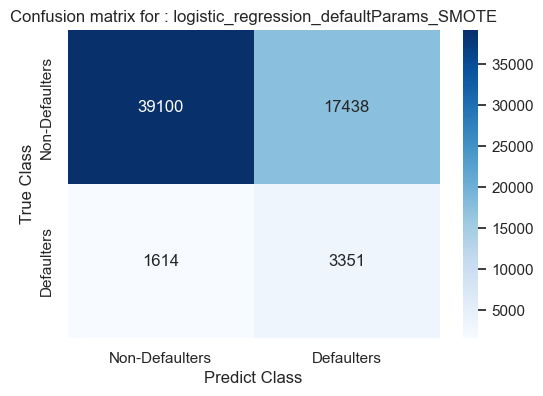

3:1: E122 continuation line missing indentation or outdented


In [37]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LR,
                                X_train_SMOTE, X_val,
                                y_train_SMOTE, y_val,
                                df_results,
                                'logistic_regression_defaultParams_SMOTE')

In [38]:
log_mlflow_balance(experiment.experiment_id, tags,
                   LR, "logistic_regression_defaultParams_SMOTE",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

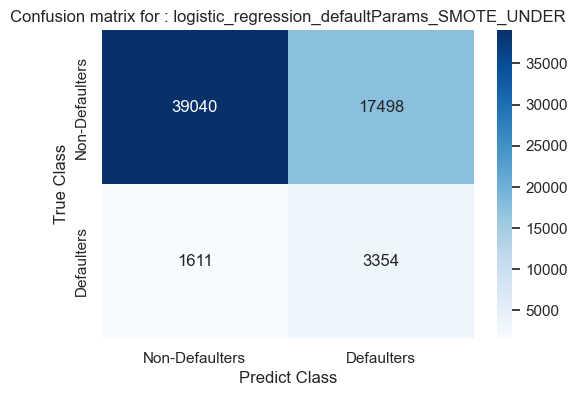

4:1: E122 continuation line missing indentation or outdented
11:80: E501 line too long (80 > 79 characters)


In [39]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LR,
                                X_train_SMOTE_UNDER,
                                X_val,
                                y_train_SMOTE_UNDER,
                                y_val,
                                df_results,
                                'logistic_regression_defaultParams_SMOTE_UNDER')

In [40]:
log_mlflow_balance(experiment.experiment_id, tags,
                   LR, "logistic_regression_defaultParams_SMOTE_UNDER",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

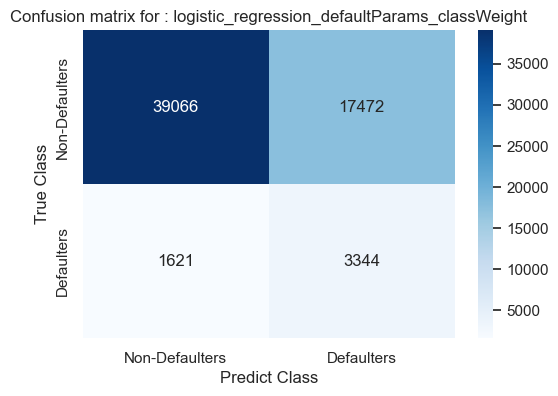

3:1: E122 continuation line missing indentation or outdented
8:29: E128 continuation line under-indented for visual indent


In [41]:
# Default model hyperparameters and data balanced using class_weight
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LR_cw,
                                X_train, X_val,
                                y_train, y_val,
                                df_results,
                            'logistic_regression_defaultParams_classWeight')

In [42]:
log_mlflow_balance(experiment.experiment_id, tags,
                   LR_cw, "logistic_regression_defaultParams_classWeight",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

<a id='rebalancing_RandomForest'></a>

### <span style='background:#0075bc'><span style='color:white'>Random Forest</span></span>

In [43]:
# Without data balance
randomForest = RandomForestClassifier(random_state=seed)

# Using class_weight
randomForest_cw = RandomForestClassifier(class_weight='balanced',
                                         random_state=seed)

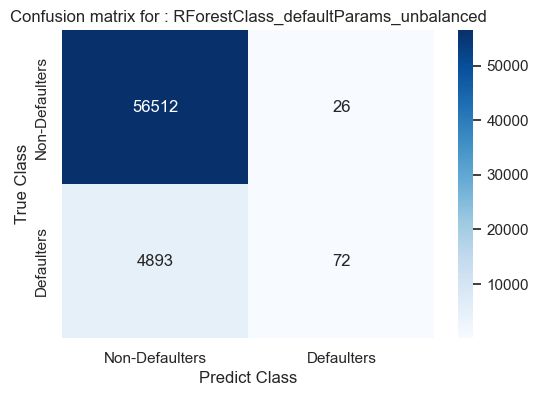

3:1: E122 continuation line missing indentation or outdented


In [44]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(randomForest,
                                X_train, X_val, y_train, y_val,
                                df_results,
                                'RForestClass_defaultParams_unbalanced')

In [45]:
log_mlflow_balance(experiment.experiment_id, tags,
                   randomForest, "RForestClass_defaultParams_unbalanced",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

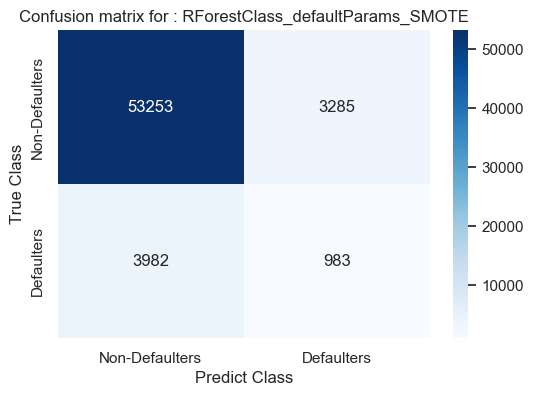

3:1: E122 continuation line missing indentation or outdented


In [46]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(randomForest,
                                X_train_SMOTE, X_val,
                                y_train_SMOTE, y_val,
                                df_results,
                                'RForestClass_defaultParams_SMOTE')

In [47]:
log_mlflow_balance(experiment.experiment_id, tags,
                   randomForest, "RForestClass_defaultParams_SMOTE",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

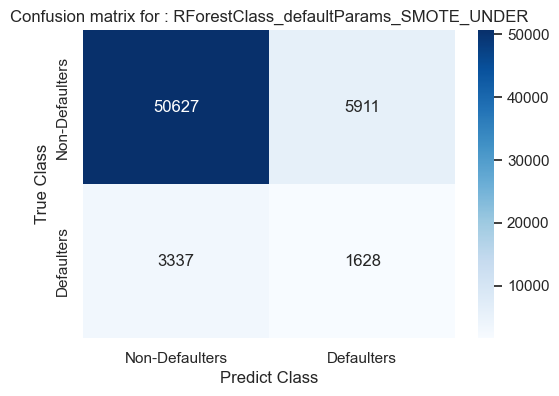

4:1: E122 continuation line missing indentation or outdented


In [48]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(randomForest,
                                X_train_SMOTE_UNDER,
                                X_val,
                                y_train_SMOTE_UNDER,
                                y_val,
                                df_results,
                                'RForestClass_defaultParams_SMOTE_UNDER')

In [49]:
log_mlflow_balance(experiment.experiment_id, tags,
                   randomForest, "RForestClass_defaultParams_SMOTE_UNDER",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

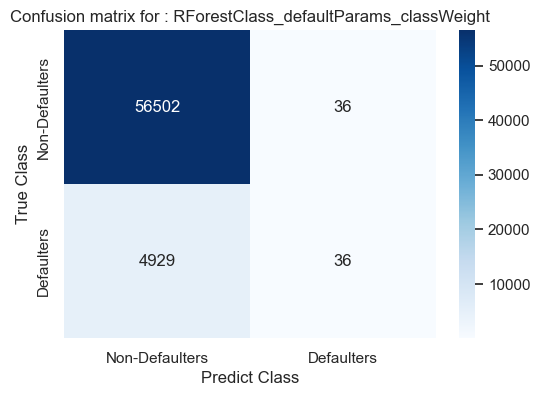

3:1: E122 continuation line missing indentation or outdented


In [50]:
# Default model hyperparameters and data balanced using class_weight
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(randomForest_cw,
                                X_train, X_val,
                                y_train, y_val,
                                df_results,
                                'RForestClass_defaultParams_classWeight')

In [51]:
log_mlflow_balance(experiment.experiment_id, tags,
                   randomForest_cw, "RForestClass_defaultParams_classWeight",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

<a id='rebalancing_XGBoost'></a>

### <span style='background:#0075bc'><span style='color:white'>XG Boost</span></span>

In [52]:
# Without data balance
XGBClass = xgb.XGBClassifier(random_state = seed)

# Using class_weight
XGBClass_cw = xgb.XGBClassifier(scale_pos_weight=pos_weight,
                                class_weight=class_weights,
                                random_state=seed)

2:42: E251 unexpected spaces around keyword / parameter equals
2:44: E251 unexpected spaces around keyword / parameter equals


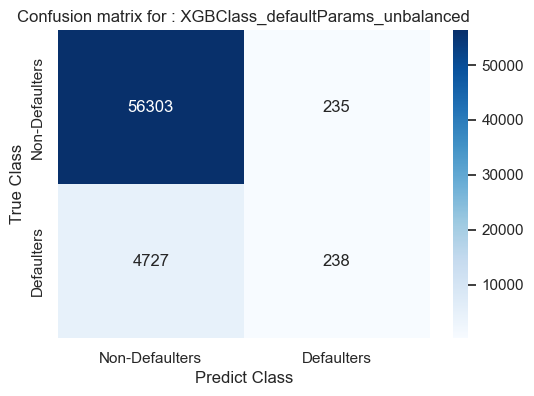

3:1: E122 continuation line missing indentation or outdented


In [53]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(XGBClass,
                                X_train, X_val, y_train, y_val,
                                df_results,
                                'XGBClass_defaultParams_unbalanced')

In [54]:
log_mlflow_balance(experiment.experiment_id, tags,
                   XGBClass, "XGBClass_defaultParams_unbalanced",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

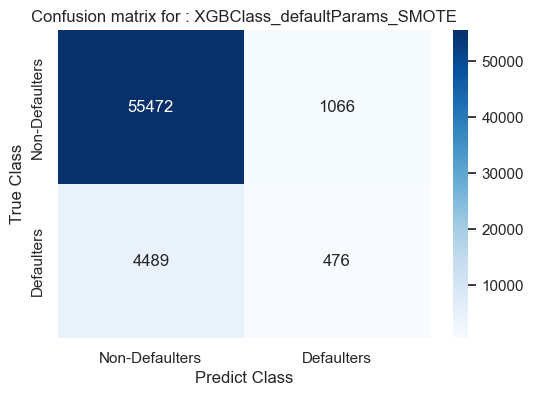

3:1: E122 continuation line missing indentation or outdented


In [55]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(XGBClass,
                                X_train_SMOTE, X_val,
                                y_train_SMOTE, y_val,
                                df_results,
                                'XGBClass_defaultParams_SMOTE')

In [56]:
log_mlflow_balance(experiment.experiment_id, tags,
                   XGBClass, "XGBClass_defaultParams_SMOTE",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

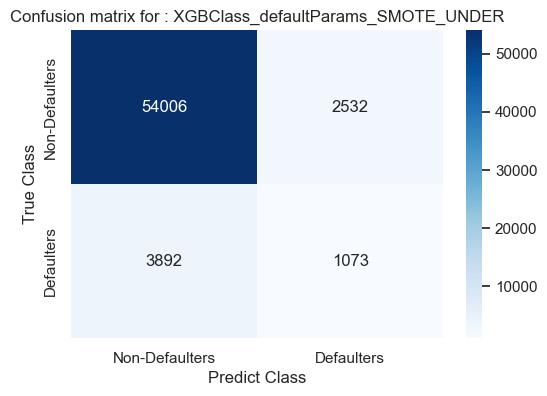

4:1: E122 continuation line missing indentation or outdented


In [57]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(XGBClass,
                                X_train_SMOTE_UNDER,
                                X_val,
                                y_train_SMOTE_UNDER,
                                y_val,
                                df_results,
                                'XGBClass_defaultParams_SMOTE_UNDER')

In [58]:
log_mlflow_balance(experiment.experiment_id, tags,
                   XGBClass, "XGBClass_defaultParams_SMOTE_UNDER",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

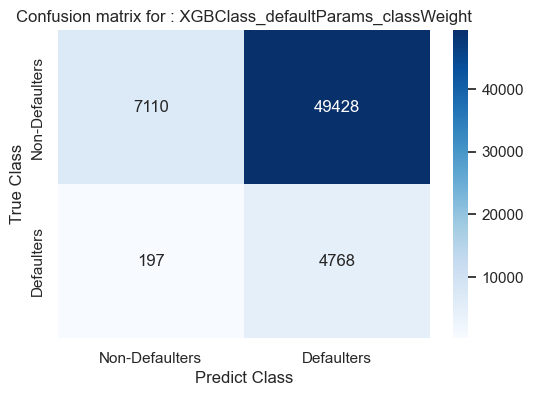

3:1: E122 continuation line missing indentation or outdented


In [59]:
# Default model hyperparameters and data balanced using class_weight
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
    balance_method_analysis(XGBClass_cw,
                            X_train, X_val, y_train, y_val,
                            df_results,
                            'XGBClass_defaultParams_classWeight')

In [60]:
log_mlflow_balance(experiment.experiment_id, tags,
                   XGBClass_cw, "XGBClass_defaultParams_classWeight",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

<a id='rebalancing_LightGBM'></a>

### <span style='background:#0075bc'><span style='color:white'>LightGBM</span></span>

In [61]:
# Without data balance
LGBM = ltb.LGBMClassifier(random_state=seed, verbose=-100)

# Using class_weight
LGBM_cw = ltb.LGBMClassifier(class_weight='balanced',
                             random_state=seed,
                             verbose=-100)

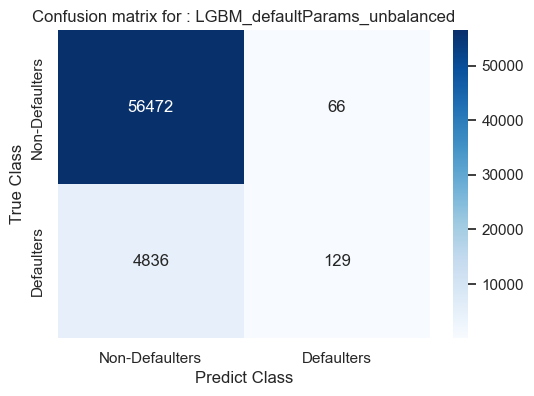

3:1: E122 continuation line missing indentation or outdented


In [62]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LGBM,
                                X_train, X_val, y_train, y_val,
                                df_results,
                                'LGBM_defaultParams_unbalanced')

In [63]:
log_mlflow_balance(experiment.experiment_id, tags,
                   LGBM, "LGBM_defaultParams_unbalanced",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

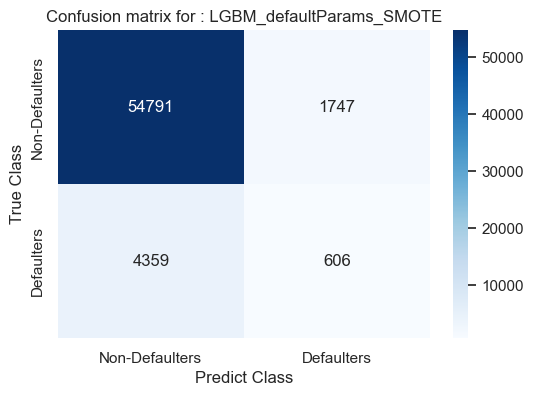

3:1: E122 continuation line missing indentation or outdented


In [64]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LGBM,
                                X_train_SMOTE, X_val,
                                y_train_SMOTE, y_val,
                                df_results,
                                'LGBM_defaultParams_SMOTE')

In [65]:
log_mlflow_balance(experiment.experiment_id, tags,
                   LGBM, "LGBM_defaultParams_SMOTE",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

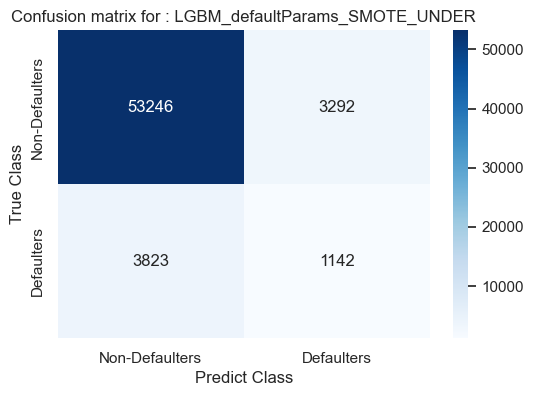

4:1: E122 continuation line missing indentation or outdented


In [66]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LGBM,
                                X_train_SMOTE_UNDER,
                                X_val,
                                y_train_SMOTE_UNDER,
                                y_val,
                                df_results,
                                'LGBM_defaultParams_SMOTE_UNDER')

In [67]:
log_mlflow_balance(experiment.experiment_id, tags,
                   LGBM, "LGBM_defaultParams_SMOTE_UNDER",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

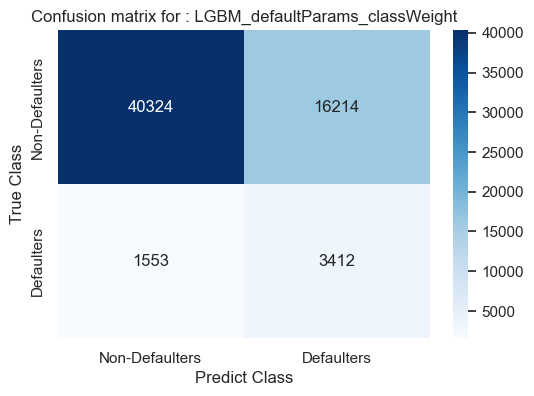

3:1: E122 continuation line missing indentation or outdented


In [68]:
# Default model hyperparameters and data balanced using class_weight
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, \
f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LGBM_cw,
                                X_train,
                                X_val,
                                y_train,
                                y_val,
                                df_results,
                                'LGBM_defaultParams_classWeight')

In [69]:
log_mlflow_balance(experiment.experiment_id, tags,
                   LGBM_cw, "LGBM_defaultParams_classWeight",
                   Business_Metric=business_metric,
                   Recall=recall,
                   Precision=precision,
                   Accuracy=accuracy,
                   F1_score=f1_score, F2_score=f2_score,
                   F5_score=f5_score, F10_score=f10_score,
                   Roc_auc=roc_auc,
                   AP_score=ap_score,
                   TN=tn, FP=fp, FN=fn, TP=tp)

In [70]:
mlflow.end_run()

<a id='rebalancing_model_tests_summary'></a>

## <span style='background:#0085dd'><span style='color:white'>Summary</span></span>

In [71]:
# True numbers of defaulers and non-defaulters
y_val_counter

Counter({0: 56538, 1: 4965})

* Number of defaulters 4965 (TP)
* Number of non-defaulters 56538 (TN)

In [72]:
# Define the folder containing the files with the project data
P7_scoring_credit = "/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/"

os.chdir(P7_scoring_credit)

2:80: E501 line too long (102 > 79 characters)


In [73]:
# Load de table
file_df_result_score = 'model_tests/df_results_scores.pkl'
with open(file_df_result_score, 'rb') as f:
    df_results = pickle.load(f)

In [74]:
df_results.columns

Index(['Experience', 'Business_score', 'Recall', 'Precision', 'Accuracy', 'F1',
       'F2', 'F5', 'F10', 'ROC_AUC', 'AP_SCORE', 'Train runtime',
       'Train+Validatin runtime', 'TN', 'FP', 'FN', 'TP', 'Train_auc_CV',
       'Train_auc_CV +/-', 'Test_auc_CV', 'Test_auc_CV +/-',
       'Train_roc_auc_CV', 'Train_roc_auc_CV +/-', 'Test_roc_auc_CV',
       'Test_roc_auc_CV +/-', 'Train_recall_CV', 'Train_recall_CV +/-',
       'Test_recall_CV', 'Test_recall_CV +/-', 'Train_precision_CV',
       'Train_precision_CV +/-', 'Test_precision_CV', 'Test_precision_CV +/-'],
      dtype='object')

In [75]:
df_results.sort_values(by='Business_score', ascending=False).head(15)

Experience  Business_score    Recall  \
0             XGBClass_defaultParams_SMOTE_UNDER        0.714499  0.216113   
0         RForestClass_defaultParams_SMOTE_UNDER        0.710605  0.327895   
0                 LGBM_defaultParams_SMOTE_UNDER        0.709961  0.230010   
0                 LGBM_defaultParams_classWeight        0.704749  0.687210   
0               RForestClass_defaultParams_SMOTE        0.699614  0.197986   
0                       LGBM_defaultParams_SMOTE        0.693227  0.122054   
0                   XGBClass_defaultParams_SMOTE        0.692822  0.095871   
0              XGBClass_defaultParams_unbalanced        0.687121  0.047936   
0        logistic_regression_defaultParams_SMOTE        0.686149  0.674924   
0  logistic_regression_defaultParams_SMOTE_UNDER        0.685630  0.675529   
0  logistic_regression_defaultParams_classWeight        0.685284  0.673515   
0                  LGBM_defaultParams_unbalanced        0.681987  0.025982   
0   logistic_regression_defaultParams_unbalanced        0.679208  0.017523   
0          RForestClass_defaultParams_unbalanced        0.678725  0.014502   
0         RForestClass_defaultParams_classWeight        0.676244  0.007251   

   Precision  Accuracy        F1        F2        F5       F10   ROC_AUC  ...  \
0   0.297642  0.895550  0.250408  0.228638  0.218414  0.216700  0.742379  ...   
0   0.215944  0.849633  0.260397  0.297091  0.321485  0.326221  0.732343  ...   
0   0.257555  0.884315  0.243005  0.235037  0.230960  0.230254  0.736310  ...   
0   0.173851  0.711120  0.277500  0.432052  0.617123  0.667690  0.771333  ...   
0   0.230319  0.881843  0.212932  0.203705  0.199061  0.198261  0.719126  ...   
0   0.257544  0.900720  0.165619  0.136407  0.124575  0.122693  0.715187  ...   
0   0.308690  0.909679  0.146304  0.111205  0.098482  0.096530  0.722017  ...   
0   0.503171  0.919321  0.087532  0.058526  0.049664  0.048369  0.766086  ...   
0   0.161191  0.690226  0.260231  0.412187  0.601226  0.654278  0.743780  ...   
0   0.160848  0.689300  0.259829  0.411918  0.601502  0.654784  0.744205  ...   
0   0.160646  0.689560  0.259416  0.411053  0.599858  0.652878  0.744971  ...   
0   0.661538  0.920297  0.050000  0.032162  0.026979  0.026231  0.771174  ...   
0   0.561290  0.919581  0.033984  0.021734  0.018201  0.017692  0.742650  ...   
0   0.734694  0.920020  0.028442  0.018038  0.015070  0.014644  0.729247  ...   
0   0.500000  0.919272  0.014294  0.009031  0.007536  0.007322  0.737595  ...   

   Test_roc_auc_CV Test_roc_auc_CV +/- Train_recall_CV  Train_recall_CV +/-  \
0         0.953004            0.091459        0.871176             0.021870   
0         0.961629            0.033709        1.000000             0.000000   
0         0.946564            0.094758        0.846396             0.022961   
0         0.773566            0.002878        0.746335             0.001299   
0         0.985325            0.019251        1.000000             0.000000   
0         0.967020            0.086192        0.897297             0.022997   
0         0.969257            0.089992        0.918025             0.024214   
0         0.769376            0.003847        0.099944             0.002983   
0         0.752541            0.003581        0.681332             0.000492   
0         0.751656            0.005854        0.680228             0.000850   
0         0.742844            0.001874        0.667847             0.000970   
0         0.772142            0.003338        0.036092             0.001528   
0         0.740457            0.001946        0.015318             0.000335   
0         0.730004            0.005385        0.999564             0.000130   
0         0.738043            0.003703        0.999592             0.000097   

   Test_recall_CV  Test_recall_CV +/-  Train_precision_CV  \
0        0.837437            0.311611            0.964714   
0        0.897004            0.109408            1.000000   
0        0.823995            0.298384       

In [76]:
df_results.sort_values(by='F2', ascending=False).head(15)

Experience  Business_score    Recall  \
0                 LGBM_defaultParams_classWeight        0.704749  0.687210   
0        logistic_regression_defaultParams_SMOTE        0.686149  0.674924   
0  logistic_regression_defaultParams_SMOTE_UNDER        0.685630  0.675529   
0  logistic_regression_defaultParams_classWeight        0.685284  0.673515   
0             XGBClass_defaultParams_classWeight        0.397565  0.960322   
0         RForestClass_defaultParams_SMOTE_UNDER        0.710605  0.327895   
0                 LGBM_defaultParams_SMOTE_UNDER        0.709961  0.230010   
0             XGBClass_defaultParams_SMOTE_UNDER        0.714499  0.216113   
0               RForestClass_defaultParams_SMOTE        0.699614  0.197986   
0                       LGBM_defaultParams_SMOTE        0.693227  0.122054   
0                   XGBClass_defaultParams_SMOTE        0.692822  0.095871   
0              XGBClass_defaultParams_unbalanced        0.687121  0.047936   
0                  LGBM_defaultParams_unbalanced        0.681987  0.025982   
0   logistic_regression_defaultParams_unbalanced        0.679208  0.017523   
0          RForestClass_defaultParams_unbalanced        0.678725  0.014502   

   Precision  Accuracy        F1        F2        F5       F10   ROC_AUC  ...  \
0   0.173851  0.711120  0.277500  0.432052  0.617123  0.667690  0.771333  ...   
0   0.161191  0.690226  0.260231  0.412187  0.601226  0.654278  0.743780  ...   
0   0.160848  0.689300  0.259829  0.411918  0.601502  0.654784  0.744205  ...   
0   0.160646  0.689560  0.259416  0.411053  0.599858  0.652878  0.744971  ...   
0   0.087977  0.193129  0.161187  0.321919  0.695196  0.874472  0.725056  ...   
0   0.215944  0.849633  0.260397  0.297091  0.321485  0.326221  0.732343  ...   
0   0.257555  0.884315  0.243005  0.235037  0.230960  0.230254  0.736310  ...   
0   0.297642  0.895550  0.250408  0.228638  0.218414  0.216700  0.742379  ...   
0   0.230319  0.881843  0.212932  0.203705  0.199061  0.198261  0.719126  ...   
0   0.257544  0.900720  0.165619  0.136407  0.124575  0.122693  0.715187  ...   
0   0.308690  0.909679  0.146304  0.111205  0.098482  0.096530  0.722017  ...   
0   0.503171  0.919321  0.087532  0.058526  0.049664  0.048369  0.766086  ...   
0   0.661538  0.920297  0.050000  0.032162  0.026979  0.026231  0.771174  ...   
0   0.561290  0.919581  0.033984  0.021734  0.018201  0.017692  0.742650  ...   
0   0.734694  0.920020  0.028442  0.018038  0.015070  0.014644  0.729247  ...   

   Test_roc_auc_CV Test_roc_auc_CV +/- Train_recall_CV  Train_recall_CV +/-  \
0         0.773566            0.002878        0.746335             0.001299   
0         0.752541            0.003581        0.681332             0.000492   
0         0.751656            0.005854        0.680228             0.000850   
0         0.742844            0.001874        0.667847             0.000970   
0         0.718504            0.005778        1.000000             0.000000   
0         0.961629            0.033709        1.000000             0.000000   
0         0.946564            0.094758        0.846396             0.022961   
0         0.953004            0.091459        0.871176             0.021870   
0         0.985325            0.019251        1.000000             0.000000   
0         0.967020            0.086192        0.897297             0.022997   
0         0.969257            0.089992        0.918025             0.024214   
0         0.769376            0.003847        0.099944             0.002983   
0         0.772142            0.003338        0.036092             0.001528   
0         0.740457            0.001946        0.015318             0.000335   
0         0.730004            0.005385        0.999564             0.000130   

   Test_recall_CV  Test_recall_CV +/-  Train_precision_CV  \
0        0.689678            0.008797            0.190817   
0        0.681337            0.005106            0.688275   
0        0.680103            0.006369       

In [77]:
df_results.sort_values(by='ROC_AUC', ascending=False).head(15)

Experience  Business_score    Recall  \
0                 LGBM_defaultParams_classWeight        0.704749  0.687210   
0                  LGBM_defaultParams_unbalanced        0.681987  0.025982   
0              XGBClass_defaultParams_unbalanced        0.687121  0.047936   
0  logistic_regression_defaultParams_classWeight        0.685284  0.673515   
0  logistic_regression_defaultParams_SMOTE_UNDER        0.685630  0.675529   
0        logistic_regression_defaultParams_SMOTE        0.686149  0.674924   
0   logistic_regression_defaultParams_unbalanced        0.679208  0.017523   
0             XGBClass_defaultParams_SMOTE_UNDER        0.714499  0.216113   
0         RForestClass_defaultParams_classWeight        0.676244  0.007251   
0                 LGBM_defaultParams_SMOTE_UNDER        0.709961  0.230010   
0         RForestClass_defaultParams_SMOTE_UNDER        0.710605  0.327895   
0          RForestClass_defaultParams_unbalanced        0.678725  0.014502   
0             XGBClass_defaultParams_classWeight        0.397565  0.960322   
0                   XGBClass_defaultParams_SMOTE        0.692822  0.095871   
0               RForestClass_defaultParams_SMOTE        0.699614  0.197986   

   Precision  Accuracy        F1        F2        F5       F10   ROC_AUC  ...  \
0   0.173851  0.711120  0.277500  0.432052  0.617123  0.667690  0.771333  ...   
0   0.661538  0.920297  0.050000  0.032162  0.026979  0.026231  0.771174  ...   
0   0.503171  0.919321  0.087532  0.058526  0.049664  0.048369  0.766086  ...   
0   0.160646  0.689560  0.259416  0.411053  0.599858  0.652878  0.744971  ...   
0   0.160848  0.689300  0.259829  0.411918  0.601502  0.654784  0.744205  ...   
0   0.161191  0.690226  0.260231  0.412187  0.601226  0.654278  0.743780  ...   
0   0.561290  0.919581  0.033984  0.021734  0.018201  0.017692  0.742650  ...   
0   0.297642  0.895550  0.250408  0.228638  0.218414  0.216700  0.742379  ...   
0   0.500000  0.919272  0.014294  0.009031  0.007536  0.007322  0.737595  ...   
0   0.257555  0.884315  0.243005  0.235037  0.230960  0.230254  0.736310  ...   
0   0.215944  0.849633  0.260397  0.297091  0.321485  0.326221  0.732343  ...   
0   0.734694  0.920020  0.028442  0.018038  0.015070  0.014644  0.729247  ...   
0   0.087977  0.193129  0.161187  0.321919  0.695196  0.874472  0.725056  ...   
0   0.308690  0.909679  0.146304  0.111205  0.098482  0.096530  0.722017  ...   
0   0.230319  0.881843  0.212932  0.203705  0.199061  0.198261  0.719126  ...   

   Test_roc_auc_CV Test_roc_auc_CV +/- Train_recall_CV  Train_recall_CV +/-  \
0         0.773566            0.002878        0.746335             0.001299   
0         0.772142            0.003338        0.036092             0.001528   
0         0.769376            0.003847        0.099944             0.002983   
0         0.742844            0.001874        0.667847             0.000970   
0         0.751656            0.005854        0.680228             0.000850   
0         0.752541            0.003581        0.681332             0.000492   
0         0.740457            0.001946        0.015318             0.000335   
0         0.953004            0.091459        0.871176             0.021870   
0         0.738043            0.003703        0.999592             0.000097   
0         0.946564            0.094758        0.846396             0.022961   
0         0.961629            0.033709        1.000000             0.000000   
0         0.730004            0.005385        0.999564             0.000130   
0         0.718504            0.005778        1.000000             0.000000   
0         0.969257            0.089992        0.918025             0.024214   
0         0.985325            0.019251        1.000000             0.000000   

   Test_recall_CV  Test_recall_CV +/-  Train_precision_CV  \
0        0.689678            0.008797            0.190817   
0        0.025478            0.002894            0.764440   
0        0.044209            0.003421       

**Metrics summary**

In [78]:
df_results = df_results.sort_values(by='ROC_AUC', ascending=False)
experiences_list = list(df_results['Experience'])

In [79]:
experiences_list[0:5]

['LGBM_defaultParams_classWeight',
 'LGBM_defaultParams_unbalanced',
 'XGBClass_defaultParams_unbalanced',
 'logistic_regression_defaultParams_classWeight',
 'logistic_regression_defaultParams_SMOTE_UNDER']

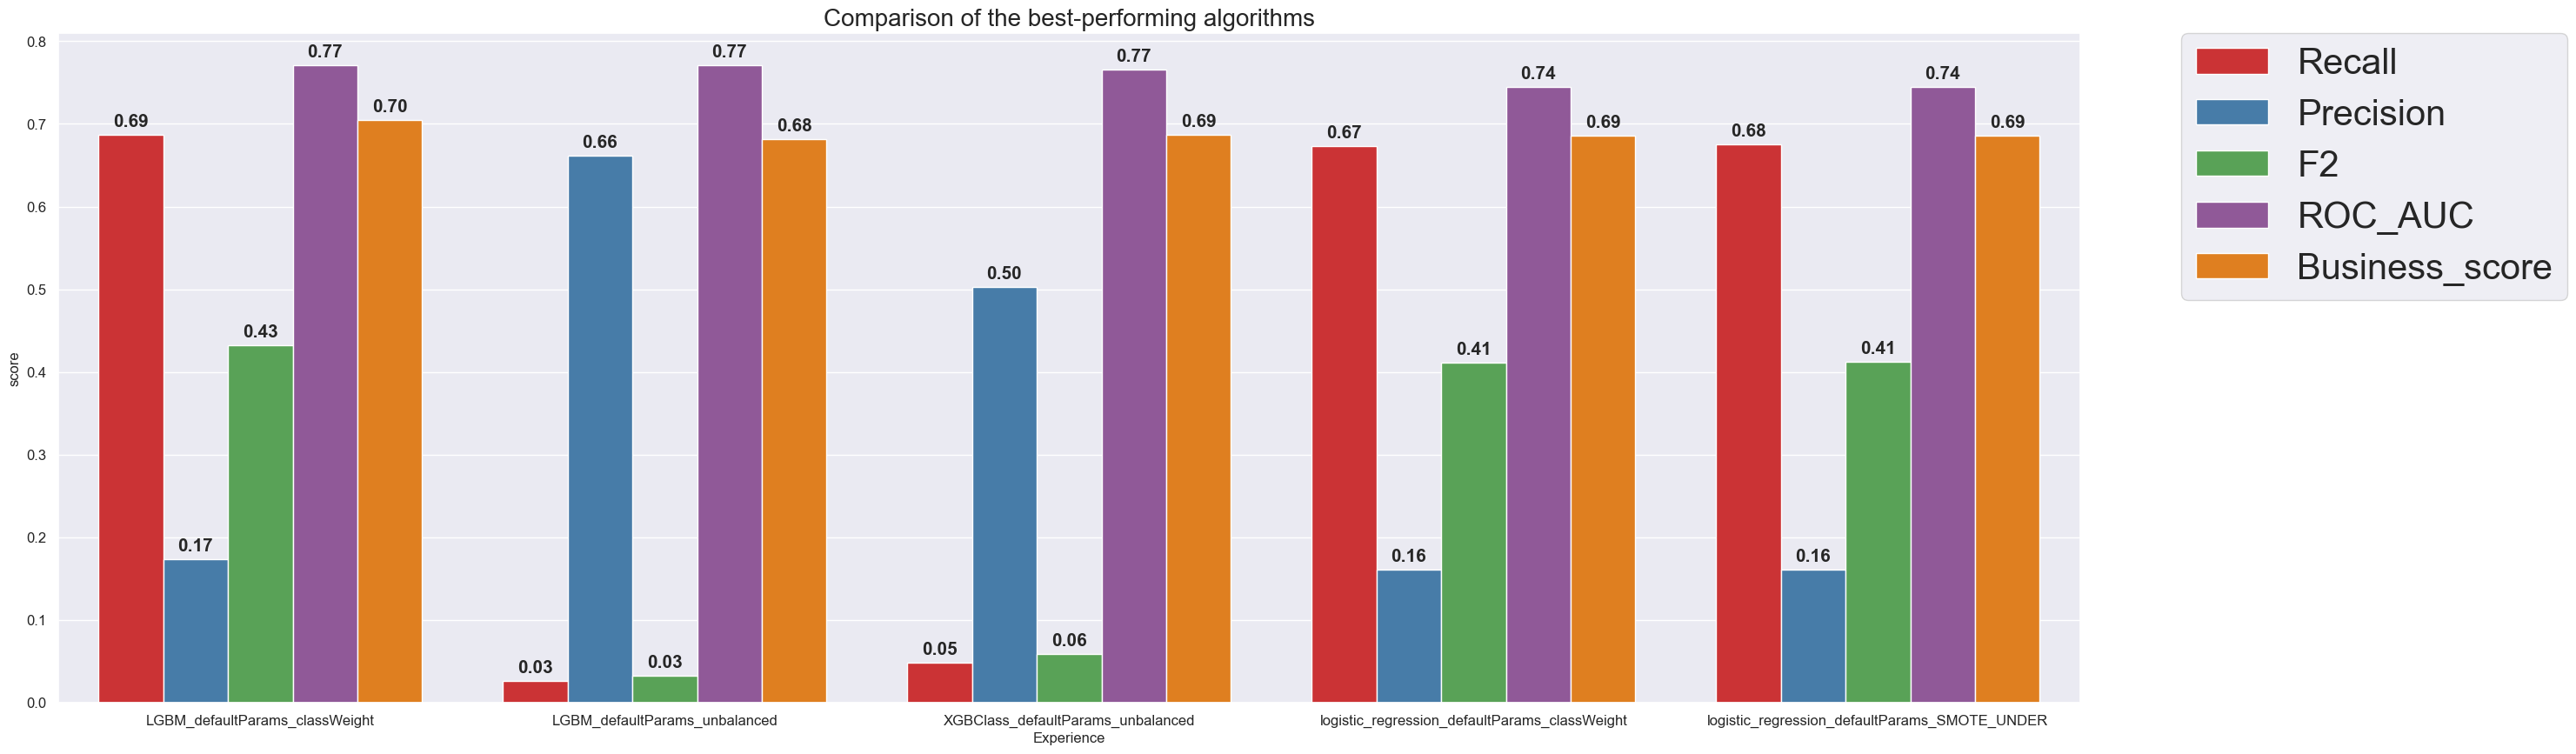

11:19: E251 unexpected spaces around keyword / parameter equals
11:21: E251 unexpected spaces around keyword / parameter equals
12:3: E225 missing whitespace around operator
27:31: W291 trailing whitespace


In [80]:
# Visual comparison of the 5 best-performing algorithms
df_comp_results = df_results[df_results['Experience']
                             .isin(experiences_list[0:5])]

# Scores
comparaison_score_melt = \
    pd.melt(df_comp_results, id_vars=['Experience'], value_name='score',
            value_vars=['Recall', 'Precision', 'F2',
                        'ROC_AUC', 'Business_score'])
# Visualization
plt.figure(figsize = (30, 10))
ax= sns.barplot(x=comparaison_score_melt['Experience'],
                y=comparaison_score_melt['score'],
                hue=comparaison_score_melt['variable'])
plt.title('Comparison of the best-performing algorithms',
          fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=15,
            fontweight='bold') 
plt.show()

df_comp_results[['Experience', 'Train runtime', 'Recall', 'Precision',
                 'F5', 'ROC_AUC',
                 'Business_score']].style.hide(axis="index")

Among all the tests carried out, the best results are obtained using :
 * **SMOTE combined with RandomUnderSampler**
 * **class_weight**
 
The differences in the results obtained with one or the other method are not significant. 
In the next stage, hyperparameter tunning for performance optimization, tests will be carried out with both methods.

<a id='model_selection'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Model selection** </span></span>


<a id='hyperparameter_optimization'></a>

## <span style='background:#0085dd'><span style='color:white'>Hyperparameter optimization</span></span>

In [81]:
server_uri = 'http://127.0.0.1:5000'

In [82]:
# Create MLFlow experiment

experiment_name = 'hyperparam_tunnig'
try:
    experiment_id = mlflow.create_experiment(
        name=experiment_name,
        artifact_location=Path.cwd().joinpath("mlruns").as_uri())
    mlflow.set_experiment(experiment_name)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

tags = {"version": "v4",
        "others": "25 best values from LightGBM and RandomForest, A-Z run"}
mlflow_hyp_opt = mlflow.get_experiment(exp_id)
print("Name: {}".format(mlflow_hyp_opt.name))
print("Experiment_id: {}".format(mlflow_hyp_opt.experiment_id))
print("Artifact Location: {}".format(mlflow_hyp_opt.artifact_location))
print("Tags: {}".format(tags))
print("Lifecycle_stage: {}".format(mlflow_hyp_opt.lifecycle_stage))
print("Creation timestamp: {}".format(mlflow_hyp_opt.creation_time))

To optimise and evaluate the models :
 * First there is a search for the **optimal hyperparameters via cross-validation** (search_best_model).
 * To better understand the relationship between the **hyperparameters** of the alogrithms and the **scorers**, a **graphical representation** is made (plot_best_param_scores).
 * To facilitate the **comparison between** the best results of the **models**, a **table** is created to store the data (add_model_score).
 * **Fit** the algorithm using the best_params on the train data and make the prediction using **predict_proba** (train_best_params).
 * A new function is used to identify the **probability threshold** that optimises the scorers (prob_threshold).
 * Several **synthesis graphs** are generated to facilitate the evaluation of the model performance.


In [83]:
# Create a table for recording models scores
# Columns definition
metrics_columns = list(df_temp.columns)
metrics_columns.remove('Experience')
cols = ['Experience', 'params', 'train_time',
        'gridsearch_time'] + metrics_columns

df_scores_models = pd.DataFrame(columns=cols)
df_scores_models

Empty DataFrame
Columns: [Experience, params, train_time, gridsearch_time, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, business_metric, tn, fp, fn, tp, roc_auc, ap_score]
Index: []

<a id='optimization_dummy'></a>

### <span style='background:#0075bc'><span style='color:white'>Baseline : Dummy Classifier</span></span>

In [84]:
DC = DummyClassifier(strategy='most_frequent', random_state=seed)

Experience = 'Baseline (Dummy)'
param_grid = {}
dummy_pipeline = imbpipeline.Pipeline(steps=[('clf', DC)])

dummy_pipeline

Pipeline(steps=[('clf',
                 DummyClassifier(random_state=84, strategy='most_frequent'))])

invalid value encountered in scalar divide
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


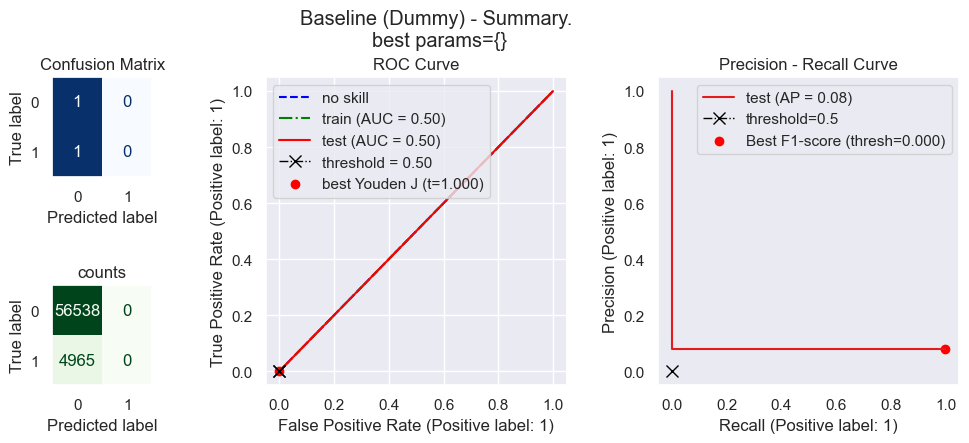

In [85]:
evaluate_model(Experience, dummy_pipeline,
               X_train, y_train,
               X_val, y_val)

In [86]:
dummy_opt = df_scores_models. loc[df_scores_models["Experience"] == "Baseline (Dummy)"]
dummy_opt

Experience params  train_time  gridsearch_time  recall  precision  \
0  Baseline (Dummy)     {}         0.0            0.199     0.0        0.0   

   accuracy  f1_score  f2_score  f5_score  ...  std_train_roc_auc  \
0     0.919       0.0       0.0       0.0  ...                0.0   

   mean_test_business_metric std_test_business_metric  \
0                   0.674308                 0.000002   

  mean_train_business_metric std_train_business_metric mean_test_f2_score  \
0                   0.674308              5.946865e-07                0.0   

   std_test_f2_score  mean_train_f2_score std_train_f2_score  \
0                0.0                  0.0                0.0   

   discrimination_threshold  
0                       0.5  

[1 rows x 38 columns]

1:80: E501 line too long (87 > 79 characters)


In [87]:
log_mlflow_hyperparam(mlflow_hyp_opt.experiment_id, tags,
                      dummy_pipeline, "dummy_class_opti_unbalanced",
                      Business_Metric=dummy_opt.business_metric,
                      Recall=dummy_opt.recall,
                      Precision=dummy_opt.precision,
                      Accuracy=dummy_opt.accuracy,
                      F1_score=dummy_opt.f1_score, F2_score=dummy_opt.f2_score,
                      F5_score=dummy_opt.f5_score, F10_score=dummy_opt.f10_score,
                      Roc_auc=dummy_opt.roc_auc,
                      AP_score=dummy_opt.ap_score,
                      TN= dummy_opt.tn, FP=dummy_opt.fp,
                      FN=dummy_opt.fn, TP=dummy_opt.tp,
                      params=(dummy_opt.params)[0])

8:80: E501 line too long (81 > 79 characters)
11:26: E251 unexpected spaces around keyword / parameter equals


<a id='optimization_LogisticRegression'></a>

### <span style='background:#0075bc'><span style='color:white'>Logistic regression</span></span>

**Data balancing using SMOTE & RandomUnderSampling**

In [88]:
# X_train_SMOTE_UNDER, y_train_SMOTE_UNDER
# X_val, y_val

Experience = 'LogisticRegression_smoteUnder'
LR_pipeline = imbpipeline.Pipeline(steps=[
    ('clf', LogisticRegression(random_state=seed)),
])
param_grid = {
    'clf__penalty':['l1','l2', 'elasticnet'],
    'clf__solver':['liblinear']
}

LR_pipeline

Pipeline(steps=[('clf', LogisticRegression(random_state=84))])

ValueError: too many values to unpack (expected 3)


5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rzb\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rzb\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\rzb\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rzb\anaconda3\Lib\

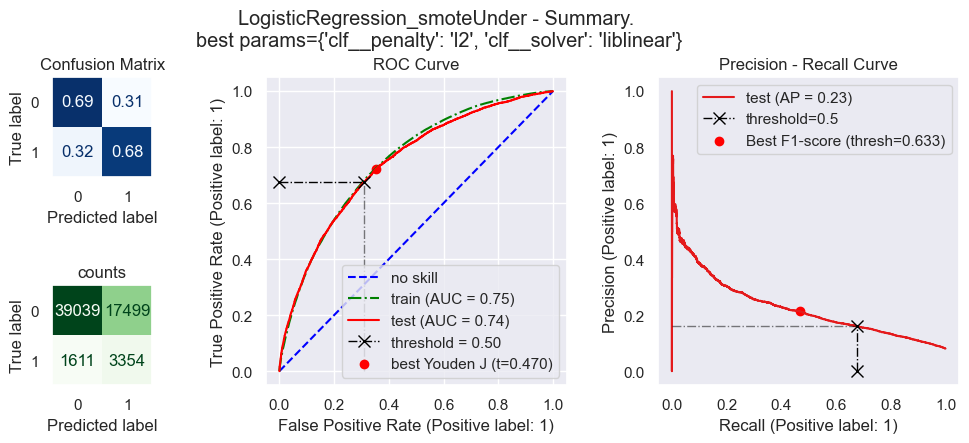

In [89]:
evaluate_model(Experience, LR_pipeline,
               X_train_SMOTE_UNDER, y_train_SMOTE_UNDER,
               X_val, y_val, param_grid)

In [90]:
LR_opt_SU = df_scores_models\
    .loc[df_scores_models["Experience"] == "LogisticRegression_smoteUnder"]
LR_opt_SU

Experience  \
0  LogisticRegression_smoteUnder   

                                              params  train_time  \
0  {'clf__penalty': 'l2', 'clf__solver': 'libline...        0.95   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
0            8.935   0.676      0.161     0.689      0.26     0.412     0.601   

   ...  std_train_roc_auc  mean_test_business_metric std_test_business_metric  \
0  ...           0.001224                   0.681552                  0.00477   

  mean_train_business_metric std_train_business_metric mean_test_f2_score  \
0                   0.681992                   0.00134           0.681349   

   std_test_f2_score  mean_train_f2_score std_train_f2_score  \
0           0.004864             0.681799           0.001365   

   discrimination_threshold  
0                       0.5  

[1 rows x 38 columns]

In [91]:
log_mlflow_hyperparam(mlflow_hyp_opt.experiment_id, tags,
                      LR_pipeline, "LogisticRegression_opti_smoteUnder",
                      Business_Metric=LR_opt_SU.business_metric,
                      Recall=LR_opt_SU.recall,
                      Precision=LR_opt_SU.precision,
                      Accuracy=LR_opt_SU.accuracy,
                      F1_score=LR_opt_SU.f1_score, F2_score=LR_opt_SU.f2_score,
                      F5_score=LR_opt_SU.f5_score, F10_score=LR_opt_SU.f10_score,
                      Roc_auc=LR_opt_SU.roc_auc,
                      AP_score=LR_opt_SU.ap_score,
                      TN=LR_opt_SU.tn, FP=LR_opt_SU.fp, 
                      FN=LR_opt_SU.fn, TP=LR_opt_SU.tp,
                      params=(LR_opt_SU.params)[0])

8:80: E501 line too long (81 > 79 characters)
11:56: W291 trailing whitespace


**Data balancing using class_weights**

In [92]:
# X_train, y_train
# X_val, y_val

Experience = 'LogisticRegression_opti_classWeight'
LR_pipeline_cw = imbpipeline.Pipeline(steps=[
    ('clf', LogisticRegression(class_weight='balanced',
                               random_state=seed)),
    ])
param_grid = {
    'clf__penalty':['l1','l2', 'elasticnet'],
    'clf__solver':['liblinear']}

LR_pipeline_cw

Pipeline(steps=[('clf',
                 LogisticRegression(class_weight='balanced', random_state=84))])

ValueError: too many values to unpack (expected 3)


5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rzb\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rzb\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\rzb\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rzb\anaconda3\Lib\

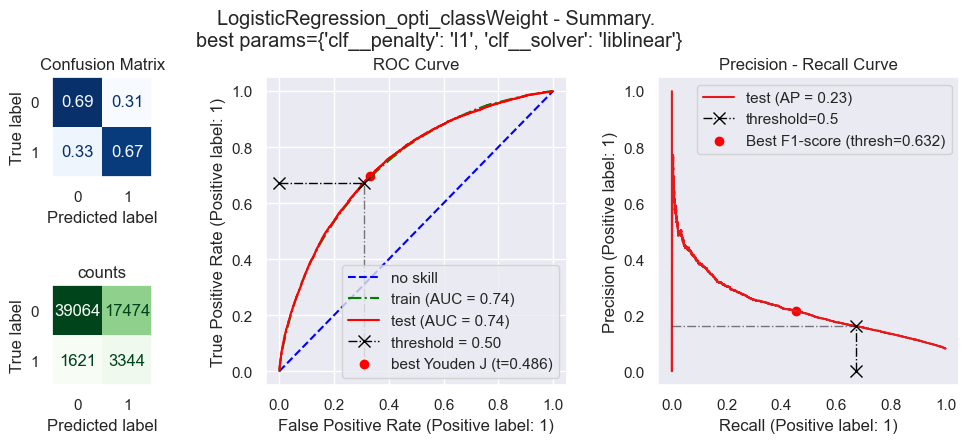

In [93]:
evaluate_model(Experience, LR_pipeline_cw,
               X_train, y_train,
               X_val, y_val, param_grid)

In [94]:
LR_opt_cw = df_scores_models.loc[df_scores_models["Experience"] ==
                                 "LogisticRegression_opti_classWeight"]
LR_opt_cw

Experience  \
0  LogisticRegression_opti_classWeight   

                                              params  train_time  \
0  {'clf__penalty': 'l1', 'clf__solver': 'libline...       1.524   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
0           15.374   0.674      0.161      0.69     0.259     0.411       0.6   

   ...  std_train_roc_auc  mean_test_business_metric std_test_business_metric  \
0  ...           0.000385                   0.683152                 0.001003   

  mean_train_business_metric std_train_business_metric mean_test_f2_score  \
0                   0.683959                   0.00034           0.407181   

   std_test_f2_score  mean_train_f2_score std_train_f2_score  \
0            0.00208             0.408492           0.000463   

   discrimination_threshold  
0                       0.5  

[1 rows x 38 columns]

In [95]:
log_mlflow_hyperparam(mlflow_hyp_opt.experiment_id, tags,
                      LR_pipeline_cw, "LogisticRegression_opti_classWeight",
                      Business_Metric=LR_opt_cw.business_metric,
                      Recall=LR_opt_cw.recall,
                      Precision=LR_opt_cw.precision,
                      Accuracy=LR_opt_cw.accuracy,
                      F1_score=LR_opt_cw.f1_score,
                      F2_score=LR_opt_cw.f2_score,
                      F5_score=LR_opt_cw.f5_score,
                      F10_score=LR_opt_cw.f10_score,
                      Roc_auc=LR_opt_cw.roc_auc,
                      AP_score=LR_opt_cw.ap_score,
                      TN=LR_opt_cw.tn, FP=LR_opt_cw.fp,
                      FN=LR_opt_cw.fn, TP=LR_opt_cw.tp,
                      params=(LR_opt_cw.params)[0])

<a id='optimization_RandomForest'></a>

### <span style='background:#0075bc'><span style='color:white'>Random Forest</span></span>

**Data balancing using SMOTE & RandomUnderSampling**

In [96]:
# X_train_SMOTE_UNDER, y_train_SMOTE_UNDER
# X_val, y_val

Experience = 'RForestClass_opti_smoteUnder'

rfc_pipeline = imbpipeline.Pipeline(steps=[
    ('clf', RandomForestClassifier(random_state=seed,
                                   max_features='auto'))])

param_grid = {'clf__max_depth': [5, 10, 50, None],
              'clf__max_features': ['auto', 'sqrt'],
              'clf__criterion': ['gini', 'entropy']}

rfc_pipeline

Pipeline(steps=[('clf',
                 RandomForestClassifier(max_features='auto', random_state=84))])

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


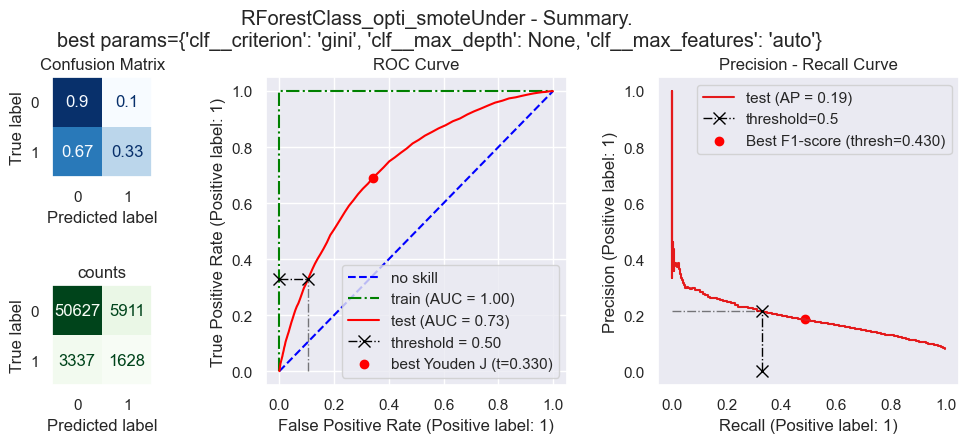

In [97]:
evaluate_model(Experience, rfc_pipeline,
               X_train_SMOTE_UNDER, y_train_SMOTE_UNDER,
               X_val, y_val, param_grid)

In [98]:
RF_opt_su = df_scores_models.loc[df_scores_models["Experience"] ==
                                 "RForestClass_opti_smoteUnder"]
RF_opt_su

Experience  \
0  RForestClass_opti_smoteUnder   

                                              params  train_time  \
0  {'clf__criterion': 'gini', 'clf__max_depth': N...     137.453   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
0         6972.056   0.328      0.216      0.85      0.26     0.297     0.321   

   ...  std_train_roc_auc  mean_test_business_metric std_test_business_metric  \
0  ...       4.965068e-17                   0.882311                 0.106947   

  mean_train_business_metric std_train_business_metric mean_test_f2_score  \
0                        1.0                       0.0           0.879264   

   std_test_f2_score  mean_train_f2_score std_train_f2_score  \
0           0.108508                  1.0                0.0   

   discrimination_threshold  
0                       0.5  

[1 rows x 38 columns]

In [99]:
log_mlflow_hyperparam(mlflow_hyp_opt.experiment_id, tags,
                      rfc_pipeline, "RForestClass_opti_smoteUnder",
                      Business_Metric=RF_opt_su.business_metric,
                      Recall=RF_opt_su.recall,
                      Precision=RF_opt_su.precision,
                      Accuracy=RF_opt_su.accuracy,
                      F1_score=RF_opt_su.f1_score,
                      F2_score=RF_opt_su.f2_score,
                      F5_score=RF_opt_su.f5_score,
                      F10_score=RF_opt_su.f10_score,
                      Roc_auc=RF_opt_su.roc_auc,
                      AP_score=RF_opt_su.ap_score,
                      TN=RF_opt_su.tn, FP=RF_opt_su.fp,
                      FN=RF_opt_su.fn, TP=RF_opt_su.tp,
                      params=(RF_opt_su.params)[0])

**Data balancing using class_weights**

In [100]:
# X_train, y_train
# X_val, y_val

Experience = 'RandomForest_opti_classWeight'
rfc_pipeline_cw = imbpipeline.Pipeline(steps=[
    ('clf', RandomForestClassifier(class_weight='balanced',
                                   random_state=seed,
                                   max_features='auto'))])

param_grid = {'clf__max_depth': [5, 10, 50, None],
              'clf__max_features': ['auto', 'sqrt'],
              'clf__criterion': ['gini', 'entropy']}

rfc_pipeline_cw

Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='auto',
                                        random_state=84))])

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


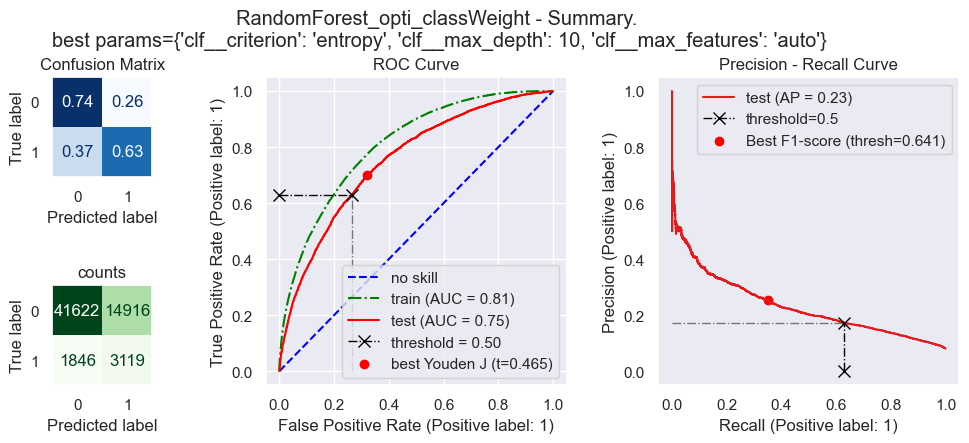

In [101]:
evaluate_model(Experience, rfc_pipeline_cw,
               X_train, y_train,
               X_val, y_val, param_grid)

In [102]:
RF_opt_cw = df_scores_models.loc[df_scores_models["Experience"] ==
                                 "RandomForest_opti_classWeight"]
RF_opt_cw

Experience  \
0  RandomForest_opti_classWeight   

                                              params  train_time  \
0  {'clf__criterion': 'entropy', 'clf__max_depth'...      66.645   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
0         5445.123   0.628      0.173     0.727     0.271     0.412      0.57   

   ...  std_train_roc_auc  mean_test_business_metric std_test_business_metric  \
0  ...           0.000544                   0.705282                  0.00106   

  mean_train_business_metric std_train_business_metric mean_test_f2_score  \
0                   0.739203                  0.000539           0.411962   

   std_test_f2_score  mean_train_f2_score std_train_f2_score  \
0           0.002076             0.471292           0.001108   

   discrimination_threshold  
0                       0.5  

[1 rows x 38 columns]

In [103]:
log_mlflow_hyperparam(mlflow_hyp_opt.experiment_id, tags,
                      RF_opt_cw, "RandomForest_opti_classWeight",
                      Business_Metric=RF_opt_cw.business_metric,
                      Recall=RF_opt_cw.recall,
                      Precision=RF_opt_cw.precision,
                      Accuracy=RF_opt_cw.accuracy,
                      F1_score=RF_opt_cw.f1_score,
                      F2_score=RF_opt_cw.f2_score,
                      F5_score=RF_opt_cw.f5_score,
                      F10_score=RF_opt_cw.f10_score,
                      Roc_auc=RF_opt_cw.roc_auc,
                      AP_score=RF_opt_cw.ap_score,
                      TN=RF_opt_cw.tn, FP=RF_opt_cw.fp, 
                      FN=RF_opt_cw.fn, TP=RF_opt_cw.tp,
                      params=(RF_opt_cw.params)[0])

2023/08/09 19:56:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
13:56: W291 trailing whitespace


<a id='optimization_XGBoost'></a>

### <span style='background:#0075bc'><span style='color:white'>XG Boost</span></span>

**Data balancing using SMOTE & RandomUnderSampling**

In [104]:
# X_train_SMOTE_UNDER, y_train_SMOTE_UNDER
# X_val, y_val

Experience = 'XGBoost_opti_smoteUnder'

XGBoost_pipeline_SU = imbpipeline.Pipeline(steps=[('clf', xgb.XGBClassifier(
    random_state=seed))])

param_grid = {'clf__learning_rate': [0.1, 0.01, 0.05],
              'clf__gamma': [0, 0.5, 2, 5],
              'clf__subsample': [0.6, 1.0],
              'clf__max_depth': [4, 6]}

XGBoost_pipeline_SU

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=84, ...))])

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


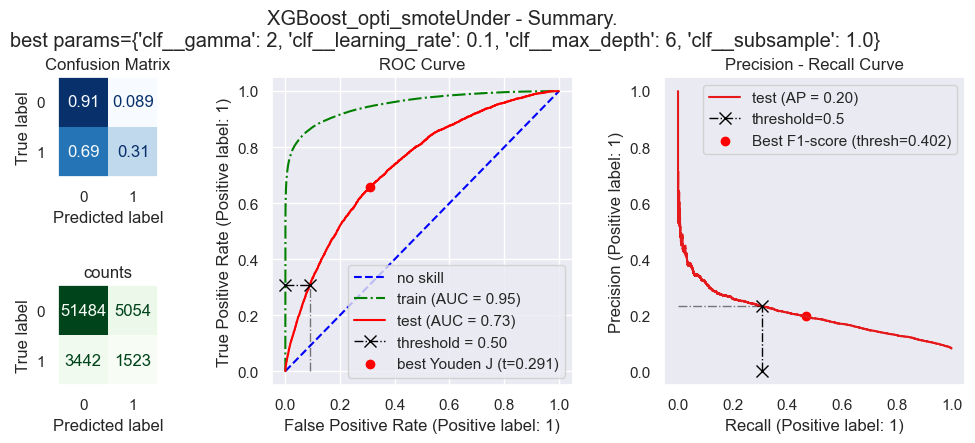

In [105]:
evaluate_model(Experience, XGBoost_pipeline_SU,
               X_train_SMOTE_UNDER, y_train_SMOTE_UNDER,
               X_val, y_val, param_grid)

In [106]:
XGB_opt_su = df_scores_models.loc[df_scores_models["Experience"] ==
                                  "XGBoost_opti_smoteUnder"]
XGB_opt_su

Experience                                             params  \
0  XGBoost_opti_smoteUnder  {'clf__gamma': 2, 'clf__learning_rate': 0.1, '...   

   train_time  gridsearch_time  recall  precision  accuracy  f1_score  \
0      38.191         5910.589   0.307      0.232     0.862     0.264   

   f2_score  f5_score  ...  std_train_roc_auc  mean_test_business_metric  \
0     0.288     0.303  ...           0.020574                   0.830678   

  std_test_business_metric mean_train_business_metric  \
0                 0.245673                   0.874514   

  std_train_business_metric mean_test_f2_score  std_test_f2_score  \
0                  0.043578            0.81385           0.274299   

   mean_train_f2_score std_train_f2_score  discrimination_threshold  
0             0.875372           0.043234                       0.5  

[1 rows x 38 columns]

In [107]:
log_mlflow_hyperparam(mlflow_hyp_opt.experiment_id, tags,
                      XGBoost_pipeline_SU, "XGBoost_opti_smoteUnder",
                      Business_Metric=XGB_opt_su.business_metric,
                      Recall=XGB_opt_su.recall,
                      Precision=XGB_opt_su.precision,
                      Accuracy=XGB_opt_su.accuracy,
                      F1_score=XGB_opt_su.f1_score,
                      F2_score=XGB_opt_su.f2_score,
                      F5_score=XGB_opt_su.f5_score,
                      F10_score=XGB_opt_su.f10_score,
                      Roc_auc=XGB_opt_su.roc_auc,
                      AP_score=XGB_opt_su.ap_score,
                      TN=XGB_opt_su.tn, FP=XGB_opt_su.fp,
                      FN=XGB_opt_su.fn, TP=XGB_opt_su.tp,
                      params=(XGB_opt_su.params)[0])

**Data balancing using class_weights**

In [108]:
# X_train, y_train
# X_val, y_val

Experience = 'XGBoost_opti_classWeight'
XGBoost_pipeline_cw = imbpipeline.Pipeline(steps=[('clf',
                                                   xgb.XGBClassifier(
                                                scale_pos_weight=pos_weight,
                                                       random_state=seed))])

param_grid = {'clf__learning_rate': [0.1, 0.01, 0.05],
               'clf__gamma': [0, 0.5, 2, 5],
               'clf__subsample': [0.6, 1.0],
               'clf__max_depth': [4, 6]}

XGBoost_pipeline_cw

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=84, ...))])

7:49: E122 continuation line missing indentation or outdented
10:13: E222 multiple spaces after operator


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


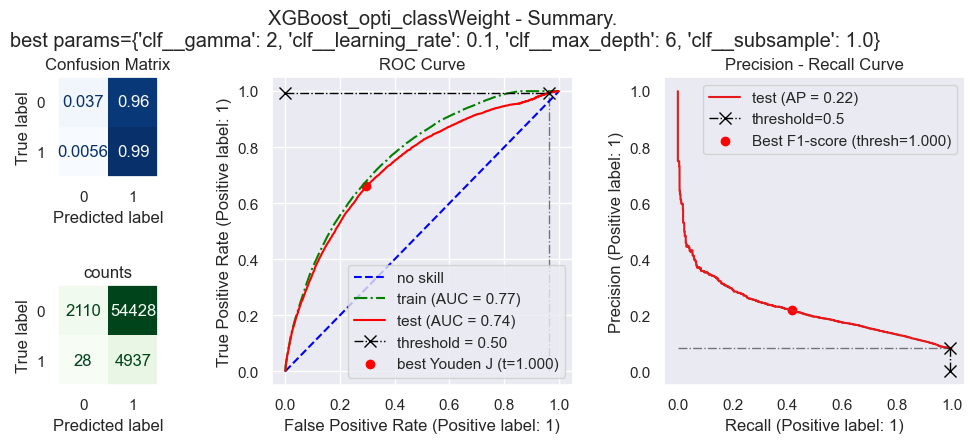

In [109]:
evaluate_model(Experience, XGBoost_pipeline_cw,
               X_train, y_train,
               X_val, y_val, param_grid)

In [110]:
XGBoost_opt_cw = df_scores_models.loc[df_scores_models["Experience"] ==
                                      "XGBoost_opti_classWeight"]
XGBoost_opt_cw

Experience  \
0  XGBoost_opti_classWeight   

                                              params  train_time  \
0  {'clf__gamma': 2, 'clf__learning_rate': 0.1, '...      29.399   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
0          4398.41   0.994      0.083     0.115     0.153     0.312       0.7   

   ...  std_train_roc_auc  mean_test_business_metric std_test_business_metric  \
0  ...           0.000373                   0.350931                 0.001233   

  mean_train_business_metric std_train_business_metric mean_test_f2_score  \
0                   0.353247                  0.000957           0.311963   

   std_test_f2_score  mean_train_f2_score std_train_f2_score  \
0           0.000505             0.314035           0.000319   

   discrimination_threshold  
0                       0.5  

[1 rows x 38 columns]

In [111]:
log_mlflow_hyperparam(mlflow_hyp_opt.experiment_id, tags,
                      XGBoost_opt_cw, "XGBoost_opti_classWeight",
                      Business_Metric=XGBoost_opt_cw.business_metric,
                      Recall=XGBoost_opt_cw.recall,
                      Precision=XGBoost_opt_cw.precision,
                      Accuracy=XGBoost_opt_cw.accuracy,
                      F1_score=XGBoost_opt_cw.f1_score,
                      F2_score=XGBoost_opt_cw.f2_score,
                      F5_score=XGBoost_opt_cw.f5_score,
                      F10_score=XGBoost_opt_cw.f10_score,
                      Roc_auc=XGBoost_opt_cw.roc_auc,
                      AP_score=XGBoost_opt_cw.ap_score,
                      TN=XGBoost_opt_cw.tn, FP=XGBoost_opt_cw.fp,
                      FN=XGBoost_opt_cw.fn, TP=XGBoost_opt_cw.tp,
                      params=(XGBoost_opt_cw.params)[0])

2023/08/09 22:54:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


<a id='roptimization_LightGBM'></a>

### <span style='background:#0075bc'><span style='color:white'>LightGBM</span></span>

**Data balancing using SMOTE & RandomUnderSampling**

In [112]:

# X_train_SMOTE_UNDER, y_train_SMOTE_UNDER
# X_val, y_val

Experience = 'LGBM_smoteUnder'

LGBM_SU_pipeline = imbpipeline.Pipeline(steps=[('clf',
                                    ltb.LGBMClassifier(random_state=seed,
                                                      verbose=-100))])

param_grid = {'clf__max_depth': [10, 50, 150],
              'clf__n_estimators': [100, 200],
             'clf__learning_rate': [0.01, 0.01, 1]}

LGBM_SU_pipeline

Pipeline(steps=[('clf', LGBMClassifier(random_state=84, verbose=-100))])

8:37: E128 continuation line under-indented for visual indent
9:55: E128 continuation line under-indented for visual indent
13:14: E128 continuation line under-indented for visual indent


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


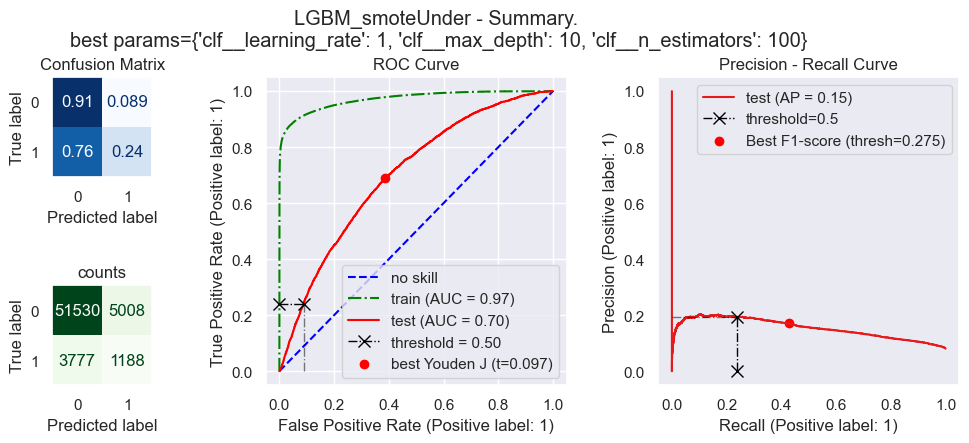

In [113]:
evaluate_model(Experience, LGBM_SU_pipeline,
               X_train_SMOTE_UNDER, y_train_SMOTE_UNDER,
               X_val, y_val, param_grid)

In [114]:
LGBM_SU_opt = df_scores_models\
    .loc[df_scores_models["Experience"] == "LGBM_smoteUnder"]
LGBM_SU_opt

Experience                                             params  \
0  LGBM_smoteUnder  {'clf__learning_rate': 1, 'clf__max_depth': 10...   

   train_time  gridsearch_time  recall  precision  accuracy  f1_score  \
0       1.471          214.981   0.239      0.192     0.857     0.213   

   f2_score  f5_score  ...  std_train_roc_auc  mean_test_business_metric  \
0     0.228     0.237  ...           0.001068                   0.833638   

  std_test_business_metric mean_train_business_metric  \
0                 0.272791                   0.907143   

  std_train_business_metric mean_test_f2_score  std_test_f2_score  \
0                    0.0368           0.812181            0.30838   

   mean_train_f2_score std_train_f2_score  discrimination_threshold  
0             0.908275           0.036176                       0.5  

[1 rows x 38 columns]

In [115]:
log_mlflow_hyperparam(mlflow_hyp_opt.experiment_id, tags,
                      LGBM_SU_pipeline, "LGBM_opti_smoteUnder",
                      Business_Metric=LGBM_SU_opt.business_metric,
                      Recall=LGBM_SU_opt.recall,
                      Precision=LGBM_SU_opt.precision,
                      Accuracy=LGBM_SU_opt.accuracy,
                      F1_score=LGBM_SU_opt.f1_score,
                      F2_score=LGBM_SU_opt.f2_score,
                      F5_score=LGBM_SU_opt.f5_score,
                      F10_score=LGBM_SU_opt.f10_score,
                      Roc_auc=LGBM_SU_opt.roc_auc,
                      AP_score=LGBM_SU_opt.ap_score,
                      TN=LGBM_SU_opt.tn, FP=LGBM_SU_opt.fp,
                      FN=LGBM_SU_opt.fn, TP=LGBM_SU_opt.tp,
                      params=(LGBM_SU_opt.params)[0])

**Data balancing using class_weights**

In [116]:
# Using class_weight

# X_train, y_train
# X_val, y_val

Experience = 'LGBM_class_weight'

LGBM_CW_pipeline = imbpipeline.Pipeline(steps=[('clf',
                                                ltb.LGBMClassifier(
                                                    class_weight='balanced',
                                                    random_state=seed,
                                                    verbose= -100))])

param_grid = {'clf__max_depth': [10, 50, 100],
              'clf__n_estimators': [100, 400],
             'clf__learning_rate': [0.01, 0.01, 1]}

LGBM_CW_pipeline

Pipeline(steps=[('clf',
                 LGBMClassifier(class_weight='balanced', random_state=84,
                                verbose=-100))])

12:61: E251 unexpected spaces around keyword / parameter equals
16:14: E128 continuation line under-indented for visual indent


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


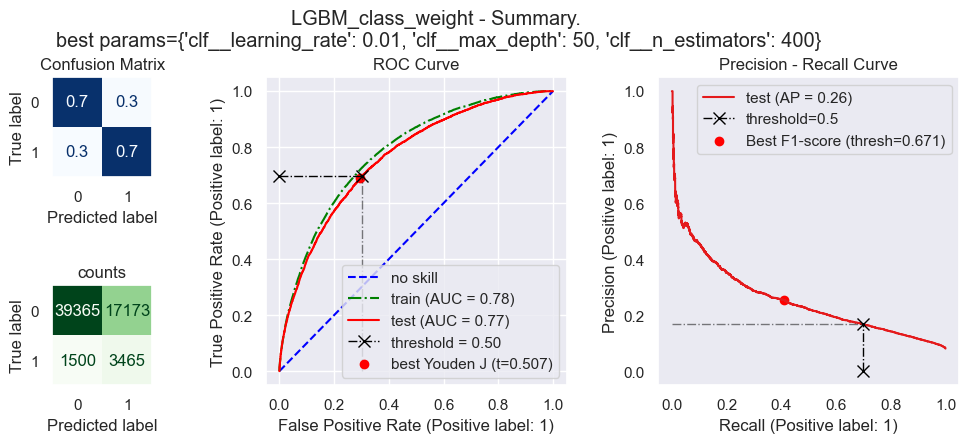

2:13: E128 continuation line under-indented for visual indent


In [117]:
evaluate_model(Experience, LGBM_CW_pipeline, X_train, y_train,
            X_val, y_val, param_grid)

In [118]:
LGBM_cw_opt = df_scores_models\
    .loc[df_scores_models["Experience"] == "LGBM_class_weight"]
LGBM_cw_opt

Experience                                             params  \
0  LGBM_class_weight  {'clf__learning_rate': 0.01, 'clf__max_depth':...   

   train_time  gridsearch_time  recall  precision  accuracy  f1_score  \
0       7.875          363.063   0.698      0.168     0.696     0.271   

   f2_score  f5_score  ...  std_train_roc_auc  mean_test_business_metric  \
0     0.428     0.622  ...           0.000676                   0.698485   

  std_test_business_metric mean_train_business_metric  \
0                 0.000817                   0.710634   

  std_train_business_metric mean_test_f2_score  std_test_f2_score  \
0                  0.001143           0.428575           0.002181   

   mean_train_f2_score std_train_f2_score  discrimination_threshold  
0             0.448153           0.001306                       0.5  

[1 rows x 38 columns]

In [119]:
log_mlflow_hyperparam(mlflow_hyp_opt.experiment_id, tags,
                      LGBM_CW_pipeline, "LGBM_opti_classWeight",
                      Business_Metric=LGBM_cw_opt.business_metric,
                      Recall=LGBM_cw_opt.recall,
                      Precision=LGBM_cw_opt.precision,
                      Accuracy=LGBM_cw_opt.accuracy,
                      F1_score=LGBM_cw_opt.f1_score, F2_score=LGBM_cw_opt.f2_score,
                      F5_score=LGBM_cw_opt.f5_score, F10_score=LGBM_cw_opt.f10_score,
                      Roc_auc=LGBM_cw_opt.roc_auc,
                      AP_score=LGBM_cw_opt.ap_score,
                      TN=LGBM_cw_opt.tn, FP=LGBM_cw_opt.fp,
                      FN=LGBM_cw_opt.fn, TP=LGBM_cw_opt.tp,
                      params=(dummy_opt.params)[0])

7:80: E501 line too long (83 > 79 characters)
8:80: E501 line too long (85 > 79 characters)


In [120]:
mlflow.end_run()

<a id='model_comparison'></a>


## <span style='background:#0085dd'><span style='color:white'>Model comparison</span></span>


In [197]:
# Open the table recording scores associated to best parameters for each model
path_score_models = 'model_tests/df_scores_models.pkl'

with open(path_score_models, 'rb') as f:
    df_scores_models = pickle.load(f)

In [198]:
pd.set_option('display.max_columns', 200)

* All results with a **'mean_test_auc' over 0.82** are suspected of **overfitting**.

In [199]:
# Models to be ignored
df_scores_models.loc[df_scores_models["mean_test_auc"] >= 0.82]

Experience  \
0              Baseline (Dummy)   
0  RForestClass_opti_smoteUnder   
0       XGBoost_opti_smoteUnder   
0               LGBM_smoteUnder   

                                              params  train_time  \
0                                                 {}       0.000   
0  {'clf__criterion': 'gini', 'clf__max_depth': N...     137.453   
0  {'clf__gamma': 2, 'clf__learning_rate': 0.1, '...      38.191   
0  {'clf__learning_rate': 1, 'clf__max_depth': 10...       1.471   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
0            0.199   0.000      0.000     0.919     0.000     0.000     0.000   
0         6972.056   0.328      0.216     0.850     0.260     0.297     0.321   
0         5910.589   0.307      0.232     0.862     0.264     0.288     0.303   
0          214.981   0.239      0.192     0.857     0.213     0.228     0.237   

   f10_score  business_metric     tn    fp    fn    tp  roc_auc  ap_score  \
0      0.000            0.674  56538     0  4965     0    0.500     0.081   
0      0.326            0.711  50627  5911  3337  1628    0.612     0.125   
0      0.306            0.714  51484  5054  3442  1523    0.609     0.127   
0      0.239            0.693  51530  5008  3777  1188    0.575     0.107   

                                               model  best_cv_score  \
0  (DummyClassifier(random_state=84, strategy='mo...       0.500000   
0  ((DecisionTreeClassifier(max_features='sqrt', ...       0.955915   
0  (XGBClassifier(base_score=None, booster=None, ...       0.934842   
0  (LGBMClassifier(learning_rate=1, max_depth=10,...       0.925113   

   refit_time  mean_test_auc  std_test_auc  mean_train_auc  std_train_auc  \
0    0.010399       0.919271  8.038188e-07        0.919271   2.009537e-07   
0  145.202321       0.883174  5.747570e-02        1.000000   0.000000e+00   
0   40.632651       0.862396  1.343397e-01        0.891694   3.576638e-02   
0    1.448796       0.863798  1.481647e-01        0.923494   2.814444e-02   

   mean_test_roc_auc  std_test_roc_auc  mean_train_roc_auc  std_train_roc_auc  \
0           0.500000          0.000000            0.500000       0.000000e+00   
0           0.955915          0.037262            1.000000       4.965068e-17   
0           0.934842          0.103002            0.953510       2.057433e-02   
0           0.925113          0.131189            0.968436       1.068091e-03   

   mean_test_business_metric  std_test_business_metric  \
0                   0.674308                  0.000002   
0                   0.882311                  0.106947   
0                   0.830678                  0.245673   
0                   0.833638                  0.272791   

   mean_train_business_metric  std_train_business_metric  mean_test_f2_score  \
0                    0.674308               5.946865e-07            0.000000   
0                    1.000000               0.000000e+00            0.879264   
0                    0.874514               4.357753e-02            0.813850   
0                    0.907143               3.679958e-02            0.812181   

   std_test_f2_score  mean_train_f2_score  std_train_f2_score  \
0           0.000000             0.000000            0.000000   
0           0.108508             1.000000            0.000000   
0           0.274299             0.875372            0.043234   
0           0.308380             0.908275            0.036176   

   discrimination_threshold  
0                       0.5  
0                       0.5  
0                       0.5  
0                       0.5

* Since there is a probability that SMOTE induces overfitting and because all tests concerned by a 'mean_test_auc' over 0.82 correspond to tests using smote, we will no longer consider tests using SMOTE.

In [212]:
# Models to be considered
text_to_find = 'smoteUnder'
df_scores_models_to_analyse = df_scores_models[~df_scores_models
                                               .Experience.str
                                               .endswith(text_to_find)]
df_scores_models_to_analyse = df_scores_models_to_analyse[
    ~df_scores_models_to_analyse.Experience.str
    .startswith("Baseline")]
df_scores_models_to_analyse.loc[df_scores_models_to_analyse["mean_test_auc"]
                                >= 0.82]

Empty DataFrame
Columns: [Experience, params, train_time, gridsearch_time, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, business_metric, tn, fp, fn, tp, roc_auc, ap_score, model, best_cv_score, refit_time, mean_test_auc, std_test_auc, mean_train_auc, std_train_auc, mean_test_roc_auc, std_test_roc_auc, mean_train_roc_auc, std_train_roc_auc, mean_test_business_metric, std_test_business_metric, mean_train_business_metric, std_train_business_metric, mean_test_f2_score, std_test_f2_score, mean_train_f2_score, std_train_f2_score, discrimination_threshold]
Index: []

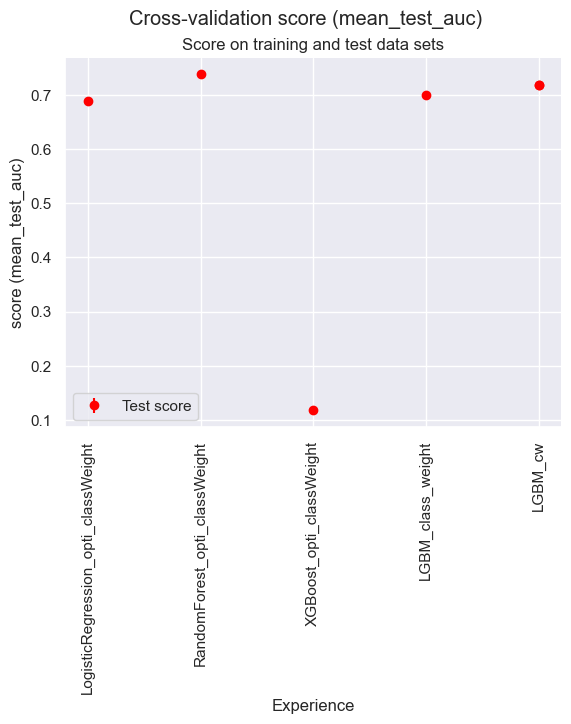

In [204]:
plot_cv_scores(df_scores_models_to_analyse, score='mean_test_auc')

In [205]:
df_scores_models_to_analyse.sort_values(by='mean_test_auc', ascending=False)

Experience  \
0        RandomForest_opti_classWeight   
0                              LGBM_cw   
0                              LGBM_cw   
0                    LGBM_class_weight   
0  LogisticRegression_opti_classWeight   
0             XGBoost_opti_classWeight   

                                              params  train_time  \
0  {'clf__criterion': 'entropy', 'clf__max_depth'...      66.645   
0  {'clf__max_depth': 8, 'clf__min_child_samples'...       1.757   
0  {'clf__max_depth': 8, 'clf__min_child_samples'...       1.627   
0  {'clf__learning_rate': 0.01, 'clf__max_depth':...       7.875   
0  {'clf__penalty': 'l1', 'clf__solver': 'libline...       1.524   
0  {'clf__gamma': 2, 'clf__learning_rate': 0.1, '...      29.399   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
0         5445.123   0.628      0.173     0.727     0.271     0.412     0.570   
0           58.411   0.690      0.175     0.712     0.279     0.434     0.619   
0           48.836   0.690      0.175     0.712     0.279     0.434     0.619   
0          363.063   0.698      0.168     0.696     0.271     0.428     0.622   
0           15.374   0.674      0.161     0.690     0.259     0.411     0.600   
0         4398.410   0.994      0.083     0.115     0.153     0.312     0.700   

   f10_score  business_metric     tn     fp    fn    tp  roc_auc  ap_score  \
0      0.612            0.701  41622  14916  1846  3119    0.682     0.139   
0      0.670            0.706  40379  16159  1541  3424    0.702     0.146   
0      0.670            0.706  40379  16159  1541  3424    0.702     0.146   
0      0.677            0.697  39365  17173  1500  3465    0.697     0.142   
0      0.653            0.685  39064  17474  1621  3344    0.682     0.135   
0      0.897            0.349   2110  54428    28  4937    0.516     0.083   

                                               model  best_cv_score  \
0  ((DecisionTreeClassifier(criterion='entropy', ...       0.751433   
0  (LGBMClassifier(class_weight='balanced', max_d...       0.773365   
0  (LGBMClassifier(class_weight='balanced', max_d...       0.773365   
0  (LGBMClassifier(class_weight='balanced', learn...       0.766595   
0  (LogisticRegression(class_weight='balanced', p...       0.742820   
0  (XGBClassifier(base_score=None, booster=None, ...       0.736066   

   refit_time  mean_test_auc  std_test_auc  mean_train_auc  std_train_auc  \
0   70.525269       0.737419      0.002055        0.750994       0.000985   
0    1.935298       0.717704      0.002433        0.727286       0.002052   
0    1.804653       0.717704      0.002433        0.727286       0.002052   
0    7.173667       0.699672      0.002437        0.704615       0.001546   
0    1.528008       0.689287      0.000379        0.689591       0.000247   
0   30.418945       0.117679      0.001531        0.118294       0.001305   

   mean_test_roc_auc  std_test_roc_auc  mean_train_roc_auc  std_train_roc_auc  \
0           0.751433          0.002019            0.817276           0.000544   
0           0.773365          0.003030            0.816640           0.000858   
0           0.773365          0.003030            0.816640           0.000858   
0           0.766595          0.002375            0.787663           0.000676   
0           0.742820          0.001623            0.743511           0.000385   
0           0.736066          0.003958            0.767016           0.000373   

   mean_test_business_metric  std_test_business_metric  \
0                   0.705282                  0.001060   
0                   0.709243                  0.001838   
0                   0.709243                  0.001838   
0                   0.698485                  0.000817   
0                   0.683152                  0.001003   
0                   0.350931                  0.001233   

   mean_train_business_metric  std_train_business_metric  mean_test_f2_score  \
0                    0.739203                   

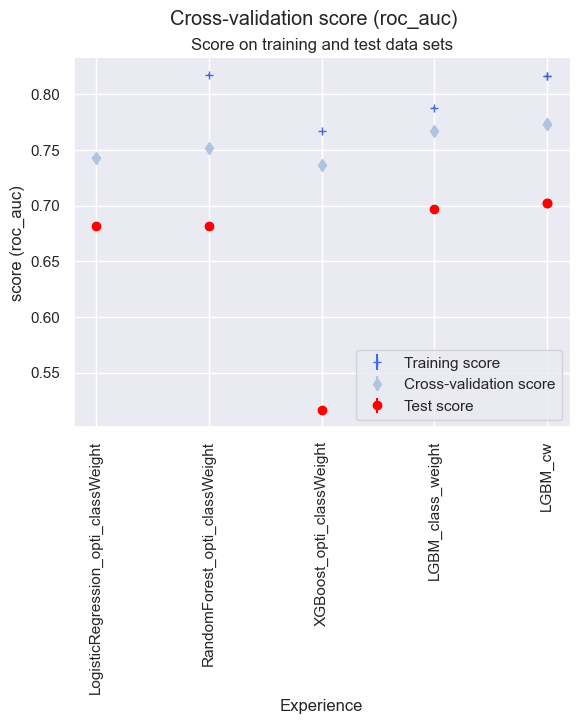

In [206]:
plot_cv_scores(df_scores_models_to_analyse)

In [207]:
df_scores_models_to_analyse.sort_values(by='roc_auc', ascending=False)

Experience  \
0                              LGBM_cw   
0                              LGBM_cw   
0                    LGBM_class_weight   
0  LogisticRegression_opti_classWeight   
0        RandomForest_opti_classWeight   
0             XGBoost_opti_classWeight   

                                              params  train_time  \
0  {'clf__max_depth': 8, 'clf__min_child_samples'...       1.757   
0  {'clf__max_depth': 8, 'clf__min_child_samples'...       1.627   
0  {'clf__learning_rate': 0.01, 'clf__max_depth':...       7.875   
0  {'clf__penalty': 'l1', 'clf__solver': 'libline...       1.524   
0  {'clf__criterion': 'entropy', 'clf__max_depth'...      66.645   
0  {'clf__gamma': 2, 'clf__learning_rate': 0.1, '...      29.399   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
0           58.411   0.690      0.175     0.712     0.279     0.434     0.619   
0           48.836   0.690      0.175     0.712     0.279     0.434     0.619   
0          363.063   0.698      0.168     0.696     0.271     0.428     0.622   
0           15.374   0.674      0.161     0.690     0.259     0.411     0.600   
0         5445.123   0.628      0.173     0.727     0.271     0.412     0.570   
0         4398.410   0.994      0.083     0.115     0.153     0.312     0.700   

   f10_score  business_metric     tn     fp    fn    tp  roc_auc  ap_score  \
0      0.670            0.706  40379  16159  1541  3424    0.702     0.146   
0      0.670            0.706  40379  16159  1541  3424    0.702     0.146   
0      0.677            0.697  39365  17173  1500  3465    0.697     0.142   
0      0.653            0.685  39064  17474  1621  3344    0.682     0.135   
0      0.612            0.701  41622  14916  1846  3119    0.682     0.139   
0      0.897            0.349   2110  54428    28  4937    0.516     0.083   

                                               model  best_cv_score  \
0  (LGBMClassifier(class_weight='balanced', max_d...       0.773365   
0  (LGBMClassifier(class_weight='balanced', max_d...       0.773365   
0  (LGBMClassifier(class_weight='balanced', learn...       0.766595   
0  (LogisticRegression(class_weight='balanced', p...       0.742820   
0  ((DecisionTreeClassifier(criterion='entropy', ...       0.751433   
0  (XGBClassifier(base_score=None, booster=None, ...       0.736066   

   refit_time  mean_test_auc  std_test_auc  mean_train_auc  std_train_auc  \
0    1.935298       0.717704      0.002433        0.727286       0.002052   
0    1.804653       0.717704      0.002433        0.727286       0.002052   
0    7.173667       0.699672      0.002437        0.704615       0.001546   
0    1.528008       0.689287      0.000379        0.689591       0.000247   
0   70.525269       0.737419      0.002055        0.750994       0.000985   
0   30.418945       0.117679      0.001531        0.118294       0.001305   

   mean_test_roc_auc  std_test_roc_auc  mean_train_roc_auc  std_train_roc_auc  \
0           0.773365          0.003030            0.816640           0.000858   
0           0.773365          0.003030            0.816640           0.000858   
0           0.766595          0.002375            0.787663           0.000676   
0           0.742820          0.001623            0.743511           0.000385   
0           0.751433          0.002019            0.817276           0.000544   
0           0.736066          0.003958            0.767016           0.000373   

   mean_test_business_metric  std_test_business_metric  \
0                   0.709243                  0.001838   
0                   0.709243                  0.001838   
0                   0.698485                  0.000817   
0                   0.683152                  0.001003   
0                   0.705282                  0.001060   
0                   0.350931                  0.001233   

   mean_train_business_metric  std_train_business_metric  mean_test_f2_score  \
0                    0.732913                   

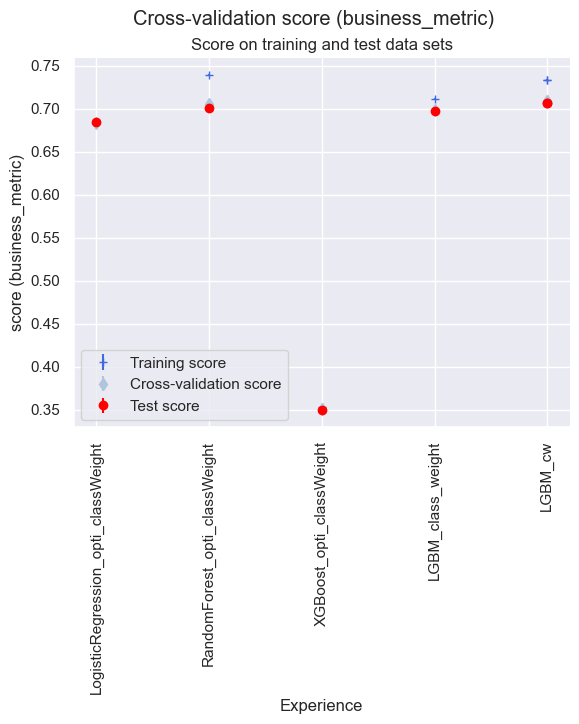

In [208]:
plot_cv_scores(df_scores_models_to_analyse, score='business_metric')

In [209]:
df_scores_models_to_analyse.sort_values(by='business_metric', ascending=False)

Experience  \
0                              LGBM_cw   
0                              LGBM_cw   
0        RandomForest_opti_classWeight   
0                    LGBM_class_weight   
0  LogisticRegression_opti_classWeight   
0             XGBoost_opti_classWeight   

                                              params  train_time  \
0  {'clf__max_depth': 8, 'clf__min_child_samples'...       1.757   
0  {'clf__max_depth': 8, 'clf__min_child_samples'...       1.627   
0  {'clf__criterion': 'entropy', 'clf__max_depth'...      66.645   
0  {'clf__learning_rate': 0.01, 'clf__max_depth':...       7.875   
0  {'clf__penalty': 'l1', 'clf__solver': 'libline...       1.524   
0  {'clf__gamma': 2, 'clf__learning_rate': 0.1, '...      29.399   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
0           58.411   0.690      0.175     0.712     0.279     0.434     0.619   
0           48.836   0.690      0.175     0.712     0.279     0.434     0.619   
0         5445.123   0.628      0.173     0.727     0.271     0.412     0.570   
0          363.063   0.698      0.168     0.696     0.271     0.428     0.622   
0           15.374   0.674      0.161     0.690     0.259     0.411     0.600   
0         4398.410   0.994      0.083     0.115     0.153     0.312     0.700   

   f10_score  business_metric     tn     fp    fn    tp  roc_auc  ap_score  \
0      0.670            0.706  40379  16159  1541  3424    0.702     0.146   
0      0.670            0.706  40379  16159  1541  3424    0.702     0.146   
0      0.612            0.701  41622  14916  1846  3119    0.682     0.139   
0      0.677            0.697  39365  17173  1500  3465    0.697     0.142   
0      0.653            0.685  39064  17474  1621  3344    0.682     0.135   
0      0.897            0.349   2110  54428    28  4937    0.516     0.083   

                                               model  best_cv_score  \
0  (LGBMClassifier(class_weight='balanced', max_d...       0.773365   
0  (LGBMClassifier(class_weight='balanced', max_d...       0.773365   
0  ((DecisionTreeClassifier(criterion='entropy', ...       0.751433   
0  (LGBMClassifier(class_weight='balanced', learn...       0.766595   
0  (LogisticRegression(class_weight='balanced', p...       0.742820   
0  (XGBClassifier(base_score=None, booster=None, ...       0.736066   

   refit_time  mean_test_auc  std_test_auc  mean_train_auc  std_train_auc  \
0    1.935298       0.717704      0.002433        0.727286       0.002052   
0    1.804653       0.717704      0.002433        0.727286       0.002052   
0   70.525269       0.737419      0.002055        0.750994       0.000985   
0    7.173667       0.699672      0.002437        0.704615       0.001546   
0    1.528008       0.689287      0.000379        0.689591       0.000247   
0   30.418945       0.117679      0.001531        0.118294       0.001305   

   mean_test_roc_auc  std_test_roc_auc  mean_train_roc_auc  std_train_roc_auc  \
0           0.773365          0.003030            0.816640           0.000858   
0           0.773365          0.003030            0.816640           0.000858   
0           0.751433          0.002019            0.817276           0.000544   
0           0.766595          0.002375            0.787663           0.000676   
0           0.742820          0.001623            0.743511           0.000385   
0           0.736066          0.003958            0.767016           0.000373   

   mean_test_business_metric  std_test_business_metric  \
0                   0.709243                  0.001838   
0                   0.709243                  0.001838   
0                   0.705282                  0.001060   
0                   0.698485                  0.000817   
0                   0.683152                  0.001003   
0                   0.350931                  0.001233   

   mean_train_business_metric  std_train_business_metric  mean_test_f2_score  \
0                    0.732913                   

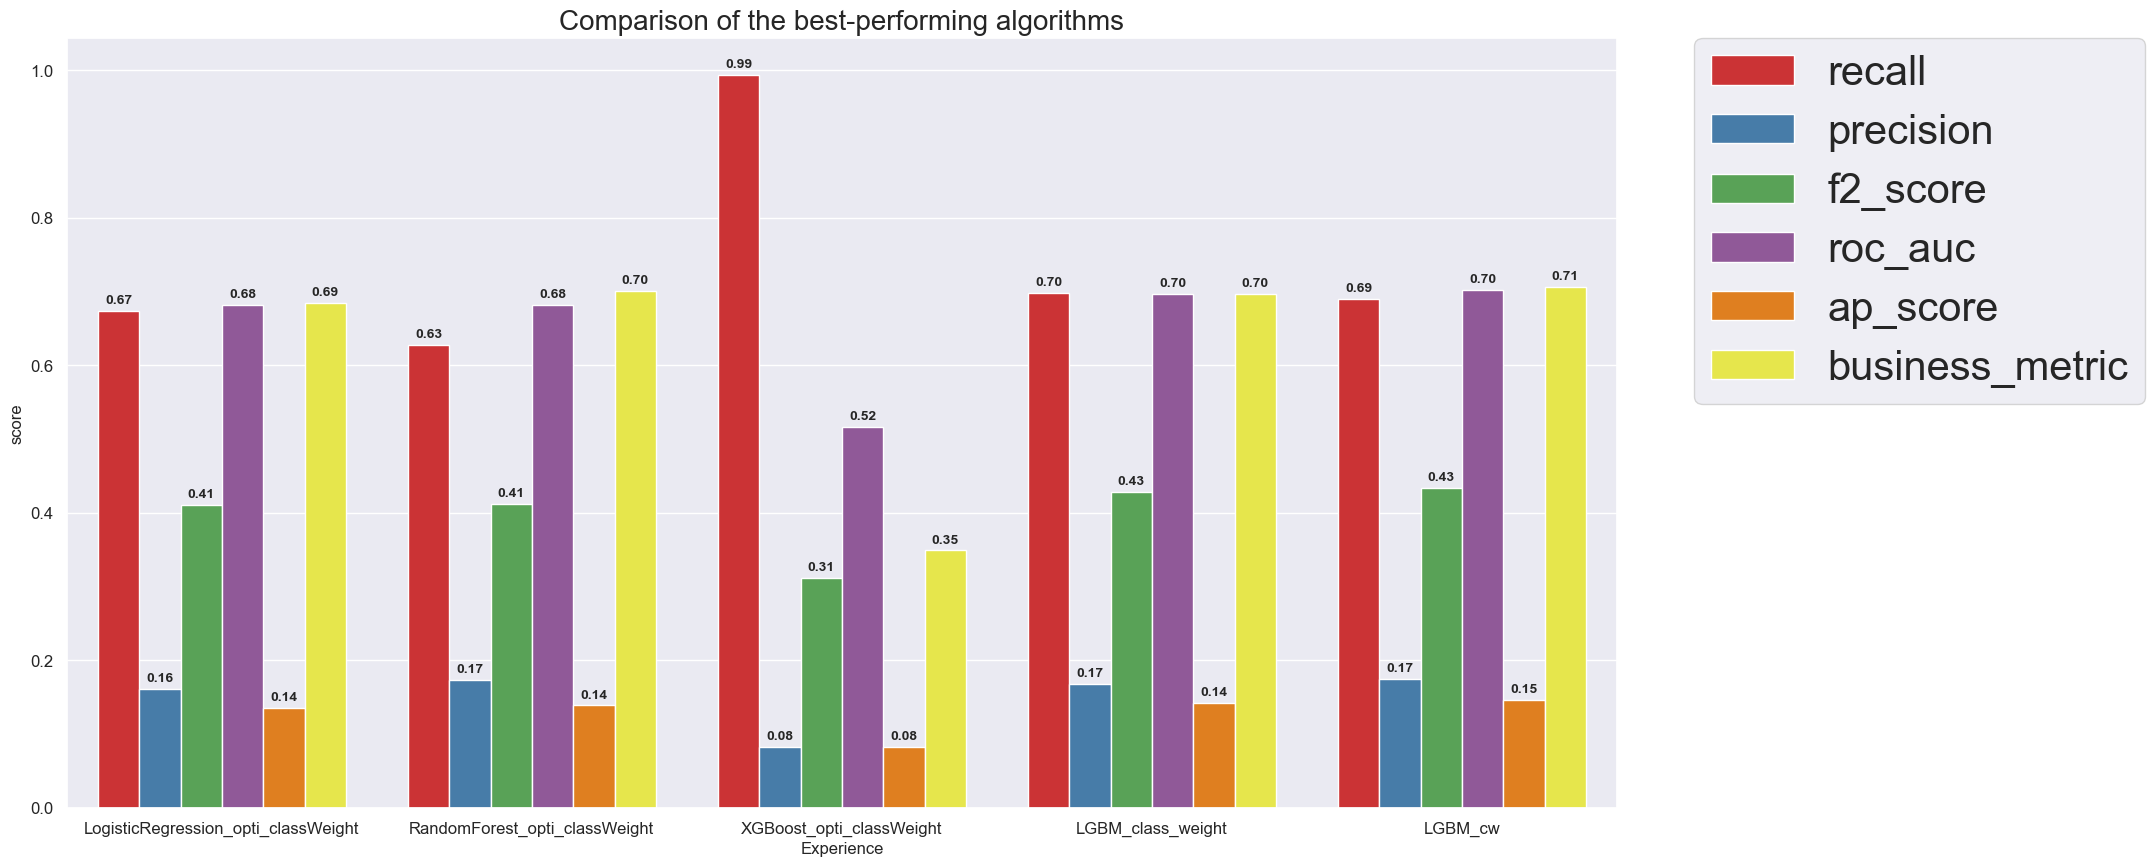

21:21: E201 whitespace after '('
21:23: E225 missing whitespace around operator
30:80: E501 line too long (96 > 79 characters)


In [210]:
# Visual comparison of algorithms

# Scores
comparaison_models_melt = \
    pd.melt(df_scores_models_to_analyse, id_vars=['Experience'],
            value_name='score',
            value_vars=['recall', 'precision', 'f2_score',
                        'roc_auc', 'ap_score', 'business_metric'])
# Visualization
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=comparaison_models_melt['Experience'],
                 y=comparaison_models_melt['score'],
                 hue=comparaison_models_melt['variable'])
plt.title('Comparison of the best-performing algorithms',
          fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x( )+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=10,
            fontweight='bold')
plt.show()

df_scores_models_to_analyse[['Experience', 'recall', 'precision', 'f2_score',
                             'roc_auc', 'ap_score', 'business_metric']].style.hide(axis="index")

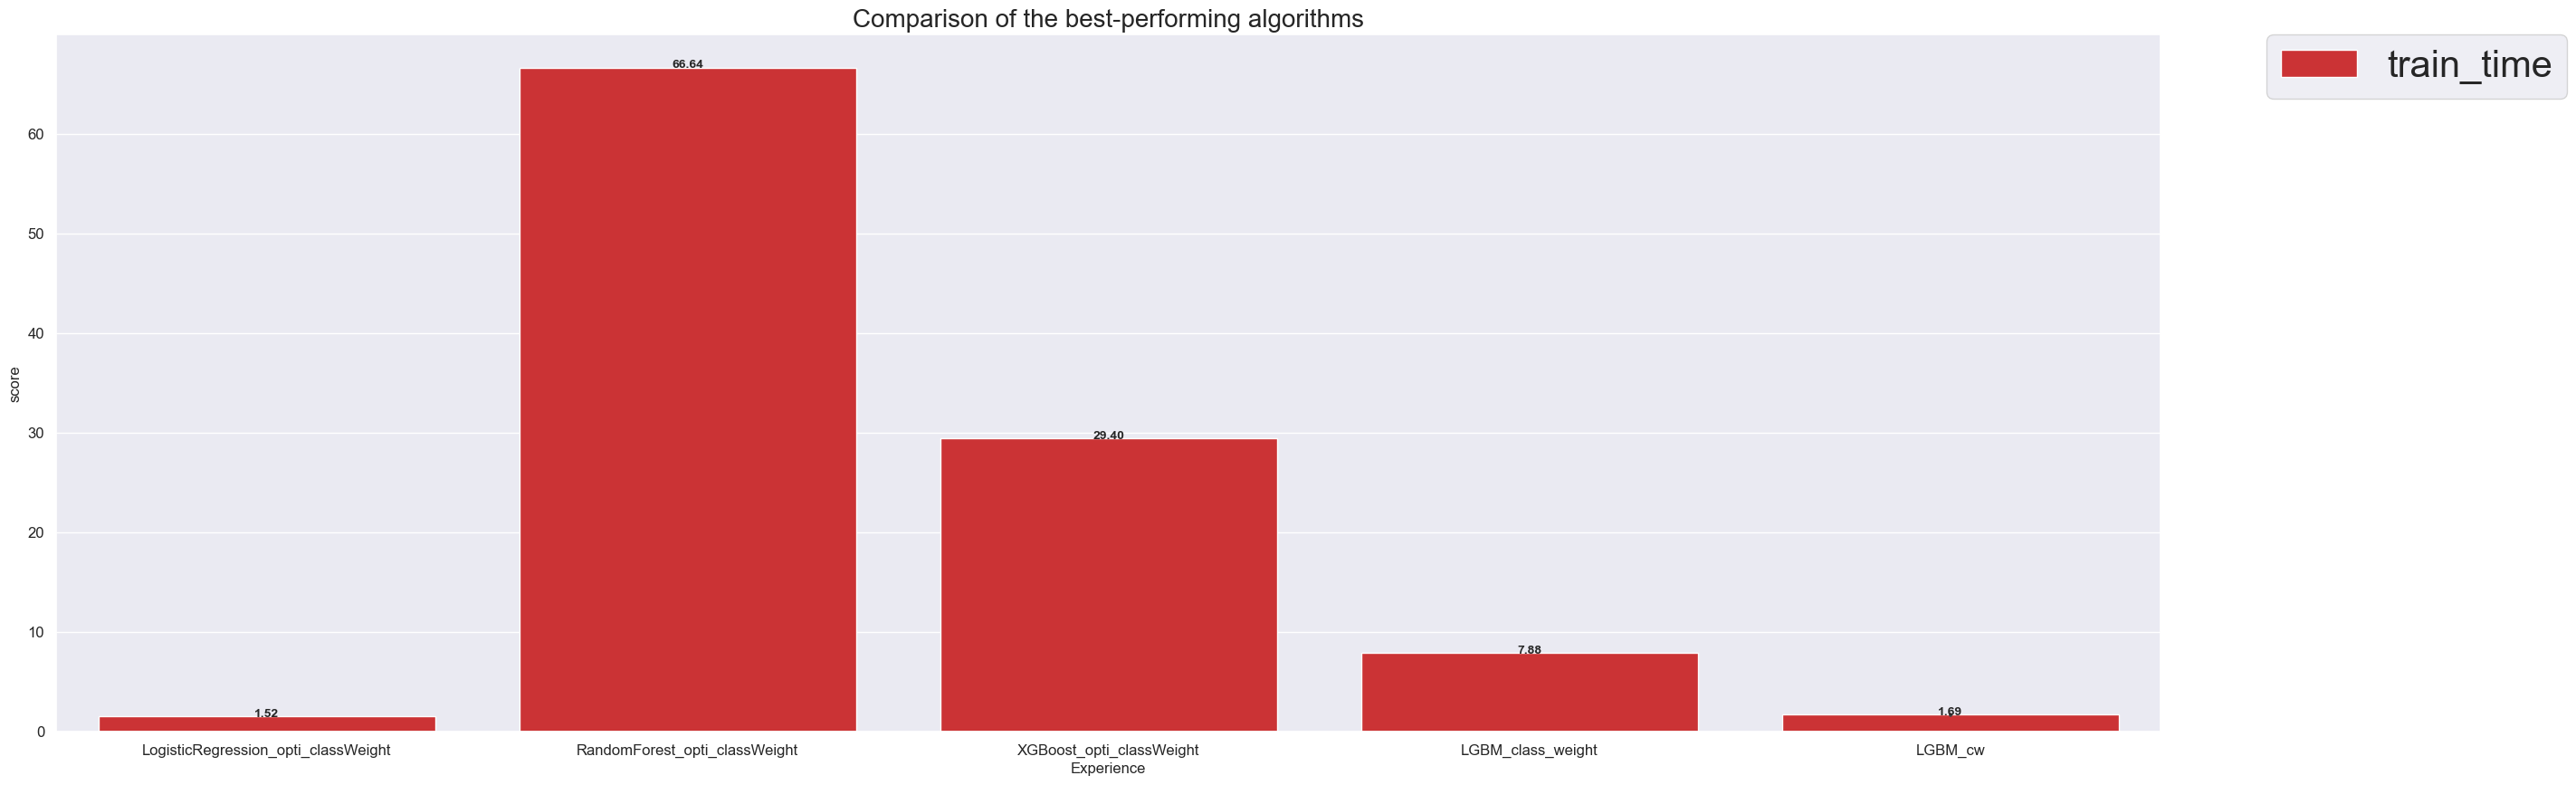

In [211]:
# Visual comparison of algorithms

# Scores
comparaison_models_melt = \
    pd.melt(df_scores_models_to_analyse, id_vars=['Experience'],
            value_name='score',
            value_vars=['train_time'])
# Visualization
plt.figure(figsize=(30, 10))
ax = sns.barplot(x=comparaison_models_melt['Experience'],
                 y=comparaison_models_melt['score'],
                 hue=comparaison_models_melt['variable'])
plt.title('Comparison of the best-performing algorithms',
          fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=10,
            fontweight='bold')
plt.show()

df_scores_models_to_analyse[['Experience',
                             'train_time']].style.hide(axis="index")

<a id='best_model_selection'></a>


## <span style='background:#0085dd'><span style='color:white'>Best model selection</span></span>


The combination of metric values and calculation time leads us to select **Light GBM with class_weight**, for data rebalancing, as the best model. It will be implemented for the rest of the project.

<a id='best_model'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Best model** </span></span>


<a id='load_full_data_train'></a>

## <span style='background:#0085dd'><span style='color:white'>Model training on the whole dataset</span></span>

In [165]:
# -----------------------------
# Files loading:
# -----------------------------

# Open final train_dataset
path_train_data = \
    'preprocessing/train_data_fs_t25_combi_ML.pkl'

with open(path_train_data, 'rb') as f:
    train_data = pickle.load(f)


# Open final test_dataset
path_test_data = \
    'preprocessing/test_data_fs_t25_combi_ML.pkl'
os.makedirs(os.path.dirname(path_test_data), exist_ok=True)

In [166]:
# Define target
y = train_data.pop('TARGET')
print(f'y : {y.shape}')

# Transfer of the customer identifier to the index for modelling purposes
train_data.set_index('SK_ID_CURR', inplace=True)
X = train_data
print(f'X : {X.shape}')

In [167]:
# Split dataset (filled)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  train_size=TRAIN_SIZE,
                                                  shuffle=True,
                                                  stratify=y,
                                                  random_state=seed)

In [168]:
# ----------------------------------------------
# Hyperparameter optimization with the whole dataset

Experience = 'LGBM_cw'

LGBM_pipeline = imbpipeline.Pipeline(steps=[('clf',
                                             ltb.LGBMClassifier(
                                                 class_weight='balanced',
                                                 random_state=seed,
                                                 verbose=-100))])

param_grid = {'clf__max_depth': range(3, 10),
              'clf__min_child_samples': [50]}

LGBM_pipeline

Pipeline(steps=[('clf',
                 LGBMClassifier(class_weight='balanced', random_state=84,
                                verbose=-100))])

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


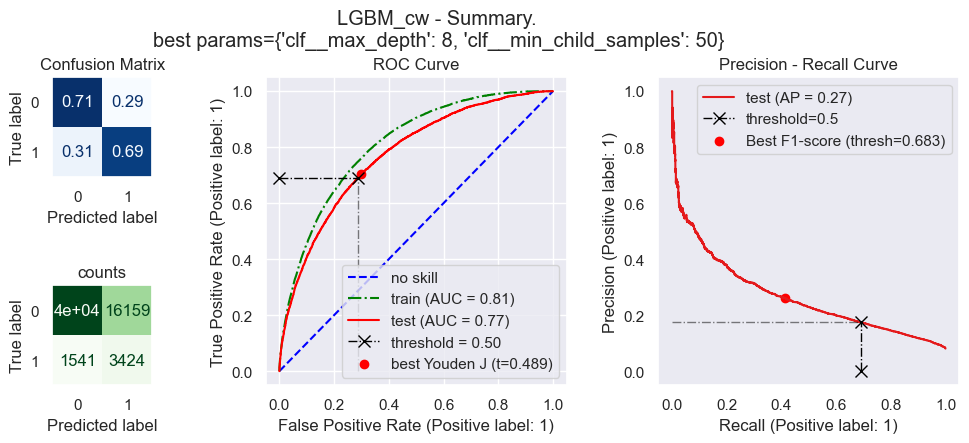

In [169]:
evaluate_model(Experience,
               LGBM_pipeline,
               X_train, y_train,
               X_val, y_val,
               param_grid)

In [170]:
# ---------------------------------------------
# Training the model with the best parameters

Experience = 'LGBM_cw_best_params_defafult_trhesh'
LGBM_best_params = dict(max_depth=3, min_child_samples=50)

LGBM_best_pipeline = imbpipeline.Pipeline(steps=[('clf',
                                                  ltb.LGBMClassifier(
                                                      class_weight='balanced',
                                                      random_state=seed,
                                                      **LGBM_best_params,
                                                      verbose=-100))])

LGBM_best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 LGBMClassifier(class_weight='balanced', max_depth=3,
                                min_child_samples=50, random_state=84,
                                verbose=-100))])

In [171]:
df_results_thresh = tools_modeling.process_classif_thresh(
                                        LGBM_best_pipeline, 0.5,
                                        X_train, X_val,
                                        y_train, y_val,
                                        df_results_thresh, Experience,
                                        show_results=False,
                                        show_conf_matrix=False)

<a id='prob_threshold_finetuning'></a>

## <span style='background:#0085dd'><span style='color:white'>Bank benefit (score) optimising by pobability threshold fine-tuning</span></span>

The optimisation was done on the "roc_auc" metric (balance between false negatives and false positives):

We can then optimise the probability discrimination threshold (<span style='background:LightBlue'>**tools_modeling.prob_threshold**</span>.) for the bank to accept or reject a loan, based on: 
(a) the business metric created above; or 
(b) another profit and loss metric which can vary based on the amount of credit, repayment duration, ...

This section optimises the discrimination threshold for the <span style='background:LightBlue'>**custom_score**</span> metric.

In [172]:
df_thresholds = pd.DataFrame()

Thresholds  Business Score
0         0.00        0.325688
1         0.01        0.325724
2         0.02        0.326893
3         0.03        0.329529
4         0.04        0.331938
..         ...             ...
95        0.95        0.674377
96        0.96        0.674312
97        0.97        0.674312
98        0.98        0.674312
99        0.99        0.674312

[100 rows x 2 columns]

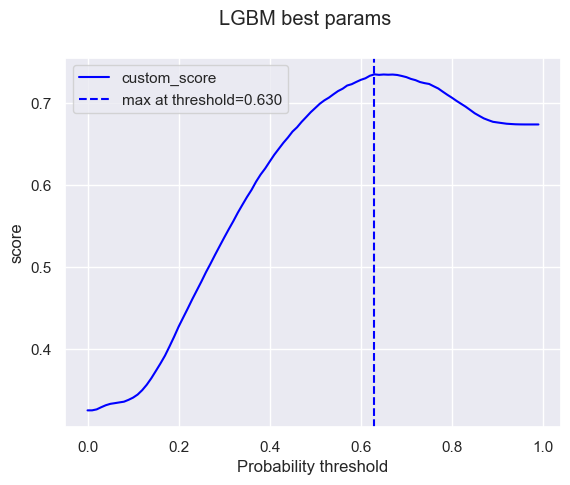

1:80: E501 line too long (103 > 79 characters)


In [173]:
tools_modeling.prob_threshold(LGBM_best_pipeline, X_val, y_val, "LGBM best params", df_thresholds, n=1)

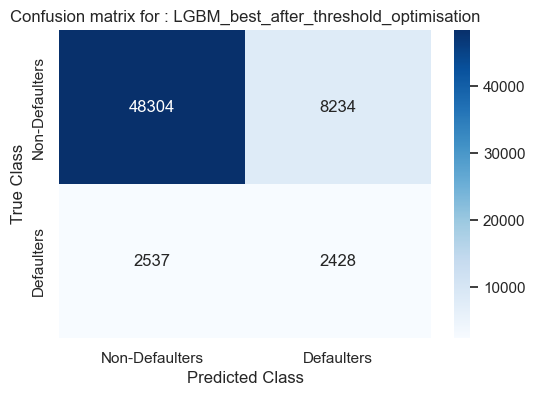

In [174]:
df_results_thresh = tools_modeling.process_classif_thresh(
    LGBM_best_pipeline, 0.63,
    X_train, X_val, y_train, y_val,
    df_results_thresh, "LGBM_best_after_threshold_optimisation")

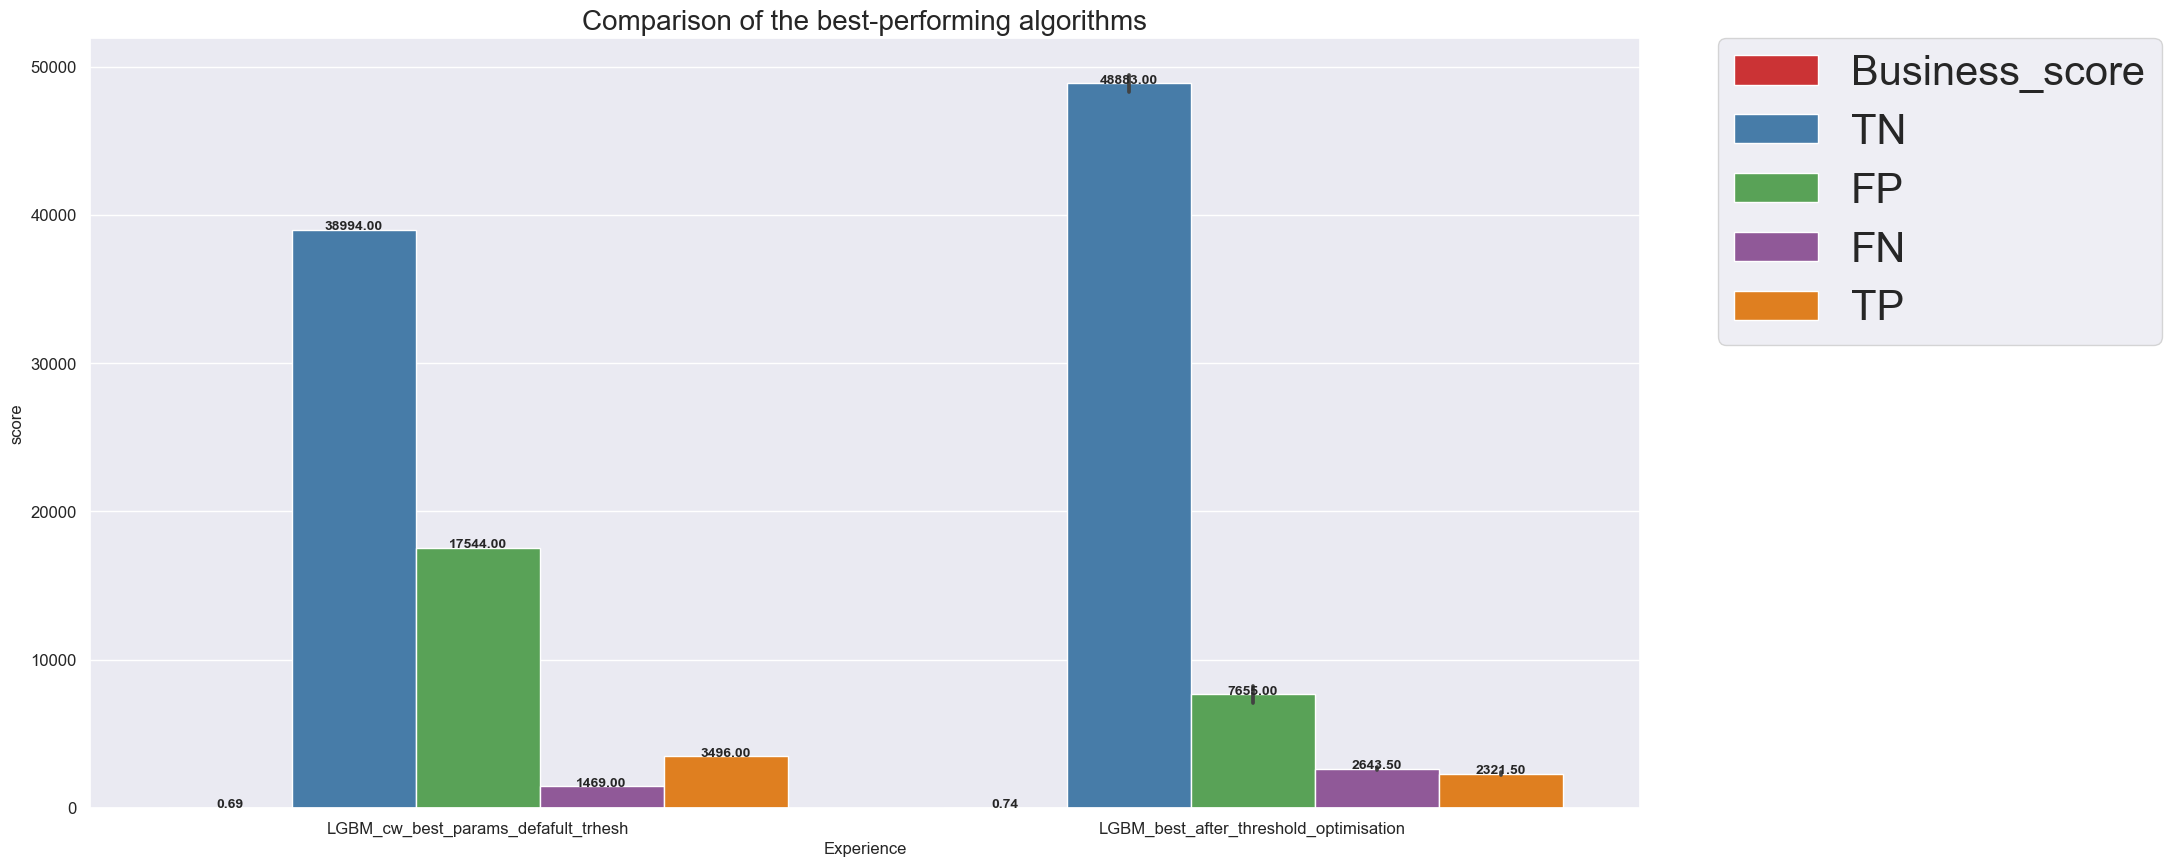

12:17: E128 continuation line under-indented for visual indent
13:13: E128 continuation line under-indented for visual indent


In [175]:
# Visual comparison results without and with
# probability threshold optimisaiton

# Scores
comparaison_tresh = \
    pd.melt(df_results_thresh, id_vars=['Experience'],
            value_name='score',
            value_vars=['Business_score', 'TN', 'FP', 'FN', 'TP'])
# Visualization
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=comparaison_tresh['Experience'],
                y=comparaison_tresh['score'],
            hue=comparaison_tresh['variable'])
plt.title('Comparison of the best-performing algorithms',
          fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=10,
            fontweight='bold')
plt.show()

df_results_thresh[['Experience', 'Business_score',
                   'TN', 'FP', 'FN', 'TP']].style.hide(axis="index")

The probability threshold optimisation results in:
* an improvement of the Business score 
* an increase in the True Negatives (non-defaulters identified as non-defaulters)
* a decrease in False Positives (defaulters identified as non-defaulters)
* an increase in False Negatives (non-defaulters identified as defaulters)
* a decrease in True Positives (defaulters identified as defaulters)

The default probability threshold value (0.5) will be retained for the development of the rest of the project.



<a id='save_best_model'></a>

## <span style='background:#0085dd'><span style='color:white'>Save best model</span></span>

In [176]:

LGBM_best_pipeline.fit(X_train, y_train)

path_save_models = '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/OC_DS_P7_02_api_dashboard/'
if not os.path.exists(path_save_models):
    os.makedirs(path_save_models)

# Files of client data to visualize
datafiles = dict(X_val=X_val,
                 y_val=y_val.to_frame())


for key in datafiles.keys():
    datafiles[key].to_csv(f'{path_save_models}/{key}.csv')

4:80: E501 line too long (127 > 79 characters)


In [177]:
# Save best model
path_best_model = '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/OC_DS_P7_02_api_dashboard/lgbm_best_model.pkl'

with open(path_best_model, 'wb') as f:
    pickle.dump(LGBM_best_pipeline, f, pickle.HIGHEST_PROTOCOL)

2:80: E501 line too long (145 > 79 characters)


<a id='best_model_feature_importance'></a>

## <span style='background:#0085dd'><span style='color:white'>Feature importance</span></span>

Two measures, valid only if the model has a good level of prediction
 * (impurity-based) feature importance ('model.feature*importances*')
 * (permutation-based) feature importance (sklearn.inspection.permutation_importance)

In [178]:
# -----------------------------
# Files loading:
# -----------------------------
path_best_model = '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/OC_DS_P7_02_api_dashboard/lgbm_best_model.pkl'

with open(path_best_model, 'rb') as f:
    best_model = pickle.load(f)

4:80: E501 line too long (145 > 79 characters)


<a id='best_model_impurity_based_feat_imp'></a>

### <span style='background:#0075bc'><span style='color:white'>Impurity-based feature importance</span></span>

- based on the training set during fit (TreeRegressors)
- based on entropy
- may have features too large for train but not very predictive (overfitting))
- bias towards features with high cardinality
- may put too much emphasis on numerical features

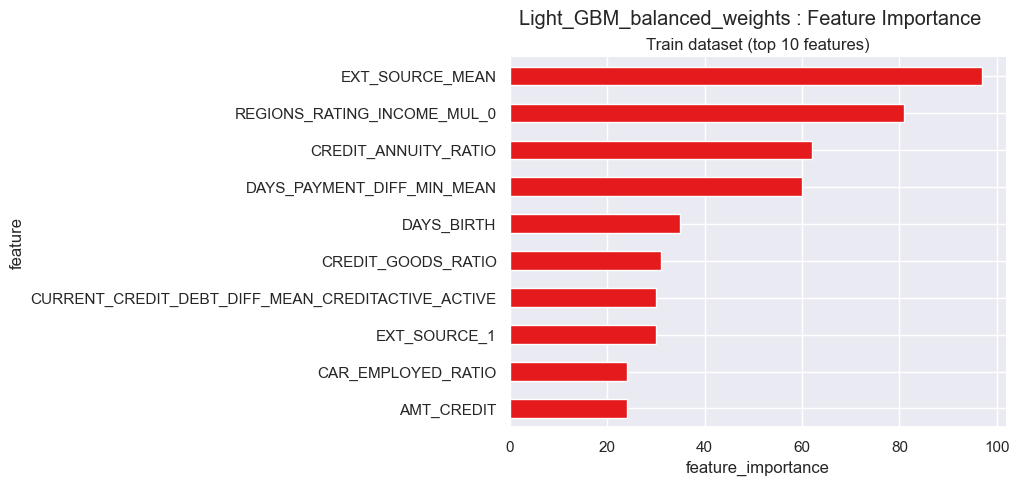

In [179]:
best_model_name = 'Light_GBM_balanced_weights'
plot_feature_importances(best_model, X_train, best_model_name)

<a id='best_model_permutation_based_feat_imp'></a>

### <span style='background:#0075bc'><span style='color:white'>Permutation-based feature importance</span></span>

- computed on the test set
- based on permutation of values in each feature to see impact on prediction

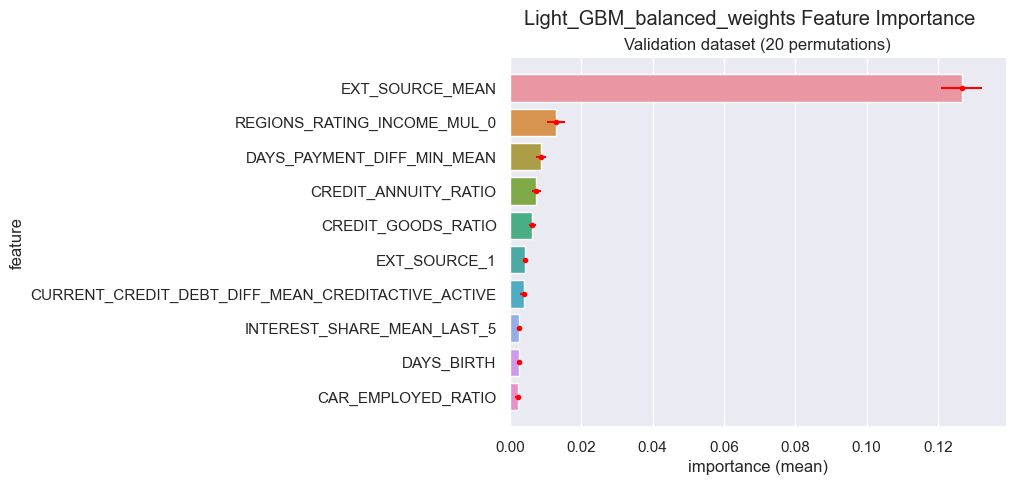

In [180]:
evaluate_permutation_importance(best_model,
                                X_val, y_val,
                                model_name=best_model_name,
                                scoring='roc_auc')

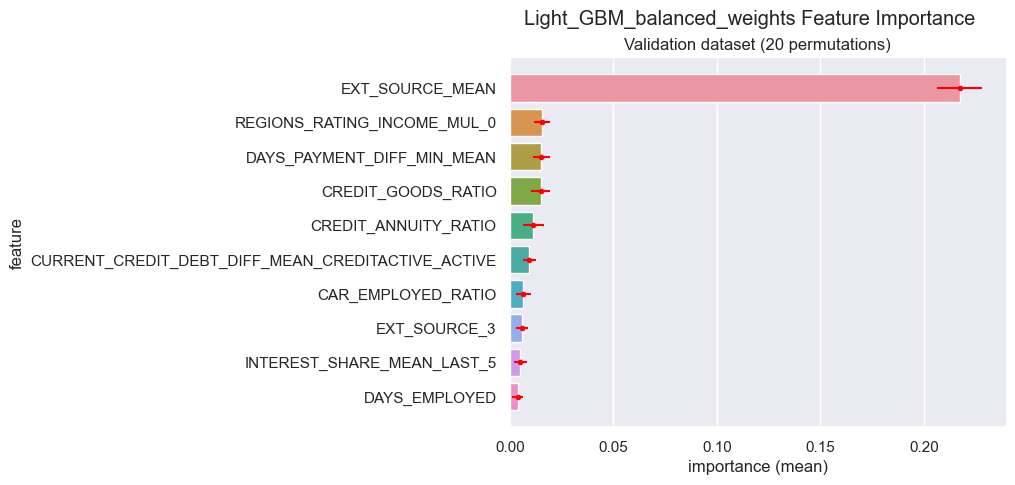

In [181]:
evaluate_permutation_importance(best_model,
                                X_val, y_val,
                                model_name=best_model_name,
                                scoring="recall")

<a id='best_model_shap_interpretability'></a>

## <span style='background:#0085dd'><span style='color:white'>Shap interpretability</span></span>

<a id='best_model_create_explainer'></a>

### <span style='background:#0075bc'><span style='color:white'>Create an explainer for the best model</span></span>

In [182]:
# load JS visualization code to notebook. Without this, the SHAP plots won't be displayed
shap.initjs()

# Train shap explainer using validation set
explainer = shap.TreeExplainer(best_model.named_steps['clf'], X_val)

1:80: E501 line too long (89 > 79 characters)


In [183]:
# Save explainer
path_explainer = '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/model_tests/lgbm_explainer.pkl'

with open(path_explainer, 'wb') as f:
    pickle.dump(explainer, f, pickle.HIGHEST_PROTOCOL)

2:80: E501 line too long (129 > 79 characters)


In [184]:
lgbm_shap_values = explainer.shap_values(X_val, check_additivity=False)

 99%|===================| 60886/61503 [00:47<00:00]        

<a id='best_model_global_interpretability'></a>

### <span style='background:#0075bc'><span style='color:white'>Global interpretability</span></span>

**Feature importances from shap**


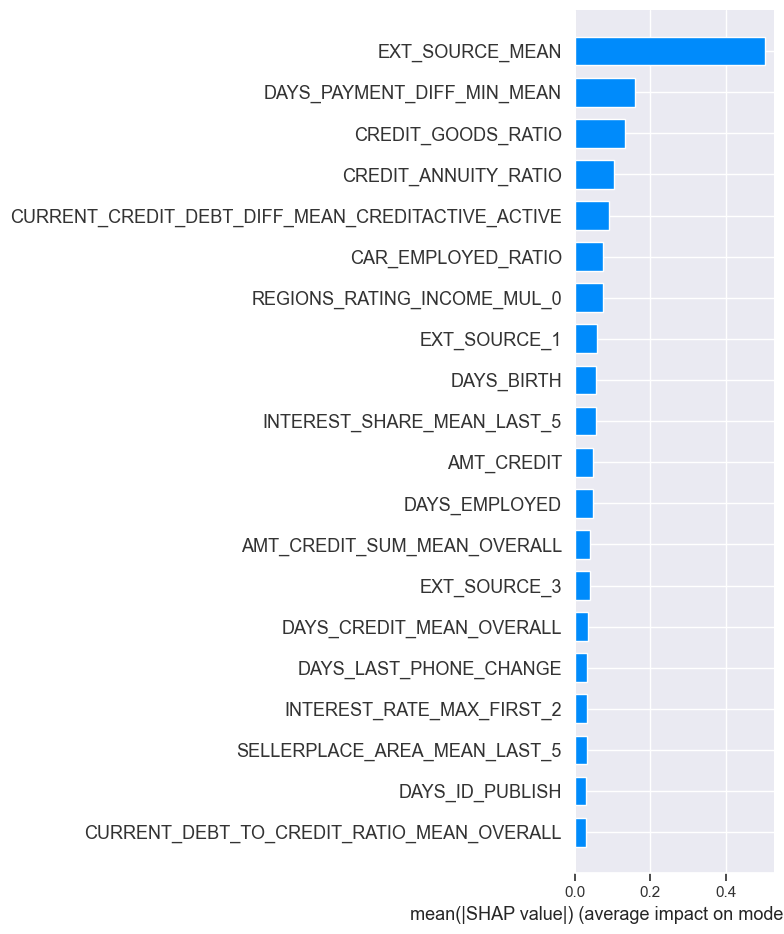

In [185]:
shap.summary_plot(lgbm_shap_values,
                  X_val, plot_type="bar")

**Distribution of shap values for all customers on features (beeswarm plot)**

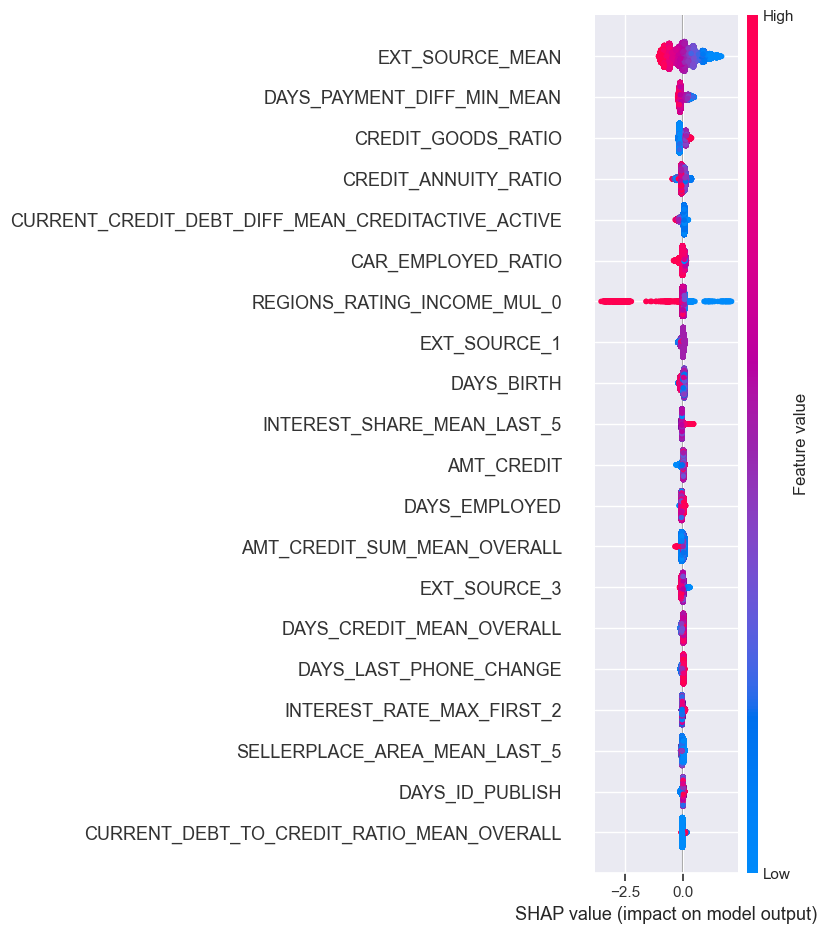

In [186]:
shap.summary_plot(lgbm_shap_values, X_val)

<a id='best_model_local_interpretability'></a>

### <span style='background:#0075bc'><span style='color:white'>Local interpretability</span></span>

In [187]:
# Dataset for compute
X_val_comp = X_val.copy()
# Dataset for store
X_val_stor = X_val.copy()
X_val_stor = X_val_stor.reset_index()

In [188]:
X_val_stor['proba'] = (best_model.predict_proba(X_val_comp)[:, 1])

**Explanation for the first X_val row**

In [189]:
shap.force_plot(explainer.expected_value,
                lgbm_shap_values[0, :], X_val.iloc[0, :])

In [190]:
def get_explanation(X_val:pd.DataFrame,
                    shap_values:np.ndarray,
                    idx:int,
                    expected_value) -> shap.Explanation:

    feature_names=list(X_val.columns)
    exp = shap.Explanation(shap_values[idx, :],
                           base_values=expected_value,
                           feature_names=feature_names,
                           data=X_val.iloc[idx, :])
    return exp

ValueError: too many values to unpack (expected 3)

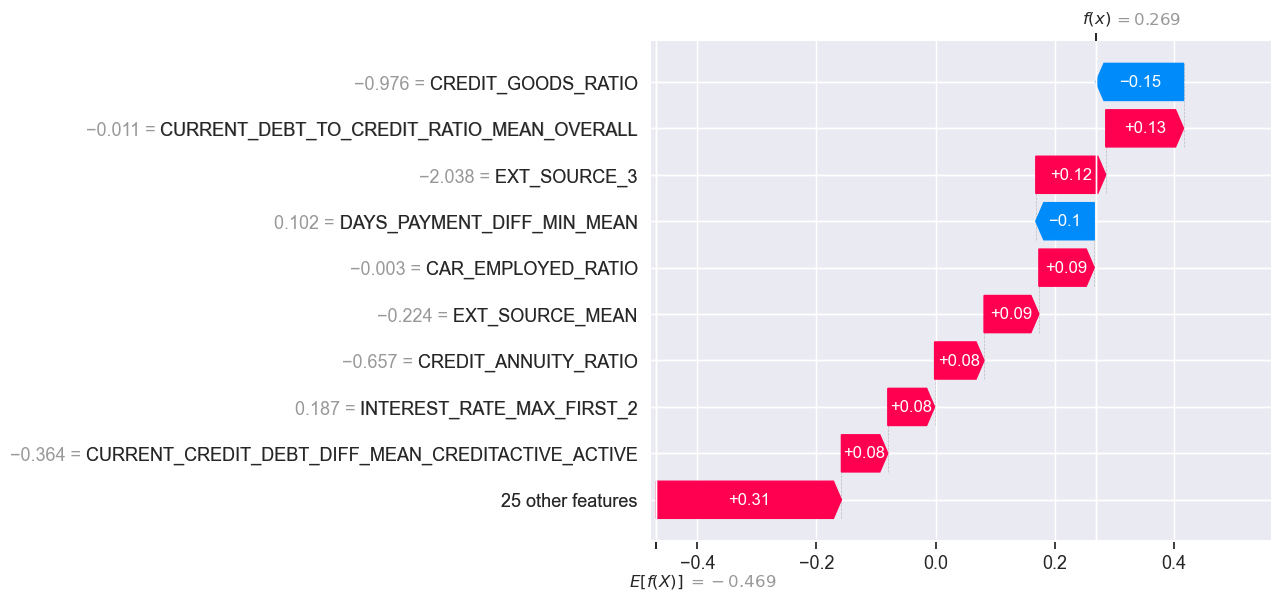

In [191]:
exp_0 = get_explanation(X_val, lgbm_shap_values, 0, explainer.expected_value)
shap.plots.waterfall(exp_0, max_display=10)

**Explanation for a customer at HIGH risk of default**

In [192]:
max_risk = X_val_stor['proba'].max() #  Highest risk

SK_ID_max_risk = X_val_stor.loc[X_val_stor['proba'] == max_risk, 'SK_ID_CURR'].iloc[0]

idx_max_risk = X_val_stor.loc[X_val_stor['SK_ID_CURR'] == SK_ID_max_risk].index.tolist()[0]

1:37: E261 at least two spaces before inline comment
1:38: E262 inline comment should start with '# '
3:80: E501 line too long (86 > 79 characters)
5:80: E501 line too long (91 > 79 characters)


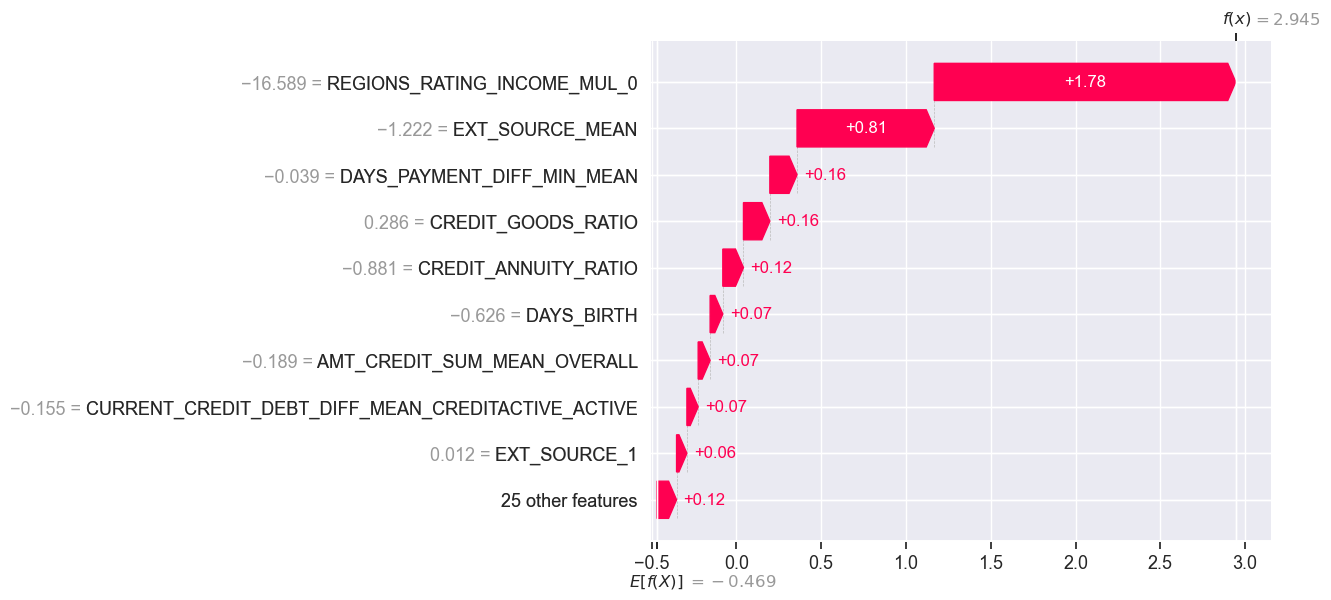

1:80: E501 line too long (91 > 79 characters)


In [193]:
print(f'\nClient with the highest risk, SK_ID_CURR = {SK_ID_max_risk}, y_proba={max_risk}')

exp_high_risk = get_explanation(X_val,
                                lgbm_shap_values,
                                idx_max_risk,
                                explainer.expected_value)

shap.plots.waterfall(exp_high_risk, max_display=10)

**Explanation for a customer at LOW risk of default**

In [194]:
min_risk = X_val_stor['proba'].min()  #  Lowest risk

SK_ID_min_risk = X_val_stor.loc[X_val_stor['proba'] == min_risk, 'SK_ID_CURR'].iloc[0]

idx_min_risk = X_val_stor.loc[X_val_stor['SK_ID_CURR'] == SK_ID_min_risk].index.tolist()[0]

1:39: E262 inline comment should start with '# '
3:80: E501 line too long (86 > 79 characters)
5:80: E501 line too long (91 > 79 characters)


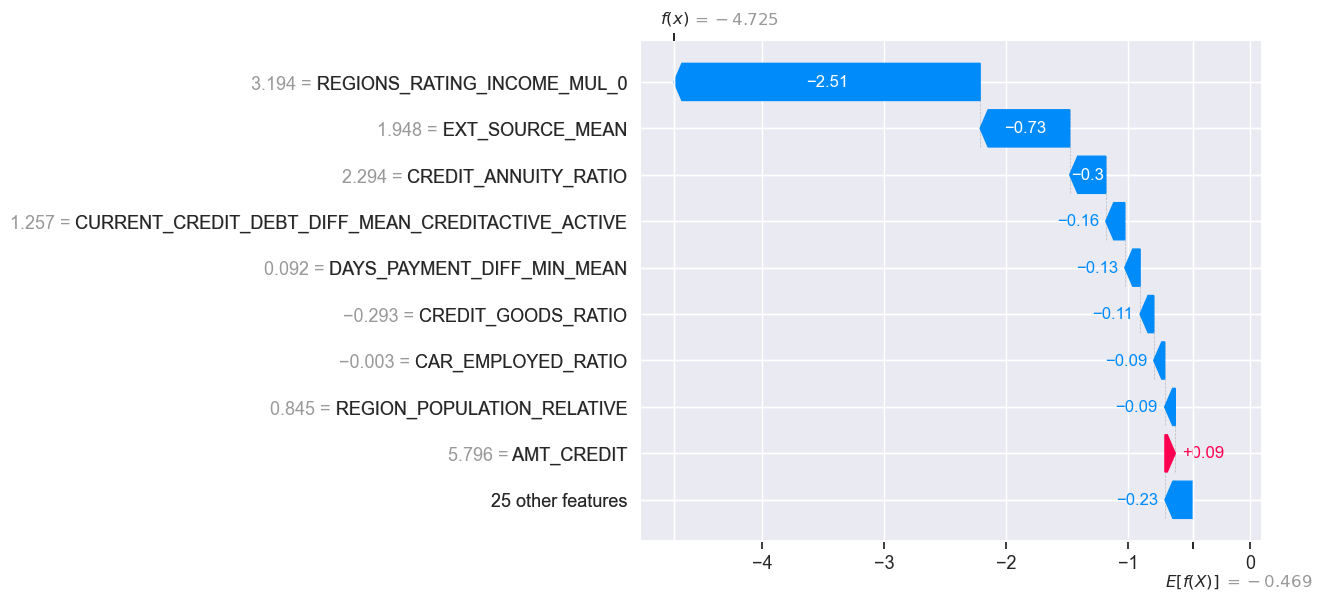

1:80: E501 line too long (90 > 79 characters)


In [195]:
print(f'\nClient with the lowest risk, SK_ID_CURR = {SK_ID_min_risk}, y_proba={min_risk}')

exp_low_risk = get_explanation(X_val,
                               lgbm_shap_values,
                               idx_min_risk,
                               explainer.expected_value)

shap.plots.waterfall(exp_low_risk, max_display=10)

**Explanation for the first 100 lines of X_val**

In [196]:
shap.force_plot(explainer.expected_value,
                lgbm_shap_values[:100, :],
                X_val.iloc[:100, :])